# Import and Install Dependencies

In [155]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
from math import exp
import mediapipe as mp
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay,log_loss

In [156]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

In [157]:
initial_learning_rate=0.1
batch_size=1
path="C:\\Users\\ganga\Jupyter Notebook\\FINAL YEAR PROJECT\\"

# Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Extract Keypoint Values

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    print(f'Pose: {pose}')
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    print(f'Face: {face}')
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    print(f'Left Hand: {lh}')
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    print(f'Right Hand: {rh}')
    return np.concatenate([pose, face, lh, rh])

# Setup Folders 

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['','hello', 'thank you', 'eat','help', 'excuse me', 'please'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'': 0,
 'hello': 1,
 'thank you': 2,
 'eat': 3,
 'help': 4,
 'excuse me': 5,
 'please': 6}

# Preprocess Data and Create Labels and Features

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(os.listdir(os.path.join(DATA_PATH, action)))

array(['20230207114402176281', '20230207114402285342',
       '20230207114402394528', '20230207114402503803',
       '20230207114402613654', '20230207114402723068',
       '20230207114402832061', '20230207114402940367',
       '20230207114403048626', '20230207114403157517',
       '20230207114403266604', '20230207114403376070',
       '20230207114403484819', '20230207114403593890',
       '20230207114403703309', '20230207114403812434',
       '20230207114403922207', '20230207114404030395',
       '20230207114404139637', '20230207114404248566',
       '20230207114404357928', '20230207114404465899',
       '20230207114404575350', '20230207114404684303',
       '20230207114404794421', '20230207114404904423',
       '20230207114405013451', '20230207114405122129',
       '20230207114405231102', '20230207114405340091',
       '20230207120811635397', '20230207120811744246',
       '20230207120811851884', '20230207120811960054',
       '20230207120812068836', '20230207120812176995',
       '20

In [18]:
np.array(sequences).shape

(1260, 30, 1662)

In [19]:
np.array(labels).shape

(1260,)

In [20]:
X = np.array(sequences)

In [21]:
X.shape

(1260, 30, 1662)

In [22]:
X

array([[[ 0.54207617,  0.36302966, -0.9649995 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54351079,  0.3640824 , -1.05005968, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54501402,  0.36557683, -1.14532971, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.54763758,  0.36452344, -1.07043803, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54843241,  0.36465889, -1.07754028, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54905778,  0.36477691, -1.0854758 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.54943639,  0.36475685, -1.07610261, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55009383,  0.36485019, -1.12124574, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54876423,  0.36416519, -1.1235069 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.49927211,  0.37452108, -1.44094789, ...,  

In [23]:
y = to_categorical(labels).astype(int)

In [24]:
y[:5]

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

In [26]:
y_test.shape

(252, 7)

# Build and Train LSTM Neural Network

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X.shape[1],X.shape[2])))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(128, return_sequences=True, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(64, return_sequences=False, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 596,807
Trainable params: 596,807
Non-trai

## 1

## 2

## 3

In [29]:
optimizer=Adam(decay=1e-4)
# optimizer=SGD(momentum=0.1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)#monitor=val_acc
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [30]:
checkpoints=ModelCheckpoint('Logs\\checkpoints\\' + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                 monitor='val_loss', save_weights_only=True, save_best_only=True)#, period=3)

In [71]:
model.fit(X, y, batch_size=30, epochs=1000, validation_data=(X_test, y_test), shuffle=True,callbacks=[early_stopping,checkpoints])

Epoch 1/1000
42/42 [==============================] - 7s 112ms/step - loss: 0.1051 - acc: 0.9667 - val_loss: 0.0668 - val_acc: 0.9802
Epoch 2/1000
42/42 [==============================] - 4s 87ms/step - loss: 0.0892 - acc: 0.9698 - val_loss: 0.0603 - val_acc: 0.9802
Epoch 3/1000
42/42 [==============================] - 4s 95ms/step - loss: 0.0833 - acc: 0.9754 - val_loss: 0.0563 - val_acc: 0.9802
Epoch 4/1000
42/42 [==============================] - 4s 89ms/step - loss: 0.0805 - acc: 0.9754 - val_loss: 0.0848 - val_acc: 0.9683
Epoch 5/1000
42/42 [==============================] - 4s 94ms/step - loss: 0.0761 - acc: 0.9778 - val_loss: 0.0433 - val_acc: 0.9881
Epoch 6/1000
42/42 [==============================] - 4s 91ms/step - loss: 0.0688 - acc: 0.9786 - val_loss: 0.0400 - val_acc: 0.9881
Epoch 7/1000
42/42 [==============================] - 4s 87ms/step - loss: 0.0690 - acc: 0.9810 - val_loss: 0.0413 - val_acc: 0.9881
Epoch 8/1000
42/42 [==============================] - 4s 86ms/step -

# Evaluation using Confusion Matrix and Accuracy

In [137]:
ypred = model.predict(X_test)

8/8 [==============================] - 0s 30ms/step


In [138]:
ypred

array([[5.5493359e-08, 5.4253052e-12, 4.2884076e-06, ..., 2.1463224e-04,
        9.9978083e-01, 3.1265914e-09],
       [3.1607857e-03, 3.5421082e-05, 9.7575867e-01, ..., 2.4682314e-03,
        8.2970923e-03, 1.0162330e-03],
       [7.6863616e-06, 9.8723946e-11, 1.1922053e-06, ..., 9.9508059e-01,
        4.9068080e-03, 1.8038814e-06],
       ...,
       [5.1998338e-08, 6.9767642e-12, 5.0952185e-05, ..., 1.0227370e-04,
        9.9984610e-01, 1.4291179e-09],
       [1.5323660e-05, 9.9998426e-01, 2.6295862e-12, ..., 1.3676522e-13,
        2.6169293e-22, 2.6262209e-21],
       [9.1448392e-08, 9.9999988e-01, 5.1691837e-16, ..., 8.9473290e-18,
        2.9530440e-29, 1.3156044e-29]], dtype=float32)

In [139]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [140]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[216,   0],
        [  1,  35]],

       [[211,   1],
        [  0,  40]],

       [[217,   0],
        [  2,  33]],

       [[209,   2],
        [  0,  41]],

       [[229,   0],
        [  0,  23]],

       [[209,   0],
        [  0,  43]],

       [[218,   0],
        [  0,  34]]], dtype=int64)

In [76]:
[label_map.keys()]

[dict_keys(['', 'hello', 'thank you', 'eat', 'help', 'excuse me', 'please'])]

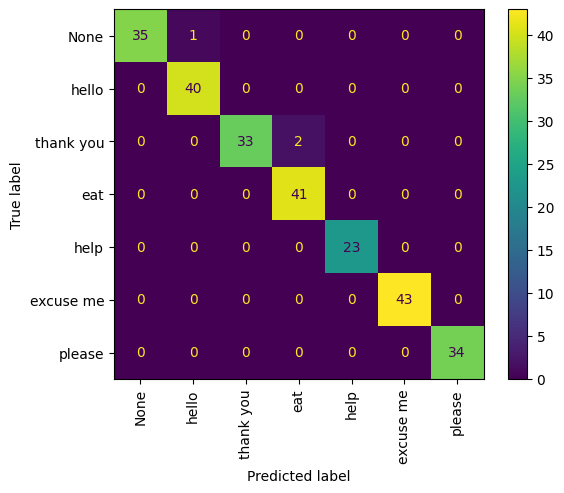

In [105]:
cmp=ConfusionMatrixDisplay.from_predictions(ytrue, ypred,display_labels=['None','hello', 'thank you', 'eat','help', 'excuse me', 'please'],xticks_rotation='vertical')

In [154]:
Loss,Accuracy=model.evaluate(X_test, y_test)
print(f'Accuracy : {round(Accuracy*100,2)}%\nLoss : {round(Loss,4)}')

8/8 [==============================] - 0s 37ms/step - loss: 0.0341 - acc: 0.9881
Accuracy : 98.81%
Loss : 0.0341


# Make Predictions

In [79]:
res = model.predict(X_test)

8/8 [==============================] - 0s 34ms/step


In [80]:
res

array([[5.5493359e-08, 5.4253052e-12, 4.2884076e-06, ..., 2.1463224e-04,
        9.9978083e-01, 3.1265914e-09],
       [3.1607857e-03, 3.5421082e-05, 9.7575867e-01, ..., 2.4682314e-03,
        8.2970923e-03, 1.0162330e-03],
       [7.6863616e-06, 9.8723946e-11, 1.1922053e-06, ..., 9.9508059e-01,
        4.9068080e-03, 1.8038814e-06],
       ...,
       [5.1998338e-08, 6.9767642e-12, 5.0952185e-05, ..., 1.0227370e-04,
        9.9984610e-01, 1.4291179e-09],
       [1.5323660e-05, 9.9998426e-01, 2.6295862e-12, ..., 1.3676522e-13,
        2.6169293e-22, 2.6262209e-21],
       [9.1448392e-08, 9.9999988e-01, 5.1691837e-16, ..., 8.9473290e-18,
        2.9530440e-29, 1.3156044e-29]], dtype=float32)

In [81]:
actions[np.argmax(res[4])]

'thank you'

In [82]:
actions[np.argmax(y_test[4])]

'thank you'

# Save Weights

In [88]:
model.save('action.h5')

In [84]:
from tensorflow.keras.models import load_model
model = load_model("action.h5")

In [44]:
test_DATA_PATH='MP_Data_Pl_HL_EM_GD'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

KeyError: 'None'

In [44]:
test_DATA_PATH='MP_Data_Pl_HL_EM_GD_2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 27ms/step


0.975

In [45]:
test_DATA_PATH='MP_Data_Pl_HL_EM_UD'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 1s 122ms/step


0.975

In [46]:
test_DATA_PATH='MP_Data_Pl_HL_EM_UD_2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 36ms/step


0.9666666666666667

In [84]:
test_DATA_PATH='MP_Data_Pl_HL_EM_KUN'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 2s 39ms/step


0.9583333333333334

In [85]:
test_DATA_PATH='MP_Data_Pl_HL_EM_KUN_2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 1s 136ms/step


0.9833333333333333

# Test in Real Time

In [44]:
from tensorflow.keras.models import load_model
model = load_model("action.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 596,807
Trainable params: 596,807
Non-trai

In [158]:
from scipy import stats

In [159]:
colors = [(255, 0, 0),(245,117,16), (117,245,16), (16,117,245),(149, 235, 52),(52, 235, 162),(235, 52, 156)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [162]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Pose: [ 5.65154552e-01  4.81141448e-01 -9.85588670e-01  9.99887466e-01
  5.94465077e-01  4.05975938e-01 -9.40392196e-01  9.99790013e-01
  6.14597559e-01  4.02425766e-01 -9.40518975e-01  9.99814451e-01
  6.30458891e-01  4.01064038e-01 -9.41095710e-01  9.99771178e-01
  5.36140621e-01  4.17532802e-01 -9.23460364e-01  9.99809682e-01
  5.17261505e-01  4.22520638e-01 -9.22530293e-01  9.99842167e-01
  4.99886274e-01  4.26562667e-01 -9.22942340e-01  9.99831796e-01
  6.64340794e-01  4.26474929e-01 -5.51605701e-01  9.99820650e-01
  4.89210695e-01  4.47938919e-01 -4.45046902e-01  9.99890208e-01
  6.07487202e-01  5.40439844e-01 -8.34762692e-01  9.99932528e-01
  5.32309413e-01  5.55388093e-01 -8.04525197e-01  9.99938011e-01
  8.50078583e-01  7.63702452e-01 -3.12342733e-01  9.98721421e-01
  3.85997772e-01  8.24706852e-01 -2.72810668e-01  9.99692440e-01
  9.73245978e-01  1.23637748e+00 -3.67141604e-01  2.62290657e-01
  3.02017719e-01  1.28857768e+00 -4.38945353e-01  5.71902514e-01
  9.56788540e-01  1

Pose: [ 5.70289135e-01  4.49085116e-01 -9.54028130e-01  9.99926090e-01
  5.97759485e-01  3.75972271e-01 -9.01148140e-01  9.99859631e-01
  6.18532777e-01  3.73125762e-01 -9.01185691e-01  9.99877095e-01
  6.34912372e-01  3.70318800e-01 -9.01578605e-01  9.99848127e-01
  5.36424756e-01  3.84113312e-01 -8.88371110e-01  9.99869585e-01
  5.18245220e-01  3.85278732e-01 -8.87340248e-01  9.99891460e-01
  5.02803326e-01  3.88289809e-01 -8.87636065e-01  9.99880195e-01
  6.64090693e-01  3.97968262e-01 -4.96680349e-01  9.99880254e-01
  4.91821826e-01  4.21228260e-01 -4.16517973e-01  9.99920964e-01
  6.11281455e-01  5.14072776e-01 -8.05079460e-01  9.99953449e-01
  5.39149642e-01  5.22263765e-01 -7.78552711e-01  9.99953985e-01
  8.57032120e-01  7.41763949e-01 -2.73012310e-01  9.99141395e-01
  3.80741864e-01  8.40983093e-01 -2.70811915e-01  9.99674499e-01
  9.78584886e-01  9.97902513e-01 -3.60531628e-01  2.84055620e-01
  3.19885194e-01  1.30905497e+00 -4.42932069e-01  4.44410205e-01
  1.01356792e+00  1

Pose: [ 6.05789900e-01  4.34264570e-01 -9.06406045e-01  9.99939203e-01
  6.31235957e-01  3.64417493e-01 -8.58604431e-01  9.99882460e-01
  6.48185015e-01  3.61945421e-01 -8.58447075e-01  9.99895096e-01
  6.66445613e-01  3.59882772e-01 -8.58837485e-01  9.99873221e-01
  5.75260222e-01  3.73555273e-01 -8.40475738e-01  9.99890864e-01
  5.57910681e-01  3.75544995e-01 -8.39516282e-01  9.99907374e-01
  5.42291284e-01  3.78574193e-01 -8.39689910e-01  9.99898076e-01
  7.01060951e-01  3.86731565e-01 -4.90859121e-01  9.99896049e-01
  5.25162935e-01  4.12808806e-01 -3.87029558e-01  9.99929488e-01
  6.47481978e-01  4.97341275e-01 -7.71547198e-01  9.99957979e-01
  5.78650713e-01  5.06047666e-01 -7.39266932e-01  9.99957323e-01
  8.73513222e-01  7.19131291e-01 -3.06710571e-01  9.99240994e-01
  4.32920635e-01  8.16214859e-01 -2.44663835e-01  9.99652863e-01
  1.01609313e+00  9.43981111e-01 -3.03144783e-01  2.92517483e-01
  3.69901270e-01  1.25803113e+00 -4.50922430e-01  3.96761715e-01
  1.14425075e+00  1

Pose: [ 6.75226331e-01  2.83750087e-01 -8.71867657e-01  9.99938548e-01
  7.04064608e-01  2.17898816e-01 -8.39290500e-01  9.99879360e-01
  7.24870622e-01  2.16164827e-01 -8.39626968e-01  9.99886334e-01
  7.45596409e-01  2.13961840e-01 -8.40247154e-01  9.99865711e-01
  6.43179953e-01  2.22743064e-01 -8.19365621e-01  9.99891579e-01
  6.21594667e-01  2.25002289e-01 -8.18818867e-01  9.99904692e-01
  6.02495551e-01  2.26183549e-01 -8.19376767e-01  9.99900579e-01
  7.80706704e-01  2.33353421e-01 -5.27980089e-01  9.99884963e-01
  5.86062789e-01  2.49631912e-01 -4.15744007e-01  9.99928772e-01
  7.13780820e-01  3.58912528e-01 -7.53387809e-01  9.99954581e-01
  6.48703635e-01  3.64425302e-01 -7.20348597e-01  9.99957323e-01
  9.35742974e-01  5.99908888e-01 -3.28454137e-01  9.99038160e-01
  4.87888724e-01  6.72400773e-01 -2.70791948e-01  9.99590158e-01
  1.06037831e+00  9.87327218e-01 -3.47609639e-01  3.13814521e-01
  4.28009927e-01  1.01534951e+00 -2.52188027e-01  3.80211353e-01
  1.08120978e+00  1

Pose: [ 6.73782766e-01  2.91334122e-01 -8.28387618e-01  9.99921143e-01
  7.05691934e-01  2.10603029e-01 -7.81080365e-01  9.99843836e-01
  7.25939691e-01  2.05602556e-01 -7.80936122e-01  9.99841750e-01
  7.44602382e-01  2.03742832e-01 -7.81169057e-01  9.99813735e-01
  6.39963567e-01  2.19716117e-01 -7.76999772e-01  9.99870360e-01
  6.18311882e-01  2.22423881e-01 -7.76259899e-01  9.99885023e-01
  5.99828124e-01  2.25256130e-01 -7.76484311e-01  9.99888957e-01
  7.75433540e-01  2.26386741e-01 -4.51826483e-01  9.99822438e-01
  5.84656537e-01  2.56139368e-01 -4.14137185e-01  9.99922097e-01
  7.14811921e-01  3.57264817e-01 -7.05399394e-01  9.99940336e-01
  6.41998589e-01  3.71886045e-01 -6.91186547e-01  9.99953568e-01
  9.44313705e-01  5.85195422e-01 -3.36254656e-01  9.98564184e-01
  4.65184301e-01  7.02399194e-01 -3.52024645e-01  9.99599874e-01
  1.04064894e+00  9.09769058e-01 -4.50202763e-01  2.69990295e-01
  3.98818165e-01  1.17143381e+00 -4.61913824e-01  4.22055751e-01
  1.05931318e+00  1

Pose: [ 5.93779683e-01  4.23496157e-01 -8.61630261e-01  9.99939263e-01
  6.26232862e-01  3.50929379e-01 -7.93388844e-01  9.99879241e-01
  6.49240553e-01  3.49391997e-01 -7.93133080e-01  9.99876559e-01
  6.69592321e-01  3.49442422e-01 -7.93197036e-01  9.99858201e-01
  5.66689789e-01  3.56294572e-01 -7.99246192e-01  9.99898255e-01
  5.47830343e-01  3.57868940e-01 -7.98402488e-01  9.99907792e-01
  5.29872000e-01  3.61200869e-01 -7.98478544e-01  9.99910653e-01
  6.94257259e-01  3.71656150e-01 -4.28528786e-01  9.99862671e-01
  5.09437621e-01  3.90296936e-01 -3.83735955e-01  9.99932826e-01
  6.31770790e-01  4.96987462e-01 -7.07834840e-01  9.99951422e-01
  5.65645754e-01  4.99421418e-01 -7.10188329e-01  9.99960065e-01
  8.32312703e-01  7.15125024e-01 -2.29416087e-01  9.98921275e-01
  3.72996211e-01  7.77624965e-01 -2.48380929e-01  9.99588907e-01
  1.00053477e+00  9.82642353e-01 -2.31049448e-01  3.21130306e-01
  2.89543420e-01  1.22883677e+00 -4.46844965e-01  3.70187759e-01
  1.13482213e+00  1

Pose: [ 5.64361453e-01  4.16932791e-01 -1.15975869e+00  9.99786317e-01
  5.96876979e-01  3.48447233e-01 -1.09478652e+00  9.99520183e-01
  6.17349088e-01  3.48972201e-01 -1.09537590e+00  9.99516606e-01
  6.34253860e-01  3.50362480e-01 -1.09564543e+00  9.99427378e-01
  5.31397045e-01  3.49660218e-01 -1.09217036e+00  9.99605238e-01
  5.11615157e-01  3.48500043e-01 -1.09166837e+00  9.99653280e-01
  4.94656026e-01  3.49617928e-01 -1.09215832e+00  9.99668598e-01
  6.56621337e-01  3.81740510e-01 -6.56855464e-01  9.99376237e-01
  4.76590216e-01  3.80229115e-01 -6.24938846e-01  9.99702096e-01
  6.02678716e-01  4.88129914e-01 -9.93329883e-01  9.99747455e-01
  5.25353014e-01  4.85862195e-01 -9.83841240e-01  9.99835670e-01
  7.95750380e-01  7.41906941e-01 -3.48576367e-01  9.97559667e-01
  3.36569130e-01  7.78465807e-01 -3.67332757e-01  9.98362005e-01
  9.58502948e-01  9.63389993e-01 -4.46933448e-01  3.02445650e-01
  2.31317788e-01  1.24251556e+00 -3.60533774e-01  3.46704721e-01
  1.08620763e+00  1

1/1 [==============================] - 0s 33ms/step

Pose: [ 5.68154156e-01  2.30132625e-01 -9.64980602e-01  9.99821961e-01
  6.00931168e-01  1.61256090e-01 -9.31093872e-01  9.99621332e-01
  6.21402383e-01  1.60122350e-01 -9.31055427e-01  9.99607265e-01
  6.38175964e-01  1.60628468e-01 -9.31612492e-01  9.99540091e-01
  5.35392582e-01  1.66259825e-01 -9.20060337e-01  9.99684930e-01
  5.12297034e-01  1.68442771e-01 -9.19140220e-01  9.99716401e-01
  4.93308246e-01  1.70430139e-01 -9.19302166e-01  9.99730110e-01
  6.64475858e-01  1.85399875e-01 -5.70942104e-01  9.99518812e-01
  4.74356741e-01  1.96591094e-01 -5.30495286e-01  9.99765217e-01
  6.08241856e-01  3.00441265e-01 -8.37845206e-01  9.99805152e-01
  5.29737830e-01  3.07478517e-01 -8.17126870e-01  9.99872804e-01
  8.09564292e-01  5.53655744e-01 -3.56526852e-01  9.97818470e-01
  3.32675099e-01  6.07066929e-01 -3.67891908e-01  9.98375952e-01
  9.69279885e-01  8.44870865e-01 -3.33152115e-01  3.29576582e-01
  2.23735541e-01  9.70053732e-0

1/1 [==============================] - 0s 34ms/step

Pose: [ 5.21176517e-01  3.19868773e-01 -9.37483490e-01  9.99843895e-01
  5.51408410e-01  2.46481106e-01 -8.83478940e-01  9.99659240e-01
  5.73874712e-01  2.43661031e-01 -8.83669198e-01  9.99653161e-01
  5.92586637e-01  2.42996171e-01 -8.84066582e-01  9.99594986e-01
  4.90456164e-01  2.54831940e-01 -8.80769610e-01  9.99710977e-01
  4.74163443e-01  2.56737411e-01 -8.79903436e-01  9.99741077e-01
  4.57492173e-01  2.59699881e-01 -8.80297303e-01  9.99748588e-01
  6.19068027e-01  2.60103077e-01 -5.05092263e-01  9.99572515e-01
  4.40970242e-01  2.80666947e-01 -4.65910584e-01  9.99788284e-01
  5.61910510e-01  3.86635929e-01 -7.93967783e-01  9.99830008e-01
  4.88591433e-01  3.94975096e-01 -7.82855630e-01  9.99883354e-01
  7.84005523e-01  6.38592720e-01 -2.94901401e-01  9.98235047e-01
  2.92324543e-01  6.77692235e-01 -3.40665460e-01  9.98699129e-01
  8.58090758e-01  1.02671158e+00 -2.79386967e-01  3.05691123e-01
  1.94153428e-01  1.03234088e+0

1/1 [==============================] - 0s 31ms/step

Pose: [ 5.61235070e-01  1.98863328e-01 -9.76674557e-01  9.99830604e-01
  5.95303714e-01  1.33887559e-01 -9.01381850e-01  9.99673843e-01
  6.16183281e-01  1.35045514e-01 -9.01731372e-01  9.99665916e-01
  6.35660112e-01  1.36664405e-01 -9.01752174e-01  9.99616981e-01
  5.31512380e-01  1.36636242e-01 -8.98723602e-01  9.99705911e-01
  5.11073411e-01  1.38372943e-01 -8.98918748e-01  9.99731958e-01
  4.93773997e-01  1.40629113e-01 -8.99502933e-01  9.99742270e-01
  6.56458974e-01  1.62312090e-01 -4.37095702e-01  9.99601901e-01
  4.70670879e-01  1.67593032e-01 -4.46618080e-01  9.99796212e-01
  5.93456864e-01  2.66479760e-01 -8.06581318e-01  9.99821126e-01
  5.17221034e-01  2.71026105e-01 -8.04958045e-01  9.99876261e-01
  7.88378894e-01  5.44636488e-01 -2.58649826e-01  9.96888518e-01
  3.37947667e-01  5.21073997e-01 -1.50909454e-01  9.98095453e-01
  8.45188618e-01  9.81466174e-01 -3.84802878e-01  3.04101557e-01
  1.86358064e-01  8.94439995e-0

1/1 [==============================] - 0s 32ms/step

Pose: [ 4.86953408e-01  1.05365418e-01 -8.87529671e-01  9.99797583e-01
  5.09879708e-01  3.59059386e-02 -8.34463716e-01  9.99598980e-01
  5.31104922e-01  3.54925133e-02 -8.34868133e-01  9.99613285e-01
  5.51555693e-01  3.55773419e-02 -8.35411549e-01  9.99564528e-01
  4.48798269e-01  4.09948044e-02 -8.20363641e-01  9.99594390e-01
  4.25068557e-01  4.40125391e-02 -8.19903553e-01  9.99635935e-01
  4.01159048e-01  4.73854467e-02 -8.20474327e-01  9.99623299e-01
  5.86009204e-01  6.44119680e-02 -4.89199162e-01  9.99568999e-01
  3.82918775e-01  7.73659199e-02 -4.04556572e-01  9.99714255e-01
  5.21433115e-01  1.75469011e-01 -7.56737173e-01  9.99815345e-01
  4.50187594e-01  1.79919347e-01 -7.34448195e-01  9.99856174e-01
  7.63596654e-01  4.57615048e-01 -3.81537527e-01  9.97263074e-01
  2.68355072e-01  4.65460896e-01 -2.29732543e-01  9.97794151e-01
  8.32377613e-01  9.43791449e-01 -4.22513247e-01  3.23825479e-01
  1.34874433e-01  8.81604731e-0

1/1 [==============================] - 0s 32ms/step

Pose: [ 5.57621777e-01  1.40251338e-01 -1.17410469e+00  9.99811232e-01
  5.84539890e-01  6.76963553e-02 -1.10341561e+00  9.99643505e-01
  6.04121447e-01  6.72578365e-02 -1.10394216e+00  9.99657750e-01
  6.24073029e-01  6.81004152e-02 -1.10405755e+00  9.99615610e-01
  5.24312794e-01  7.33270347e-02 -1.09477746e+00  9.99637246e-01
  5.00732899e-01  7.76838139e-02 -1.09478140e+00  9.99672771e-01
  4.80558306e-01  8.26920941e-02 -1.09550202e+00  9.99660730e-01
  6.57192826e-01  9.67964828e-02 -6.52748644e-01  9.99638438e-01
  4.58367974e-01  1.16534561e-01 -6.06021225e-01  9.99732494e-01
  5.87908030e-01  2.09617004e-01 -1.00497210e+00  9.99798179e-01
  5.24205804e-01  2.18498051e-01 -9.92776394e-01  9.99827385e-01
  8.32141042e-01  4.89849955e-01 -4.50939119e-01  9.96436417e-01
  3.56883913e-01  5.21966457e-01 -3.13891977e-01  9.95947361e-01
  9.06614423e-01  9.53117073e-01 -5.59395492e-01  3.01769704e-01
  2.24930555e-01  9.14042115e-0

1/1 [==============================] - 0s 32ms/step

Pose: [ 5.86986303e-01  5.93479872e-02 -9.29087937e-01  9.99614418e-01
  6.17128432e-01 -2.29265098e-03 -8.83575618e-01  9.99253631e-01
  6.35417163e-01 -1.04236032e-03 -8.83834720e-01  9.99329448e-01
  6.54999852e-01  1.21802115e-03 -8.84325147e-01  9.99205470e-01
  5.60044885e-01 -1.46488877e-04 -8.58349204e-01  9.99150991e-01
  5.38476586e-01  2.49183876e-03 -8.57927442e-01  9.99267220e-01
  5.18436730e-01  5.82383526e-03 -8.58566403e-01  9.99171317e-01
  6.99070036e-01  3.57052349e-02 -5.46433687e-01  9.99329269e-01
  5.00140786e-01  4.23029475e-02 -4.09467220e-01  9.99411941e-01
  6.21738791e-01  1.28446087e-01 -8.03912818e-01  9.99717653e-01
  5.51663697e-01  1.35519639e-01 -7.65282929e-01  9.99722600e-01
  8.71551812e-01  4.32049960e-01 -4.41742808e-01  9.96902645e-01
  3.78996253e-01  4.15073395e-01 -2.55254358e-01  9.96454895e-01
  9.31147933e-01  9.09221470e-01 -4.42967594e-01  3.17769855e-01
  1.53988987e-01  7.46625125e-0

1/1 [==============================] - 0s 36ms/step

Pose: [ 6.01184011e-01  2.38656580e-01 -9.14387226e-01  9.99707818e-01
  6.35662556e-01  1.60062417e-01 -8.50278556e-01  9.99462962e-01
  6.56380296e-01  1.59435913e-01 -8.50483060e-01  9.99510765e-01
  6.75924361e-01  1.59925207e-01 -8.50894928e-01  9.99430716e-01
  5.67832828e-01  1.64464846e-01 -8.53458405e-01  9.99391556e-01
  5.44292271e-01  1.66260049e-01 -8.53267491e-01  9.99467075e-01
  5.23072124e-01  1.68671802e-01 -8.53812099e-01  9.99406040e-01
  7.04926372e-01  1.88139543e-01 -4.39487398e-01  9.99520063e-01
  4.99550492e-01  1.94624573e-01 -4.14158404e-01  9.99580979e-01
  6.37557030e-01  3.16167086e-01 -7.64677286e-01  9.99789655e-01
  5.61245680e-01  3.24372202e-01 -7.62013316e-01  9.99791682e-01
  8.66585732e-01  6.08757019e-01 -2.57631779e-01  9.97314692e-01
  3.72921139e-01  5.86305857e-01 -2.71117538e-01  9.97128665e-01
  9.11600292e-01  1.00770104e+00 -3.08404744e-01  2.83997536e-01
  1.27649158e-01  8.09022784e-0

1/1 [==============================] - 0s 33ms/step

Pose: [ 6.19987965e-01  3.85434330e-01 -1.11966753e+00  9.99707341e-01
  6.48951411e-01  3.15194964e-01 -1.03498304e+00  9.99502599e-01
  6.69028759e-01  3.15363199e-01 -1.03535485e+00  9.99540210e-01
  6.87190175e-01  3.16046834e-01 -1.03587902e+00  9.99479473e-01
  5.84561288e-01  3.17736536e-01 -1.04397523e+00  9.99429345e-01
  5.60526609e-01  3.20308656e-01 -1.04344368e+00  9.99493599e-01
  5.39223254e-01  3.23727399e-01 -1.04401851e+00  9.99447048e-01
  7.10277259e-01  3.47441047e-01 -4.94471371e-01  9.99547780e-01
  5.12856901e-01  3.56013030e-01 -5.35816789e-01  9.99595642e-01
  6.54589295e-01  4.63824928e-01 -9.23570156e-01  9.99793410e-01
  5.80709457e-01  4.72846895e-01 -9.32802975e-01  9.99782503e-01
  8.63219261e-01  7.53163040e-01 -2.50924379e-01  9.97361839e-01
  3.77499759e-01  7.12144136e-01 -2.87606150e-01  9.97039199e-01
  9.06452775e-01  1.22252774e+00 -2.91038424e-01  2.66079158e-01
  1.68379009e-01  9.21131909e-0

1/1 [==============================] - 0s 33ms/step

Pose: [ 6.12385511e-01  3.91654104e-01 -1.27177739e+00  9.99527276e-01
  6.44823909e-01  3.17875654e-01 -1.20071244e+00  9.99193072e-01
  6.63322330e-01  3.16537201e-01 -1.20138788e+00  9.99240220e-01
  6.80244207e-01  3.16869199e-01 -1.20183492e+00  9.99125898e-01
  5.80752969e-01  3.24443519e-01 -1.20499635e+00  9.99136090e-01
  5.59542656e-01  3.27348650e-01 -1.20440722e+00  9.99237299e-01
  5.39890766e-01  3.30880463e-01 -1.20509708e+00  9.99210715e-01
  7.05315351e-01  3.41318011e-01 -6.95645213e-01  9.99119461e-01
  5.14862597e-01  3.52980345e-01 -6.93281949e-01  9.99406695e-01
  6.51199877e-01  4.62123185e-01 -1.08009124e+00  9.99656379e-01
  5.76819777e-01  4.73234236e-01 -1.07895780e+00  9.99671459e-01
  8.61037552e-01  7.36384928e-01 -3.74696910e-01  9.95882571e-01
  3.67327631e-01  7.36832917e-01 -4.04695272e-01  9.95859444e-01
  9.28305984e-01  1.16253531e+00 -4.22083437e-01  2.26730645e-01
  1.93829775e-01  1.18432486e+0

1/1 [==============================] - 0s 34ms/step

Pose: [ 5.98328710e-01  4.65701222e-01 -1.22536087e+00  9.98222589e-01
  6.26103520e-01  4.03721601e-01 -1.16190696e+00  9.97377396e-01
  6.44715607e-01  4.02786285e-01 -1.16264057e+00  9.97215688e-01
  6.58378005e-01  4.02201355e-01 -1.16319716e+00  9.97313559e-01
  5.69156229e-01  4.07259285e-01 -1.14879584e+00  9.97164309e-01
  5.51629066e-01  4.08710778e-01 -1.14860046e+00  9.97177720e-01
  5.35453081e-01  4.10097688e-01 -1.14919591e+00  9.97522175e-01
  6.82741523e-01  4.17133301e-01 -6.89279079e-01  9.96937692e-01
  5.21447837e-01  4.25787240e-01 -6.11164868e-01  9.97280955e-01
  6.35357141e-01  5.28002381e-01 -1.04340374e+00  9.98797357e-01
  5.73312402e-01  5.41012526e-01 -1.02274776e+00  9.98656094e-01
  8.28742206e-01  7.53524780e-01 -3.73327881e-01  9.91626084e-01
  4.28453386e-01  7.71400988e-01 -2.25964859e-01  9.91874397e-01
  9.31364417e-01  1.16259909e+00 -3.78969848e-01  2.00898498e-01
  3.42105925e-01  1.16684401e+0

1/1 [==============================] - 0s 35ms/step

Pose: [ 5.98566830e-01  4.60498631e-01 -1.23810554e+00  9.98605072e-01
  6.25888109e-01  3.95947725e-01 -1.16223693e+00  9.97877002e-01
  6.43947482e-01  3.93765658e-01 -1.16244280e+00  9.97712135e-01
  6.57723010e-01  3.91870558e-01 -1.16254950e+00  9.97736752e-01
  5.69493353e-01  4.01693285e-01 -1.14748132e+00  9.97766078e-01
  5.51152825e-01  4.03222769e-01 -1.14742672e+00  9.97807801e-01
  5.34227252e-01  4.04496968e-01 -1.14798248e+00  9.98092532e-01
  6.82712853e-01  4.08391535e-01 -6.55526698e-01  9.97371912e-01
  5.19187212e-01  4.22282100e-01 -5.34595609e-01  9.97910857e-01
  6.35915875e-01  5.20357728e-01 -1.04931855e+00  9.98996854e-01
  5.72914839e-01  5.32609105e-01 -1.02465165e+00  9.98934209e-01
  8.32988441e-01  7.57995546e-01 -3.06743711e-01  9.91422176e-01
  4.19020414e-01  7.67627180e-01 -2.46163100e-01  9.93767262e-01
  9.45307374e-01  1.20719016e+00 -2.30787396e-01  2.38535538e-01
  1.13961890e-01  9.31151032e-0

1/1 [==============================] - 0s 40ms/step
eat
Pose: [ 5.95958829e-01  4.60042596e-01 -1.20091105e+00  9.98922884e-01
  6.22693598e-01  3.94901574e-01 -1.13642907e+00  9.98333633e-01
  6.41344130e-01  3.94576609e-01 -1.13685584e+00  9.98172760e-01
  6.55893564e-01  3.92259270e-01 -1.13691974e+00  9.98193145e-01
  5.67485452e-01  3.98297191e-01 -1.09286201e+00  9.98260081e-01
  5.48867106e-01  3.99584472e-01 -1.09256434e+00  9.98289347e-01
  5.31998098e-01  4.01019543e-01 -1.09291577e+00  9.98530269e-01
  6.80709720e-01  4.04525638e-01 -6.58758759e-01  9.97897387e-01
  5.16787291e-01  4.19405133e-01 -4.53726441e-01  9.98377085e-01
  6.33507311e-01  5.21195233e-01 -1.02916646e+00  9.99211609e-01
  5.69978118e-01  5.31873107e-01 -9.66108680e-01  9.99163747e-01
  8.40085983e-01  7.54204631e-01 -3.90863538e-01  9.92647707e-01
  4.17582273e-01  7.50680506e-01 -1.02205910e-01  9.95179534e-01
  9.50020671e-01  1.21574068e+00 -4.48011488e-01  2.79599756e-01
  1.39675304e-01  1.09793353

1/1 [==============================] - 0s 30ms/step
hello
Pose: [ 5.94924629e-01  4.55196261e-01 -1.30963027e+00  9.99141455e-01
  6.21146560e-01  3.90518576e-01 -1.24267948e+00  9.98654187e-01
  6.40192389e-01  3.89155000e-01 -1.24316537e+00  9.98509884e-01
  6.55058682e-01  3.86487693e-01 -1.24307239e+00  9.98501539e-01
  5.66570222e-01  3.94080311e-01 -1.23642755e+00  9.98621643e-01
  5.48024535e-01  3.95500928e-01 -1.23677349e+00  9.98653889e-01
  5.31219780e-01  3.97129923e-01 -1.23742461e+00  9.98848498e-01
  6.79251730e-01  4.01557237e-01 -7.10046947e-01  9.98297751e-01
  5.15315711e-01  4.16972756e-01 -6.78436995e-01  9.98725474e-01
  6.31853759e-01  5.17546594e-01 -1.10215497e+00  9.99357224e-01
  5.67418993e-01  5.28150141e-01 -1.09407663e+00  9.99328315e-01
  8.42993438e-01  7.51596332e-01 -3.78337473e-01  9.93169308e-01
  3.99624437e-01  7.61493504e-01 -2.94075102e-01  9.96025860e-01
  9.51701999e-01  1.21256363e+00 -5.28019786e-01  3.14844668e-01
  1.91491753e-01  1.184085

1/1 [==============================] - 0s 32ms/step

Pose: [ 5.95213056e-01  4.32242870e-01 -1.27230167e+00  9.99010623e-01
  6.20758057e-01  3.61519843e-01 -1.20501018e+00  9.98507380e-01
  6.39713764e-01  3.58455271e-01 -1.20553374e+00  9.98362422e-01
  6.54466271e-01  3.55738044e-01 -1.20572591e+00  9.98359501e-01
  5.66638112e-01  3.70404184e-01 -1.19321752e+00  9.98436809e-01
  5.48360527e-01  3.71748149e-01 -1.19316459e+00  9.98458087e-01
  5.31556904e-01  3.73145044e-01 -1.19376194e+00  9.98662829e-01
  6.78084791e-01  3.79066437e-01 -7.08343387e-01  9.98164892e-01
  5.15025079e-01  3.98131520e-01 -6.46138072e-01  9.98487294e-01
  6.31664395e-01  4.97100145e-01 -1.08246017e+00  9.99250948e-01
  5.67604125e-01  5.04749119e-01 -1.06412387e+00  9.99213755e-01
  8.46001327e-01  7.38385081e-01 -3.97278428e-01  9.92392004e-01
  4.00735706e-01  7.60320067e-01 -2.92083800e-01  9.93999481e-01
  9.36650097e-01  1.15885282e+00 -4.09060150e-01  2.72711575e-01
  3.33743513e-01  1.19517291e+0

1/1 [==============================] - 0s 30ms/step

Pose: [ 6.00521326e-01  4.25829560e-01 -1.12610781e+00  9.98968124e-01
  6.22952640e-01  3.51804793e-01 -1.05759406e+00  9.98359203e-01
  6.41098857e-01  3.48551005e-01 -1.05808306e+00  9.98259544e-01
  6.54874146e-01  3.45804900e-01 -1.05861390e+00  9.98210609e-01
  5.69451392e-01  3.61308008e-01 -1.06761384e+00  9.98291016e-01
  5.51026464e-01  3.63611549e-01 -1.06681216e+00  9.98355210e-01
  5.33810019e-01  3.65172684e-01 -1.06726921e+00  9.98519719e-01
  6.77847087e-01  3.71156812e-01 -5.82489669e-01  9.97989416e-01
  5.13649940e-01  3.91807377e-01 -6.07001245e-01  9.98497903e-01
  6.34506285e-01  4.91862923e-01 -9.46559906e-01  9.99219954e-01
  5.70465863e-01  5.00557184e-01 -9.52034354e-01  9.99216259e-01
  8.41764808e-01  7.23898590e-01 -3.11019838e-01  9.92570519e-01
  3.73372346e-01  7.62185514e-01 -3.74451578e-01  9.93869960e-01
  9.16126907e-01  9.89638031e-01 -3.76010597e-01  2.11547896e-01
  2.88563699e-01  1.21752357e+0

1/1 [==============================] - 0s 34ms/step
eat
Pose: [ 6.10430956e-01  4.15057331e-01 -1.09175134e+00  9.99176443e-01
  6.29787445e-01  3.42893660e-01 -1.02393985e+00  9.98636246e-01
  6.44605339e-01  3.39613706e-01 -1.02438295e+00  9.98609245e-01
  6.57961726e-01  3.37296188e-01 -1.02486336e+00  9.98519003e-01
  5.76298237e-01  3.52272838e-01 -1.03224587e+00  9.98576462e-01
  5.57982087e-01  3.54975671e-01 -1.03152585e+00  9.98675346e-01
  5.40621758e-01  3.57583910e-01 -1.03200769e+00  9.98755097e-01
  6.79269433e-01  3.64050895e-01 -5.58862090e-01  9.98340845e-01
  5.13377309e-01  3.84887099e-01 -5.73093653e-01  9.98808801e-01
  6.41369283e-01  4.78751749e-01 -9.15990710e-01  9.99358952e-01
  5.77314675e-01  4.88316059e-01 -9.19644833e-01  9.99366760e-01
  8.44913006e-01  7.16989160e-01 -2.81534344e-01  9.94120836e-01
  3.73549968e-01  7.65611470e-01 -3.75228703e-01  9.95289981e-01
  9.18127418e-01  1.11453855e+00 -3.63481820e-01  1.72269359e-01
  2.94544995e-01  1.22499597

1/1 [==============================] - 0s 36ms/step
eat
Pose: [ 6.07991934e-01  4.13944066e-01 -1.08779681e+00  9.99372005e-01
  6.29029036e-01  3.41345906e-01 -1.02218080e+00  9.98943388e-01
  6.44693851e-01  3.38027447e-01 -1.02267587e+00  9.98944104e-01
  6.57894731e-01  3.35719734e-01 -1.02310455e+00  9.98855531e-01
  5.75072110e-01  3.50796819e-01 -1.02602851e+00  9.98885691e-01
  5.56634128e-01  3.53441238e-01 -1.02535415e+00  9.98978496e-01
  5.39477766e-01  3.55735332e-01 -1.02583694e+00  9.99012947e-01
  6.79544091e-01  3.62344950e-01 -5.63923180e-01  9.98728812e-01
  5.13161242e-01  3.82409751e-01 -5.54550111e-01  9.99088049e-01
  6.40815794e-01  4.76840943e-01 -9.15178180e-01  9.99505460e-01
  5.75906098e-01  4.86894399e-01 -9.12710786e-01  9.99509633e-01
  8.47339749e-01  7.14753330e-01 -2.90810049e-01  9.95385587e-01
  3.74390066e-01  7.62229025e-01 -3.56117994e-01  9.96273637e-01
  9.25573051e-01  1.01472521e+00 -3.90097767e-01  1.50328189e-01
  2.82137245e-01  1.20321298

1/1 [==============================] - 0s 31ms/step
thank you
Pose: [ 5.93991280e-01  4.17781830e-01 -1.15719223e+00  9.99494910e-01
  6.19001567e-01  3.44064206e-01 -1.08034217e+00  9.99129713e-01
  6.37032986e-01  3.40940773e-01 -1.08043361e+00  9.99111474e-01
  6.51784003e-01  3.39028567e-01 -1.08057725e+00  9.99039531e-01
  5.60085833e-01  3.53108883e-01 -1.06819725e+00  9.99096036e-01
  5.40881515e-01  3.55125934e-01 -1.06757092e+00  9.99172509e-01
  5.22640347e-01  3.57658565e-01 -1.06794751e+00  9.99209523e-01
  6.75075769e-01  3.62983584e-01 -5.57485044e-01  9.98929739e-01
  5.03098965e-01  3.82963002e-01 -4.97964770e-01  9.99282658e-01
  6.30129635e-01  4.82977331e-01 -9.70834851e-01  9.99598205e-01
  5.55325747e-01  4.93188560e-01 -9.48875725e-01  9.99609530e-01
  8.42153907e-01  7.14272916e-01 -2.09637612e-01  9.95925486e-01
  3.71619165e-01  7.15275228e-01 -2.65777797e-01  9.97099340e-01
  9.50512707e-01  1.19257343e+00 -1.85859174e-01  1.96810797e-01
  1.16377570e-01  1.01

1/1 [==============================] - 0s 33ms/step
eat
Pose: [ 5.88309586e-01  4.28496480e-01 -1.11675751e+00  9.99580860e-01
  6.14538372e-01  3.52299899e-01 -1.05555856e+00  9.99246657e-01
  6.33354247e-01  3.47809285e-01 -1.05565274e+00  9.99184430e-01
  6.48041308e-01  3.45057040e-01 -1.05575156e+00  9.99132633e-01
  5.54131746e-01  3.63630444e-01 -1.01647019e+00  9.99246478e-01
  5.33779979e-01  3.67224276e-01 -1.01615071e+00  9.99302208e-01
  5.14938593e-01  3.71229738e-01 -1.01647639e+00  9.99363303e-01
  6.68806493e-01  3.64167869e-01 -5.98598719e-01  9.99006987e-01
  4.95565832e-01  3.89670581e-01 -4.46755260e-01  9.99420226e-01
  6.26835883e-01  4.86641437e-01 -9.49349761e-01  9.99655902e-01
  5.51617444e-01  5.00278175e-01 -9.02221024e-01  9.99679387e-01
  8.39710414e-01  7.11700976e-01 -3.35097164e-01  9.96036649e-01
  3.80360335e-01  6.91098988e-01 -1.43687800e-01  9.97765362e-01
  9.49701130e-01  1.17788827e+00 -3.48882765e-01  2.50385493e-01
  1.06557272e-01  9.60296273

1/1 [==============================] - 0s 36ms/step
eat
Pose: [ 5.86606622e-01  4.28474098e-01 -1.19130051e+00  9.99646485e-01
  6.13652170e-01  3.52017701e-01 -1.13063741e+00  9.99358594e-01
  6.33060336e-01  3.47427547e-01 -1.13113236e+00  9.99286234e-01
  6.47919357e-01  3.44590276e-01 -1.13133264e+00  9.99243498e-01
  5.53482294e-01  3.63308460e-01 -1.10027981e+00  9.99362946e-01
  5.33192515e-01  3.66506904e-01 -1.10003746e+00  9.99405384e-01
  5.14757752e-01  3.70143443e-01 -1.10043192e+00  9.99470890e-01
  6.69722497e-01  3.63225847e-01 -6.46581054e-01  9.99169827e-01
  4.96570438e-01  3.88476849e-01 -4.81834412e-01  9.99508381e-01
  6.23903155e-01  4.87964660e-01 -1.01177537e+00  9.99715269e-01
  5.51135898e-01  5.01291096e-01 -9.67104733e-01  9.99726057e-01
  8.44232917e-01  7.14625537e-01 -3.74742150e-01  9.96171951e-01
  3.85545760e-01  7.20604956e-01 -1.61514163e-01  9.98095989e-01
  9.60990310e-01  1.21446490e+00 -4.29247200e-01  2.92324811e-01
  1.57312617e-01  1.12232959

1/1 [==============================] - 0s 30ms/step
hello
Pose: [ 5.81815898e-01  4.16682154e-01 -1.18499196e+00  9.99676585e-01
  6.07440233e-01  3.39531541e-01 -1.12517273e+00  9.99423742e-01
  6.27019286e-01  3.35224450e-01 -1.12563527e+00  9.99356925e-01
  6.43833995e-01  3.32679808e-01 -1.12603152e+00  9.99315798e-01
  5.48201025e-01  3.51552844e-01 -1.10156918e+00  9.99427617e-01
  5.29335320e-01  3.53728771e-01 -1.10098553e+00  9.99462724e-01
  5.12270570e-01  3.57323080e-01 -1.10142863e+00  9.99521494e-01
  6.66889131e-01  3.57030213e-01 -6.60699368e-01  9.99277472e-01
  4.96557057e-01  3.81575614e-01 -5.44068217e-01  9.99552369e-01
  6.19782686e-01  4.78876799e-01 -1.01072955e+00  9.99747097e-01
  5.49110353e-01  4.91882205e-01 -9.76524055e-01  9.99748707e-01
  8.41008663e-01  7.10253894e-01 -4.40191895e-01  9.96064305e-01
  3.78849775e-01  7.40871370e-01 -2.65718818e-01  9.98031497e-01
  9.61381257e-01  1.20773137e+00 -6.02277517e-01  2.79690266e-01
  2.41819903e-01  1.213300

1/1 [==============================] - 0s 30ms/step
hello
Pose: [ 5.81550062e-01  3.84050161e-01 -1.25072086e+00  9.99708295e-01
  6.07630014e-01  3.11506361e-01 -1.16268301e+00  9.99487340e-01
  6.27498627e-01  3.07961851e-01 -1.16280007e+00  9.99447346e-01
  6.43546700e-01  3.06531042e-01 -1.16274571e+00  9.99393523e-01
  5.48919499e-01  3.20925057e-01 -1.16872191e+00  9.99486089e-01
  5.30300021e-01  3.23954970e-01 -1.16779089e+00  9.99525905e-01
  5.13206601e-01  3.28133017e-01 -1.16791129e+00  9.99563515e-01
  6.67274117e-01  3.35919082e-01 -5.98419964e-01  9.99375105e-01
  4.97547626e-01  3.59285653e-01 -5.69643378e-01  9.99610901e-01
  6.20431960e-01  4.48031902e-01 -1.03226554e+00  9.99775052e-01
  5.52017272e-01  4.53183323e-01 -1.02806735e+00  9.99776304e-01
  8.37294579e-01  7.06781089e-01 -2.36906201e-01  9.96235907e-01
  3.84078205e-01  7.15465426e-01 -3.92263472e-01  9.97959673e-01
  9.19946313e-01  1.17040718e+00 -1.99171454e-01  2.69376308e-01
  2.89131016e-01  1.253373

1/1 [==============================] - 0s 36ms/step
hello
Pose: [ 5.72800100e-01  3.86508167e-01 -1.25588071e+00  9.99728024e-01
  6.02538943e-01  3.11149150e-01 -1.17110634e+00  9.99487877e-01
  6.23015285e-01  3.07097942e-01 -1.17140245e+00  9.99458432e-01
  6.40792012e-01  3.04700166e-01 -1.17124224e+00  9.99353230e-01
  5.41155457e-01  3.21597397e-01 -1.17435610e+00  9.99508798e-01
  5.23744762e-01  3.23884755e-01 -1.17403960e+00  9.99572396e-01
  5.08176684e-01  3.26186359e-01 -1.17441964e+00  9.99602020e-01
  6.66703641e-01  3.31194222e-01 -6.21075332e-01  9.99362886e-01
  4.95872885e-01  3.51988375e-01 -6.09529734e-01  9.99652624e-01
  6.16845429e-01  4.47538435e-01 -1.04669380e+00  9.99747217e-01
  5.45688748e-01  4.55614895e-01 -1.04313886e+00  9.99757946e-01
  8.29656303e-01  7.01440573e-01 -2.39518732e-01  9.93620396e-01
  3.92782748e-01  6.84191525e-01 -4.45779651e-01  9.97696996e-01
  9.08294797e-01  1.18027413e+00 -2.05304831e-01  2.39228144e-01
  3.08798343e-01  1.203241

1/1 [==============================] - 0s 37ms/step
hello
Pose: [ 5.72665155e-01  3.73402804e-01 -1.24704003e+00  9.99746621e-01
  6.02074325e-01  3.01681310e-01 -1.17164242e+00  9.99554396e-01
  6.22356772e-01  2.99586773e-01 -1.17199981e+00  9.99537885e-01
  6.40130877e-01  2.98690259e-01 -1.17164612e+00  9.99439895e-01
  5.41716993e-01  3.06447655e-01 -1.17078328e+00  9.99566317e-01
  5.23081660e-01  3.08633834e-01 -1.17056155e+00  9.99623120e-01
  5.07365584e-01  3.10949832e-01 -1.17095864e+00  9.99638259e-01
  6.65884197e-01  3.27112496e-01 -6.48487270e-01  9.99478102e-01
  4.94369447e-01  3.42651784e-01 -6.24890149e-01  9.99688447e-01
  6.14148974e-01  4.39704686e-01 -1.05160654e+00  9.99779284e-01
  5.42126358e-01  4.44071025e-01 -1.04510474e+00  9.99778330e-01
  8.27378869e-01  6.94156468e-01 -3.69518876e-01  9.94194627e-01
  3.62270713e-01  7.31580138e-01 -3.35891813e-01  9.97088909e-01
  9.25550640e-01  1.18041921e+00 -7.94742942e-01  2.83150136e-01
  3.24375153e-01  1.219590

1/1 [==============================] - 0s 28ms/step
thank you
Pose: [ 5.71342468e-01  3.69767368e-01 -1.16370797e+00  9.99701619e-01
  5.99864662e-01  2.98933446e-01 -1.09298205e+00  9.99488056e-01
  6.20232880e-01  2.97004104e-01 -1.09332955e+00  9.99489069e-01
  6.38062060e-01  2.96498656e-01 -1.09323621e+00  9.99390721e-01
  5.40626109e-01  3.04733157e-01 -1.08142924e+00  9.99482334e-01
  5.21933794e-01  3.07720393e-01 -1.08090079e+00  9.99541938e-01
  5.06335735e-01  3.10715944e-01 -1.08104539e+00  9.99550343e-01
  6.64261520e-01  3.26680958e-01 -6.46134198e-01  9.99423563e-01
  4.93480355e-01  3.42992932e-01 -5.77239752e-01  9.99628186e-01
  6.11558259e-01  4.35713321e-01 -9.71847832e-01  9.99770403e-01
  5.39994478e-01  4.39959973e-01 -9.46513832e-01  9.99768376e-01
  8.31049085e-01  6.93768620e-01 -4.31036800e-01  9.94960725e-01
  3.47293973e-01  7.36655414e-01 -3.14628929e-01  9.96769667e-01
  9.39200759e-01  1.16568136e+00 -7.29783952e-01  2.79211432e-01
  2.13428885e-01  1.18

1/1 [==============================] - 0s 33ms/step
thank you
Pose: [ 5.71895778e-01  3.68610054e-01 -1.19156456e+00  9.99643683e-01
  5.99946380e-01  2.97598213e-01 -1.12788236e+00  9.99396086e-01
  6.20358944e-01  2.95633584e-01 -1.12832808e+00  9.99402821e-01
  6.37899756e-01  2.95382977e-01 -1.12867904e+00  9.99311745e-01
  5.41341662e-01  3.04223269e-01 -1.12043607e+00  9.99376416e-01
  5.22864223e-01  3.07533383e-01 -1.11961365e+00  9.99429166e-01
  5.06776154e-01  3.11062664e-01 -1.12010074e+00  9.99442041e-01
  6.64274335e-01  3.26567531e-01 -6.74232900e-01  9.99320507e-01
  4.94293123e-01  3.43591988e-01 -6.17342353e-01  9.99563575e-01
  6.11808240e-01  4.34137553e-01 -1.01864874e+00  9.99751568e-01
  5.40478528e-01  4.38947797e-01 -1.00060952e+00  9.99757886e-01
  8.35508168e-01  6.93937361e-01 -4.24879164e-01  9.95713234e-01
  3.50854188e-01  7.34802842e-01 -3.51089418e-01  9.97043133e-01
  9.34986472e-01  1.00094306e+00 -5.29357731e-01  2.37712950e-01
  1.98461935e-01  1.15

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.73406339e-01  3.68419945e-01 -1.17628610e+00  9.99576628e-01
  6.00331008e-01  2.97331274e-01 -1.11540067e+00  9.99265790e-01
  6.20636344e-01  2.95365483e-01 -1.11586165e+00  9.99277890e-01
  6.37730539e-01  2.95109719e-01 -1.11632895e+00  9.99176264e-01
  5.42407990e-01  3.04174542e-01 -1.10970414e+00  9.99248683e-01
  5.23950577e-01  3.07705283e-01 -1.10890496e+00  9.99307930e-01
  5.07249177e-01  3.11488956e-01 -1.10947347e+00  9.99326229e-01
  6.63767338e-01  3.26563656e-01 -6.72993600e-01  9.99144793e-01
  4.94325966e-01  3.44056457e-01 -6.25658572e-01  9.99491632e-01
  6.12128437e-01  4.33690250e-01 -1.00930321e+00  9.99718487e-01
  5.41781247e-01  4.38833088e-01 -9.94441032e-01  9.99742568e-01
  8.35015774e-01  6.93621457e-01 -4.28375721e-01  9.95979369e-01
  3.47082317e-01  7.32485116e-01 -3.65041792e-01  9.97163236e-01
  9.29811299e-01  1.06173992e+00 -5.36616743e-01  2.09081963e-01
  2.00214714e-01  1.16

1/1 [==============================] - 0s 33ms/step
thank you
Pose: [ 5.72812438e-01  3.70100051e-01 -1.30825794e+00  9.99548435e-01
  5.99904180e-01  2.98842520e-01 -1.23906016e+00  9.99207616e-01
  6.20193720e-01  2.96674103e-01 -1.23927927e+00  9.99241352e-01
  6.37160242e-01  2.96321034e-01 -1.23902464e+00  9.99119461e-01
  5.41807592e-01  3.05666447e-01 -1.24107766e+00  9.99189317e-01
  5.22965312e-01  3.09130043e-01 -1.24065888e+00  9.99266684e-01
  5.06467700e-01  3.12870771e-01 -1.24120080e+00  9.99274611e-01
  6.62806451e-01  3.26740772e-01 -7.15183437e-01  9.99083519e-01
  4.93084908e-01  3.45565051e-01 -7.07158148e-01  9.99462247e-01
  6.11369491e-01  4.34335172e-01 -1.10732651e+00  9.99699056e-01
  5.40259659e-01  4.39567596e-01 -1.10581243e+00  9.99732852e-01
  8.32576275e-01  6.89808011e-01 -3.92731428e-01  9.96267736e-01
  3.47250313e-01  7.23091364e-01 -4.35565889e-01  9.97359931e-01
  9.27648664e-01  1.14573550e+00 -8.06973338e-01  2.19128907e-01
  2.31478810e-01  1.18

1/1 [==============================] - 0s 32ms/step
please
Pose: [ 5.66079855e-01  3.88671666e-01 -1.20773268e+00  9.99581695e-01
  5.95805764e-01  3.11856300e-01 -1.12019539e+00  9.99227405e-01
  6.15787387e-01  3.07595253e-01 -1.12049580e+00  9.99247313e-01
  6.33378327e-01  3.05181354e-01 -1.12048423e+00  9.99090552e-01
  5.33914745e-01  3.24061215e-01 -1.12154281e+00  9.99235690e-01
  5.14598846e-01  3.25555921e-01 -1.12111497e+00  9.99337375e-01
  4.98708636e-01  3.27556729e-01 -1.12147164e+00  9.99350727e-01
  6.56354129e-01  3.33327919e-01 -5.81411242e-01  9.99108195e-01
  4.81087267e-01  3.51830870e-01 -5.46285331e-01  9.99513507e-01
  6.05871797e-01  4.50218618e-01 -1.00248528e+00  9.99669969e-01
  5.31047106e-01  4.63989347e-01 -9.98672605e-01  9.99698400e-01
  8.18782687e-01  6.99225366e-01 -2.35196441e-01  9.94036853e-01
  3.48152071e-01  7.10902512e-01 -4.46092695e-01  9.96915877e-01
  9.15143788e-01  1.17573988e+00 -1.98224887e-01  1.96765661e-01
  2.65364319e-01  1.21873

1/1 [==============================] - 0s 36ms/step
please
Pose: [ 5.65940499e-01  3.94767582e-01 -1.43125129e+00  9.99531686e-01
  5.97223639e-01  3.16588193e-01 -1.35780370e+00  9.99125540e-01
  6.16546750e-01  3.12647998e-01 -1.35816360e+00  9.99113500e-01
  6.33468986e-01  3.10022026e-01 -1.35805726e+00  9.98856783e-01
  5.34194589e-01  3.27207595e-01 -1.35799193e+00  9.99184489e-01
  5.14541805e-01  3.27714086e-01 -1.35808384e+00  9.99320447e-01
  4.98218715e-01  3.28891397e-01 -1.35859966e+00  9.99347687e-01
  6.56425357e-01  3.35256070e-01 -8.29962909e-01  9.98966515e-01
  4.81020451e-01  3.51973057e-01 -8.13520133e-01  9.99491036e-01
  6.06510937e-01  4.58079726e-01 -1.23062634e+00  9.99532700e-01
  5.32656312e-01  4.68872070e-01 -1.22645783e+00  9.99598145e-01
  8.16937268e-01  7.04534590e-01 -4.36047703e-01  9.89653885e-01
  3.51973325e-01  7.00316250e-01 -5.61274886e-01  9.96104717e-01
  9.14802194e-01  1.13021708e+00 -4.53349054e-01  1.80040091e-01
  2.71488845e-01  1.23178

1/1 [==============================] - 0s 40ms/step
please
Pose: [ 5.66444755e-01  3.96555901e-01 -1.38052773e+00  9.99501407e-01
  5.98295391e-01  3.18515956e-01 -1.30645120e+00  9.99068201e-01
  6.17257059e-01  3.14604759e-01 -1.30681002e+00  9.99032795e-01
  6.33607030e-01  3.11948121e-01 -1.30670571e+00  9.98713732e-01
  5.35176396e-01  3.28685582e-01 -1.30766952e+00  9.99158323e-01
  5.15114427e-01  3.28755289e-01 -1.30766857e+00  9.99312818e-01
  4.98579115e-01  3.29395086e-01 -1.30814052e+00  9.99348402e-01
  6.56501770e-01  3.36706460e-01 -7.84330010e-01  9.98888314e-01
  4.81147707e-01  3.51807803e-01 -7.70656407e-01  9.99474347e-01
  6.07061267e-01  4.58980024e-01 -1.18279016e+00  9.99445796e-01
  5.34016728e-01  4.70047832e-01 -1.17958951e+00  9.99528825e-01
  8.16230595e-01  7.04903305e-01 -4.14894760e-01  9.87228215e-01
  3.58064502e-01  7.00752795e-01 -5.32994390e-01  9.95347798e-01
  9.18962836e-01  1.14856935e+00 -4.39289391e-01  1.66635588e-01
  2.87845790e-01  1.23699

1/1 [==============================] - 0s 31ms/step
eat
Pose: [ 5.66222787e-01  3.96990955e-01 -1.29285800e+00  9.99488831e-01
  5.98259509e-01  3.19082290e-01 -1.22276044e+00  9.99063134e-01
  6.17240489e-01  3.15122724e-01 -1.22324634e+00  9.99019980e-01
  6.33517385e-01  3.12320024e-01 -1.22318649e+00  9.98691618e-01
  5.35329223e-01  3.29036772e-01 -1.21940494e+00  9.99153912e-01
  5.15410662e-01  3.29064190e-01 -1.21959424e+00  9.99310136e-01
  4.98876989e-01  3.29572648e-01 -1.22004533e+00  9.99349594e-01
  6.56554937e-01  3.36792886e-01 -7.27205157e-01  9.98912156e-01
  4.81760412e-01  3.51731628e-01 -6.93778694e-01  9.99449432e-01
  6.07117772e-01  4.58935320e-01 -1.10339677e+00  9.99415100e-01
  5.35424352e-01  4.69884962e-01 -1.09504259e+00  9.99477208e-01
  8.16898167e-01  7.04486430e-01 -3.70783955e-01  9.85835612e-01
  3.79178196e-01  6.96588755e-01 -4.38319445e-01  9.94498551e-01
  9.22393501e-01  1.15896094e+00 -4.26808119e-01  1.60837024e-01
  3.30395430e-01  1.24539196

1/1 [==============================] - 0s 32ms/step
eat
Pose: [ 5.69766283e-01  3.85779470e-01 -1.24498868e+00  9.99514997e-01
  6.01215720e-01  3.11848581e-01 -1.17847753e+00  9.99113321e-01
  6.20712876e-01  3.09590816e-01 -1.17902327e+00  9.99071419e-01
  6.36249423e-01  3.08580399e-01 -1.17920065e+00  9.98787999e-01
  5.39835751e-01  3.18939537e-01 -1.17516875e+00  9.99188662e-01
  5.20177007e-01  3.20682615e-01 -1.17475688e+00  9.99318719e-01
  5.02412260e-01  3.22778285e-01 -1.17532229e+00  9.99358654e-01
  6.63028598e-01  3.35040003e-01 -6.84040189e-01  9.98955905e-01
  4.87045050e-01  3.48833412e-01 -6.60442650e-01  9.99458015e-01
  6.09489620e-01  4.48407650e-01 -1.06266904e+00  9.99466658e-01
  5.38407087e-01  4.54175025e-01 -1.05316627e+00  9.99529481e-01
  8.30292702e-01  6.97497964e-01 -3.99638742e-01  9.87014890e-01
  3.80763561e-01  7.23775566e-01 -3.95925015e-01  9.94565070e-01
  9.18930888e-01  1.04562509e+00 -5.02683163e-01  1.59448057e-01
  3.05284709e-01  1.23467958

1/1 [==============================] - 0s 35ms/step
eat
Pose: [ 5.80376029e-01  3.30622256e-01 -1.21473265e+00  9.99626577e-01
  6.12462163e-01  2.61746138e-01 -1.14648569e+00  9.99297082e-01
  6.30120158e-01  2.60342479e-01 -1.14689147e+00  9.99271750e-01
  6.46623075e-01  2.60665476e-01 -1.14701807e+00  9.99044359e-01
  5.52439570e-01  2.69626111e-01 -1.13961470e+00  9.99365687e-01
  5.33141971e-01  2.73095161e-01 -1.13915837e+00  9.99471068e-01
  5.16112447e-01  2.75551140e-01 -1.13957930e+00  9.99498308e-01
  6.75129235e-01  2.83746511e-01 -6.24427438e-01  9.99151289e-01
  4.94650662e-01  2.98272759e-01 -5.49561858e-01  9.99587059e-01
  6.16363108e-01  3.94053757e-01 -1.02822196e+00  9.99597549e-01
  5.47764778e-01  3.98857683e-01 -1.01034570e+00  9.99653697e-01
  8.38113785e-01  6.45563245e-01 -2.67905414e-01  9.89375889e-01
  3.82726133e-01  6.65163279e-01 -3.27462763e-01  9.96070802e-01
  9.34735119e-01  1.04278922e+00 -2.58877575e-01  1.69547230e-01
  2.38096908e-01  1.05965924

1/1 [==============================] - 0s 31ms/step
eat
Pose: [ 5.80274045e-01  3.16519916e-01 -1.31515765e+00  9.99703825e-01
  6.12096131e-01  2.46479616e-01 -1.24463367e+00  9.99441087e-01
  6.30132794e-01  2.45363161e-01 -1.24500036e+00  9.99420464e-01
  6.46114290e-01  2.45398507e-01 -1.24491441e+00  9.99228954e-01
  5.52042365e-01  2.52579838e-01 -1.24265683e+00  9.99504149e-01
  5.32707155e-01  2.54774213e-01 -1.24266231e+00  9.99589801e-01
  5.15521407e-01  2.56881416e-01 -1.24320245e+00  9.99611497e-01
  6.74216866e-01  2.71316260e-01 -7.01685250e-01  9.99321461e-01
  4.94618475e-01  2.82754600e-01 -6.78965211e-01  9.99684155e-01
  6.15995049e-01  3.81683230e-01 -1.10792422e+00  9.99685407e-01
  5.47527194e-01  3.86350691e-01 -1.10149133e+00  9.99734879e-01
  8.36595833e-01  6.38636291e-01 -2.77542770e-01  9.91160929e-01
  3.77805233e-01  6.44318700e-01 -3.78914893e-01  9.96945500e-01
  9.14476216e-01  1.04085338e+00 -3.78858894e-01  2.14487672e-01
  2.16796160e-01  1.09759700

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.81342459e-01  3.20881456e-01 -1.23641002e+00  9.99762535e-01
  6.13952518e-01  2.51222044e-01 -1.16123223e+00  9.99550879e-01
  6.31791532e-01  2.49945194e-01 -1.16167045e+00  9.99535024e-01
  6.47791445e-01  2.49590859e-01 -1.16166759e+00  9.99375999e-01
  5.53256869e-01  2.56611288e-01 -1.15247703e+00  9.99606490e-01
  5.34101427e-01  2.57378906e-01 -1.15202475e+00  9.99677718e-01
  5.16423762e-01  2.58102953e-01 -1.15243018e+00  9.99694288e-01
  6.75770044e-01  2.75091618e-01 -6.25535250e-01  9.99451280e-01
  4.95073557e-01  2.84159869e-01 -5.68496406e-01  9.99752820e-01
  6.16258144e-01  3.87188375e-01 -1.03857875e+00  9.99752045e-01
  5.47657013e-01  3.90280247e-01 -1.02151787e+00  9.99793351e-01
  8.32405388e-01  6.35443628e-01 -2.71699727e-01  9.92522001e-01
  3.74273747e-01  6.46029472e-01 -3.22954118e-01  9.97543275e-01
  9.14554715e-01  1.03561282e+00 -3.60151559e-01  2.65597254e-01
  2.20249534e-01  1.18

1/1 [==============================] - 0s 34ms/step
thank you
Pose: [ 5.80768645e-01  3.22900385e-01 -1.36590755e+00  9.99784291e-01
  6.13169968e-01  2.53215164e-01 -1.29331720e+00  9.99592125e-01
  6.31424248e-01  2.51891732e-01 -1.29346526e+00  9.99580443e-01
  6.47031605e-01  2.51452655e-01 -1.29282951e+00  9.99413431e-01
  5.52582502e-01  2.58562624e-01 -1.29044700e+00  9.99657571e-01
  5.33731818e-01  2.59261101e-01 -1.29057705e+00  9.99726474e-01
  5.15959918e-01  2.60088712e-01 -1.29155397e+00  9.99740064e-01
  6.75161481e-01  2.76327670e-01 -7.26529360e-01  9.99498129e-01
  4.95049149e-01  2.86322147e-01 -7.07746029e-01  9.99795914e-01
  6.15263402e-01  3.89129966e-01 -1.15187478e+00  9.99784231e-01
  5.47601283e-01  3.92208278e-01 -1.14637768e+00  9.99829948e-01
  8.29427063e-01  6.36590421e-01 -3.06727320e-01  9.93198097e-01
  3.66932452e-01  6.44738555e-01 -4.16722715e-01  9.98003781e-01
  8.86791229e-01  1.04009593e+00 -3.52937639e-01  3.22784334e-01
  2.32619137e-01  1.08

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.79095364e-01  3.29284668e-01 -1.34105062e+00  9.99810100e-01
  6.10991538e-01  2.57791221e-01 -1.27008247e+00  9.99645233e-01
  6.30144954e-01  2.55798429e-01 -1.27050781e+00  9.99631047e-01
  6.45495534e-01  2.54986912e-01 -1.27032375e+00  9.99477386e-01
  5.50318122e-01  2.62011468e-01 -1.27139521e+00  9.99711990e-01
  5.31403422e-01  2.62442946e-01 -1.27159739e+00  9.99770582e-01
  5.12842774e-01  2.63401836e-01 -1.27224255e+00  9.99784172e-01
  6.73154414e-01  2.80584991e-01 -7.32773185e-01  9.99551833e-01
  4.93683040e-01  2.90582329e-01 -7.31273055e-01  9.99830544e-01
  6.13272607e-01  3.95070642e-01 -1.13191593e+00  9.99803245e-01
  5.46420455e-01  3.96708608e-01 -1.13101602e+00  9.99855816e-01
  8.29748631e-01  6.40197098e-01 -3.06573242e-01  9.92738664e-01
  3.70044082e-01  6.52507424e-01 -4.06478941e-01  9.98180091e-01
  8.79209638e-01  1.03484893e+00 -3.06780875e-01  3.13056886e-01
  2.44233921e-01  1.18

1/1 [==============================] - 0s 146ms/step
please
Pose: [ 5.79596937e-01  3.30498219e-01 -1.34822464e+00  9.99810457e-01
  6.10918224e-01  2.59150743e-01 -1.27018619e+00  9.99654710e-01
  6.30011082e-01  2.57364273e-01 -1.27053523e+00  9.99641776e-01
  6.45197868e-01  2.56619215e-01 -1.27030885e+00  9.99477506e-01
  5.50347984e-01  2.62874514e-01 -1.27727532e+00  9.99728918e-01
  5.31561196e-01  2.63077319e-01 -1.27721524e+00  9.99788284e-01
  5.12994349e-01  2.63961822e-01 -1.27782011e+00  9.99801517e-01
  6.71498477e-01  2.82399833e-01 -7.00847387e-01  9.99568224e-01
  4.93485838e-01  2.91891247e-01 -7.17132926e-01  9.99849856e-01
  6.13704562e-01  3.96333396e-01 -1.13215947e+00  9.99814749e-01
  5.47254324e-01  3.97185028e-01 -1.13687325e+00  9.99871552e-01
  8.23062122e-01  6.40440881e-01 -2.80752599e-01  9.92960095e-01
  3.66652697e-01  6.58157170e-01 -4.59273636e-01  9.98381793e-01
  8.79528642e-01  1.08902860e+00 -2.84716487e-01  3.34136575e-01
  2.42990851e-01  1.1746

1/1 [==============================] - 0s 35ms/step
please
Pose: [ 5.75156927e-01  3.29710305e-01 -1.28418851e+00  9.99766231e-01
  6.06542468e-01  2.59266376e-01 -1.22500014e+00  9.99568462e-01
  6.26899600e-01  2.57511824e-01 -1.22557831e+00  9.99558032e-01
  6.42478406e-01  2.56744444e-01 -1.22598243e+00  9.99386251e-01
  5.45616031e-01  2.63063222e-01 -1.21711910e+00  9.99635100e-01
  5.26889086e-01  2.63072312e-01 -1.21644568e+00  9.99698579e-01
  5.08940279e-01  2.64093995e-01 -1.21702313e+00  9.99712646e-01
  6.69262707e-01  2.82505482e-01 -7.50211179e-01  9.99463677e-01
  4.92798805e-01  2.92419732e-01 -7.12288141e-01  9.99774754e-01
  6.11881614e-01  3.95582467e-01 -1.11333287e+00  9.99796450e-01
  5.43110192e-01  3.96876901e-01 -1.09460008e+00  9.99851406e-01
  8.31878066e-01  6.50963902e-01 -4.60543305e-01  9.93498445e-01
  3.66502315e-01  6.71333015e-01 -4.15143102e-01  9.98158336e-01
  8.82861733e-01  1.05909884e+00 -7.01583743e-01  3.55227828e-01
  2.46816322e-01  1.18095

1/1 [==============================] - 0s 33ms/step
please
Pose: [ 5.75765967e-01  3.29048157e-01 -1.18067229e+00  9.99536157e-01
  6.06190026e-01  2.59305984e-01 -1.12336481e+00  9.99077022e-01
  6.26541734e-01  2.57622212e-01 -1.12389779e+00  9.99074936e-01
  6.42296970e-01  2.56898612e-01 -1.12434888e+00  9.98843074e-01
  5.45590103e-01  2.63649404e-01 -1.11968577e+00  9.99172151e-01
  5.26882529e-01  2.64647663e-01 -1.11899364e+00  9.99280095e-01
  5.08944154e-01  2.67374814e-01 -1.11960483e+00  9.99326766e-01
  6.69040501e-01  2.82780856e-01 -7.02097893e-01  9.98771489e-01
  4.92800772e-01  2.98350275e-01 -6.60536051e-01  9.99430239e-01
  6.13728940e-01  3.94074082e-01 -1.01952302e+00  9.99588609e-01
  5.42313457e-01  3.96720290e-01 -1.00685477e+00  9.99710202e-01
  8.39111328e-01  6.53978527e-01 -4.65162188e-01  9.92847562e-01
  3.61414254e-01  7.05395341e-01 -4.47019011e-01  9.97352958e-01
  9.02598500e-01  1.01516950e+00 -4.88396555e-01  2.70649850e-01
  2.88993031e-01  1.20331

1/1 [==============================] - 0s 33ms/step
please
Pose: [ 5.74668169e-01  3.30573946e-01 -1.13170683e+00  9.99545455e-01
  6.05010867e-01  2.60471284e-01 -1.07565761e+00  9.99071538e-01
  6.25813663e-01  2.58496255e-01 -1.07610714e+00  9.99084890e-01
  6.41617417e-01  2.57600188e-01 -1.07654309e+00  9.98855770e-01
  5.44156909e-01  2.65536189e-01 -1.06989408e+00  9.99161005e-01
  5.25224745e-01  2.67202914e-01 -1.06921589e+00  9.99276161e-01
  5.07428169e-01  2.70695508e-01 -1.06982970e+00  9.99306202e-01
  6.68719232e-01  2.83581525e-01 -6.56756520e-01  9.98777688e-01
  4.91880089e-01  3.02729636e-01 -6.04407489e-01  9.99434769e-01
  6.13148808e-01  3.95998567e-01 -9.70321655e-01  9.99604821e-01
  5.40521979e-01  3.98704201e-01 -9.55273032e-01  9.99718368e-01
  8.40678811e-01  6.59696817e-01 -4.13164616e-01  9.93644595e-01
  3.58699560e-01  7.00759530e-01 -3.92391622e-01  9.97583568e-01
  9.10353482e-01  1.01782000e+00 -4.43835348e-01  2.14875460e-01
  2.85816044e-01  1.19060

1/1 [==============================] - 0s 30ms/step
please
Pose: [ 5.73581696e-01  3.31395507e-01 -1.13858652e+00  9.99533772e-01
  6.04204774e-01  2.61044532e-01 -1.08558488e+00  9.99021232e-01
  6.25255406e-01  2.59107322e-01 -1.08598208e+00  9.99039054e-01
  6.41056836e-01  2.58409709e-01 -1.08643568e+00  9.98800337e-01
  5.43619335e-01  2.66137511e-01 -1.07465661e+00  9.99105036e-01
  5.24851203e-01  2.67964303e-01 -1.07392323e+00  9.99220371e-01
  5.07146835e-01  2.71568835e-01 -1.07450986e+00  9.99244511e-01
  6.68764412e-01  2.84760386e-01 -6.69001818e-01  9.98728156e-01
  4.92091119e-01  3.03189456e-01 -5.96934140e-01  9.99407411e-01
  6.11687541e-01  3.97174805e-01 -9.78704154e-01  9.99603570e-01
  5.39901018e-01  3.99384826e-01 -9.57231641e-01  9.99716878e-01
  8.41447949e-01  6.64629519e-01 -4.26942110e-01  9.94009674e-01
  3.55839193e-01  6.96363509e-01 -3.84539813e-01  9.97682393e-01
  9.06564593e-01  1.01659381e+00 -4.68528092e-01  1.79826558e-01
  2.78263927e-01  1.17426

1/1 [==============================] - 0s 36ms/step
help
Pose: [ 5.71501374e-01  3.32062900e-01 -1.12701607e+00  9.99556124e-01
  6.01776302e-01  2.61874318e-01 -1.07081532e+00  9.99072850e-01
  6.22888207e-01  2.59885818e-01 -1.07120502e+00  9.99109805e-01
  6.39383435e-01  2.59147972e-01 -1.07165861e+00  9.98881638e-01
  5.42327642e-01  2.66937941e-01 -1.06211674e+00  9.99131262e-01
  5.23835599e-01  2.68653929e-01 -1.06147456e+00  9.99248564e-01
  5.06712675e-01  2.72027850e-01 -1.06204915e+00  9.99248505e-01
  6.67019367e-01  2.85927862e-01 -6.57954872e-01  9.98854697e-01
  4.92636263e-01  3.03476989e-01 -5.81869960e-01  9.99416113e-01
  6.09425426e-01  3.97769868e-01 -9.66463566e-01  9.99631763e-01
  5.38049102e-01  3.99728864e-01 -9.47090745e-01  9.99722481e-01
  8.43181968e-01  6.72177911e-01 -4.25370038e-01  9.94688749e-01
  3.59527707e-01  6.95998132e-01 -3.53392333e-01  9.97721314e-01
  9.21562791e-01  1.08615601e+00 -4.76571888e-01  1.62516668e-01
  2.77689755e-01  1.1673136

1/1 [==============================] - 0s 36ms/step
help
Pose: [ 5.74617267e-01  3.37358028e-01 -9.51470673e-01  9.99615252e-01
  6.04584217e-01  2.65079528e-01 -8.65989566e-01  9.99197066e-01
  6.24729812e-01  2.62641191e-01 -8.66321683e-01  9.99220848e-01
  6.40440345e-01  2.61333436e-01 -8.65822494e-01  9.99030769e-01
  5.44758677e-01  2.71251410e-01 -8.62687230e-01  9.99243557e-01
  5.26044786e-01  2.73200721e-01 -8.62641811e-01  9.99339402e-01
  5.08128822e-01  2.76623905e-01 -8.63037586e-01  9.99344409e-01
  6.68210506e-01  2.86635369e-01 -3.55493844e-01  9.98998821e-01
  4.92935807e-01  3.08198601e-01 -3.33390057e-01  9.99487221e-01
  6.11816645e-01  4.03301060e-01 -7.60668933e-01  9.99683082e-01
  5.43944001e-01  4.07526612e-01 -7.56693542e-01  9.99757648e-01
  8.32210839e-01  6.58997238e-01 -6.42933398e-02  9.95281041e-01
  3.87696803e-01  6.90814316e-01 -5.04263937e-02  9.97636914e-01
  9.30463910e-01  1.18122017e+00 -6.71409607e-01  3.00763667e-01
  2.48216420e-01  1.1232008

1/1 [==============================] - 0s 34ms/step
excuse me
Pose: [ 5.86058736e-01  3.40275019e-01 -8.90894055e-01  9.99684393e-01
  6.17425263e-01  2.67429680e-01 -8.01952362e-01  9.99343991e-01
  6.34896457e-01  2.65144229e-01 -8.02225888e-01  9.99362707e-01
  6.51267648e-01  2.63348937e-01 -8.01762700e-01  9.99208212e-01
  5.55352867e-01  2.73351341e-01 -8.05922508e-01  9.99382019e-01
  5.35587072e-01  2.75048584e-01 -8.05824935e-01  9.99459267e-01
  5.16858101e-01  2.78059363e-01 -8.06293011e-01  9.99463975e-01
  6.77295744e-01  2.87286073e-01 -2.81356335e-01  9.99179661e-01
  4.95327950e-01  3.08288068e-01 -2.94889122e-01  9.99579847e-01
  6.20398045e-01  4.05062377e-01 -6.95533395e-01  9.99734521e-01
  5.54627836e-01  4.10060197e-01 -7.01787293e-01  9.99797285e-01
  8.26222241e-01  6.41528904e-01  2.55824681e-02  9.95809853e-01
  4.03677404e-01  6.70976579e-01 -5.36514334e-02  9.97614443e-01
  9.26777363e-01  1.15688837e+00 -6.01354241e-01  4.13843364e-01
  2.03570679e-01  1.05

1/1 [==============================] - 0s 30ms/step
excuse me
Pose: [ 5.90517581e-01  3.41603339e-01 -9.00357723e-01  9.99741614e-01
  6.23725355e-01  2.69572198e-01 -8.14330935e-01  9.99464631e-01
  6.41519845e-01  2.67788917e-01 -8.14513206e-01  9.99479294e-01
  6.58813655e-01  2.66559303e-01 -8.14095855e-01  9.99353886e-01
  5.61936498e-01  2.74341255e-01 -8.17294717e-01  9.99495566e-01
  5.42277455e-01  2.75670499e-01 -8.17068934e-01  9.99557555e-01
  5.23790002e-01  2.78327763e-01 -8.17393482e-01  9.99561787e-01
  6.85859680e-01  2.89748400e-01 -2.91096866e-01  9.99328673e-01
  4.99252498e-01  3.07885379e-01 -3.01239550e-01  9.99655724e-01
  6.24034882e-01  4.06338513e-01 -7.02326357e-01  9.99778509e-01
  5.57708621e-01  4.11314517e-01 -7.07550287e-01  9.99831140e-01
  8.13346028e-01  6.29957557e-01 -8.64336826e-03  9.96328056e-01
  4.10046577e-01  6.37085557e-01 -4.44256589e-02  9.97670949e-01
  8.89687717e-01  1.06005108e+00 -6.15010381e-01  5.13204455e-01
  1.82569101e-01  1.00

1/1 [==============================] - 0s 33ms/step
thank you
Pose: [ 5.90037346e-01  3.38659793e-01 -9.43380713e-01  9.99789119e-01
  6.22857690e-01  2.68532187e-01 -8.62155318e-01  9.99564230e-01
  6.40894294e-01  2.67176658e-01 -8.62388968e-01  9.99575853e-01
  6.58008456e-01  2.66330898e-01 -8.62083137e-01  9.99474049e-01
  5.61388195e-01  2.71864921e-01 -8.62795830e-01  9.99589205e-01
  5.41929126e-01  2.72479862e-01 -8.62552464e-01  9.99639094e-01
  5.23531377e-01  2.74418443e-01 -8.62910390e-01  9.99642611e-01
  6.85797453e-01  2.90013701e-01 -3.49236906e-01  9.99452889e-01
  5.01314282e-01  3.02643090e-01 -3.48383367e-01  9.99718547e-01
  6.23790503e-01  4.03970242e-01 -7.48765111e-01  9.99818087e-01
  5.56821764e-01  4.07857537e-01 -7.49914646e-01  9.99861062e-01
  8.12469780e-01  6.31843567e-01 -4.87531647e-02  9.96876359e-01
  4.02327240e-01  6.25601828e-01 -5.82209453e-02  9.97880638e-01
  8.77940476e-01  1.06630754e+00 -6.49456680e-01  5.98366261e-01
  1.83561370e-01  9.90

1/1 [==============================] - 0s 30ms/step
help
Pose: [ 5.91303349e-01  3.37210804e-01 -9.78756130e-01  9.99828160e-01
  6.24168515e-01  2.67681956e-01 -8.89481366e-01  9.99645650e-01
  6.41926169e-01  2.66472399e-01 -8.89659882e-01  9.99654889e-01
  6.58994853e-01  2.65794814e-01 -8.89133453e-01  9.99572217e-01
  5.63000798e-01  2.70221263e-01 -8.98452401e-01  9.99665856e-01
  5.43236494e-01  2.70519376e-01 -8.98302853e-01  9.99706030e-01
  5.24721861e-01  2.72177279e-01 -8.98631871e-01  9.99709010e-01
  6.87382996e-01  2.89956242e-01 -3.59408677e-01  9.99554873e-01
  5.02141058e-01  3.00120413e-01 -3.88060272e-01  9.99770761e-01
  6.25697434e-01  4.03195024e-01 -7.76004374e-01  9.99851048e-01
  5.58331668e-01  4.05240685e-01 -7.89368391e-01  9.99886274e-01
  8.09984684e-01  6.31453454e-01 -6.03587516e-02  9.97346759e-01
  4.12549734e-01  6.35050476e-01 -1.19073950e-01  9.98062789e-01
  8.83997619e-01  1.13309312e+00 -6.79098487e-01  6.63366318e-01
  1.85722351e-01  1.0042651

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.97057998e-01  3.34514588e-01 -9.56333816e-01  9.99854147e-01
  6.28814518e-01  2.66606420e-01 -8.67916882e-01  9.99701977e-01
  6.45419955e-01  2.65957952e-01 -8.68216515e-01  9.99711096e-01
  6.63220346e-01  2.65576243e-01 -8.67454410e-01  9.99638915e-01
  5.67915797e-01  2.68205047e-01 -8.82174373e-01  9.99720335e-01
  5.47721982e-01  2.68276542e-01 -8.82188439e-01  9.99755204e-01
  5.29246688e-01  2.69770235e-01 -8.82679164e-01  9.99756396e-01
  6.89482629e-01  2.90387899e-01 -3.40898901e-01  9.99625027e-01
  5.03047466e-01  2.98027068e-01 -3.90827507e-01  9.99808967e-01
  6.30289972e-01  4.01245236e-01 -7.60067582e-01  9.99868035e-01
  5.62163174e-01  4.01769549e-01 -7.79085636e-01  9.99901235e-01
  8.05493534e-01  6.34595335e-01 -5.67835495e-02  9.97460663e-01
  3.93562049e-01  6.63700998e-01 -1.60374984e-01  9.98089194e-01
  8.45616341e-01  1.04315984e+00 -7.32322156e-01  7.06803620e-01
  1.92227632e-01  1.0790247

1/1 [==============================] - 0s 34ms/step
help
Pose: [ 6.00303531e-01  3.34379315e-01 -9.58263874e-01  9.99875009e-01
  6.30972743e-01  2.66498059e-01 -8.70343089e-01  9.99748766e-01
  6.47333264e-01  2.65764087e-01 -8.70726287e-01  9.99756575e-01
  6.65505290e-01  2.65239686e-01 -8.70067000e-01  9.99693811e-01
  5.70594192e-01  2.67841727e-01 -8.85727108e-01  9.99765515e-01
  5.50312340e-01  2.67900020e-01 -8.85859489e-01  9.99795318e-01
  5.31938434e-01  2.69524902e-01 -8.86351228e-01  9.99795973e-01
  6.90688670e-01  2.90075809e-01 -3.36211860e-01  9.99682426e-01
  5.03547311e-01  2.97367573e-01 -3.99709165e-01  9.99840677e-01
  6.32944942e-01  4.01139885e-01 -7.60689318e-01  9.99883950e-01
  5.64589262e-01  4.01664734e-01 -7.80868888e-01  9.99914825e-01
  8.07000995e-01  6.34756744e-01 -3.26812491e-02  9.97570097e-01
  3.98513138e-01  6.68866098e-01 -1.48555711e-01  9.98201668e-01
  8.58758450e-01  1.05993402e+00 -6.49824858e-01  7.36038327e-01
  2.14719608e-01  1.0680619

1/1 [==============================] - 0s 32ms/step
excuse me
Pose: [ 6.02692962e-01  3.32615197e-01 -1.20185685e+00  9.99846935e-01
  6.31786883e-01  2.63929099e-01 -1.13121414e+00  9.99685109e-01
  6.47958398e-01  2.63371110e-01 -1.13156092e+00  9.99704838e-01
  6.66260839e-01  2.62742907e-01 -1.13157713e+00  9.99590933e-01
  5.72333574e-01  2.65807986e-01 -1.13332677e+00  9.99719024e-01
  5.52088916e-01  2.65926600e-01 -1.13302302e+00  9.99769092e-01
  5.33926904e-01  2.67660588e-01 -1.13355052e+00  9.99761045e-01
  6.91524208e-01  2.88780212e-01 -6.77445590e-01  9.99608517e-01
  5.04241347e-01  2.95928180e-01 -6.55380785e-01  9.99823153e-01
  6.35049462e-01  3.99806142e-01 -1.02541995e+00  9.99860704e-01
  5.67750037e-01  4.00375366e-01 -1.02128673e+00  9.99902248e-01
  8.44097972e-01  6.59190774e-01 -4.24484491e-01  9.96985197e-01
  3.81910175e-01  6.79041326e-01 -4.71985340e-01  9.98288512e-01
  8.90265465e-01  1.05550742e+00 -5.32979965e-01  6.69600606e-01
  2.57461846e-01  1.06

1/1 [==============================] - 0s 35ms/step
excuse me
Pose: [ 5.86249530e-01  3.35709691e-01 -1.28360534e+00  9.99750435e-01
  6.19324148e-01  2.65377432e-01 -1.22404909e+00  9.99476075e-01
  6.39697313e-01  2.64585406e-01 -1.22469842e+00  9.99482453e-01
  6.55784667e-01  2.64259607e-01 -1.22501981e+00  9.99327242e-01
  5.58068454e-01  2.68201053e-01 -1.21645045e+00  9.99519408e-01
  5.38976789e-01  2.69122005e-01 -1.21589339e+00  9.99586046e-01
  5.21506906e-01  2.71073282e-01 -1.21651149e+00  9.99589384e-01
  6.85228646e-01  2.90390432e-01 -7.70743132e-01  9.99277234e-01
  5.03646255e-01  2.99893379e-01 -7.10708082e-01  9.99673605e-01
  6.24136209e-01  4.02527332e-01 -1.11009884e+00  9.99786198e-01
  5.54063678e-01  4.03855383e-01 -1.09284520e+00  9.99850094e-01
  8.52272809e-01  6.73149347e-01 -4.82897609e-01  9.95880365e-01
  3.69034797e-01  6.97512031e-01 -4.42041487e-01  9.97999549e-01
  9.10877347e-01  1.03201866e+00 -5.10276377e-01  4.79488045e-01
  2.82647908e-01  1.05

1/1 [==============================] - 0s 33ms/step
excuse me
Pose: [ 5.84616542e-01  3.34563315e-01 -1.28408551e+00  9.99615669e-01
  6.18565202e-01  2.65227646e-01 -1.22247899e+00  9.99175429e-01
  6.38909876e-01  2.64757752e-01 -1.22305310e+00  9.99162734e-01
  6.54845297e-01  2.64715910e-01 -1.22337699e+00  9.98936355e-01
  5.56762099e-01  2.67478466e-01 -1.21987832e+00  9.99270201e-01
  5.37313104e-01  2.67773688e-01 -1.21933675e+00  9.99368548e-01
  5.19361615e-01  2.68829256e-01 -1.21993685e+00  9.99394834e-01
  6.84289634e-01  2.91768909e-01 -7.68130660e-01  9.98763025e-01
  5.03234386e-01  2.97913879e-01 -7.25211084e-01  9.99520004e-01
  6.21174693e-01  4.02069896e-01 -1.10890400e+00  9.99687016e-01
  5.49896300e-01  4.03296798e-01 -1.09728932e+00  9.99789596e-01
  8.52110684e-01  6.72089517e-01 -4.69819248e-01  9.94158983e-01
  3.61854643e-01  6.98958278e-01 -4.65900660e-01  9.97796655e-01
  9.11328018e-01  1.02187145e+00 -4.52017128e-01  3.44609618e-01
  2.81619579e-01  1.18

1/1 [==============================] - 0s 30ms/step
excuse me
Pose: [ 5.84425807e-01  3.34842622e-01 -1.30379140e+00  9.99468923e-01
  6.18473291e-01  2.65313506e-01 -1.23844373e+00  9.98871088e-01
  6.38586581e-01  2.64934808e-01 -1.23899055e+00  9.98866022e-01
  6.54364169e-01  2.64998853e-01 -1.23935711e+00  9.98544991e-01
  5.55929303e-01  2.67254025e-01 -1.23677468e+00  9.99002516e-01
  5.36176026e-01  2.67109871e-01 -1.23628366e+00  9.99151826e-01
  5.17760158e-01  2.67720729e-01 -1.23687315e+00  9.99183536e-01
  6.83322310e-01  2.92208195e-01 -7.75276423e-01  9.98286068e-01
  5.02269030e-01  2.96882719e-01 -7.42021799e-01  9.99359310e-01
  6.19580746e-01  4.02497202e-01 -1.12673378e+00  9.99570072e-01
  5.47830105e-01  4.03866678e-01 -1.11721766e+00  9.99716640e-01
  8.53707910e-01  6.73353255e-01 -4.84154522e-01  9.92465734e-01
  3.51555794e-01  7.02586472e-01 -4.83668804e-01  9.97395158e-01
  9.25593197e-01  1.11400330e+00 -5.01634300e-01  2.50497371e-01
  2.68063843e-01  1.20

1/1 [==============================] - 0s 38ms/step
excuse me
Pose: [ 5.86252391e-01  3.36926818e-01 -1.30567896e+00  9.99552250e-01
  6.19089484e-01  2.66486406e-01 -1.22002637e+00  9.99089003e-01
  6.38344347e-01  2.65801340e-01 -1.22048187e+00  9.99087155e-01
  6.53740168e-01  2.65770555e-01 -1.22002196e+00  9.98823345e-01
  5.57755709e-01  2.69377708e-01 -1.20801675e+00  9.99188364e-01
  5.38317323e-01  2.69406676e-01 -1.20769286e+00  9.99305785e-01
  5.19722104e-01  2.70331472e-01 -1.20793653e+00  9.99325991e-01
  6.82371974e-01  2.92625248e-01 -6.58117831e-01  9.98667240e-01
  5.02339721e-01  2.98980534e-01 -6.06482387e-01  9.99457538e-01
  6.20025754e-01  4.04729009e-01 -1.09179819e+00  9.99651849e-01
  5.50193548e-01  4.06593472e-01 -1.07855010e+00  9.99756753e-01
  8.28901470e-01  6.60726190e-01 -4.35839266e-01  9.93385136e-01
  3.60890985e-01  6.77158117e-01 -1.56798452e-01  9.96711373e-01
  8.90861988e-01  1.10980260e+00 -1.01971841e+00  3.53305966e-01
  2.63836086e-01  1.09

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.84131896e-01  3.39018881e-01 -1.00284696e+00  9.99597907e-01
  6.17034554e-01  2.69937843e-01 -9.34502900e-01  9.99216199e-01
  6.36792421e-01  2.69319981e-01 -9.35156524e-01  9.99219477e-01
  6.51570559e-01  2.69915283e-01 -9.35078800e-01  9.99004900e-01
  5.56042552e-01  2.71426082e-01 -9.10441041e-01  9.99276698e-01
  5.36278069e-01  2.71168441e-01 -9.09931481e-01  9.99361098e-01
  5.18041432e-01  2.71786541e-01 -9.10162747e-01  9.99360085e-01
  6.80324793e-01  2.96656907e-01 -4.69005734e-01  9.98892248e-01
  5.00922680e-01  2.99121499e-01 -3.51353198e-01  9.99426246e-01
  6.17638350e-01  4.08866495e-01 -8.29305470e-01  9.99692202e-01
  5.47566116e-01  4.08000559e-01 -7.97758460e-01  9.99745548e-01
  8.16420436e-01  6.42046988e-01 -3.72836530e-01  9.94443893e-01
  3.70587170e-01  6.68574989e-01  3.43818888e-02  9.94582593e-01
  8.73467326e-01  1.16670501e+00 -1.01567054e+00  4.64299679e-01
  2.60084569e-01  1.1111304

1/1 [==============================] - 0s 29ms/step
excuse me
Pose: [ 5.82229376e-01  3.39838922e-01 -9.75712597e-01  9.99643266e-01
  6.14698708e-01  2.72091717e-01 -9.09570694e-01  9.99320626e-01
  6.34732902e-01  2.71417648e-01 -9.10177529e-01  9.99323845e-01
  6.48849308e-01  2.72285581e-01 -9.10179496e-01  9.99148309e-01
  5.55043459e-01  2.72792250e-01 -8.90926063e-01  9.99361455e-01
  5.35740733e-01  2.72073179e-01 -8.90283287e-01  9.99424815e-01
  5.17580271e-01  2.72486418e-01 -8.90701592e-01  9.99420226e-01
  6.77597165e-01  2.99386322e-01 -4.45764929e-01  9.99059737e-01
  5.00902414e-01  2.99230665e-01 -3.56692165e-01  9.99433041e-01
  6.15305603e-01  4.10502225e-01 -8.07060122e-01  9.99711514e-01
  5.45877099e-01  4.08332437e-01 -7.80479074e-01  9.99731243e-01
  8.05887997e-01  6.30300522e-01 -3.03633392e-01  9.95155632e-01
  3.75950843e-01  6.67110503e-01 -2.04057433e-02  9.93584812e-01
  8.58697236e-01  1.11624873e+00 -8.93421292e-01  5.53555906e-01
  2.22692803e-01  1.09

1/1 [==============================] - 0s 39ms/step
help
Pose: [ 5.84586024e-01  3.33722919e-01 -7.92852998e-01  9.99648392e-01
  6.17518187e-01  2.69630820e-01 -7.11103320e-01  9.99328673e-01
  6.36464179e-01  2.70026177e-01 -7.11422443e-01  9.99343574e-01
  6.51665211e-01  2.71401793e-01 -7.10980713e-01  9.99187768e-01
  5.55710375e-01  2.66619712e-01 -7.06152320e-01  9.99363124e-01
  5.35102308e-01  2.64686257e-01 -7.05973268e-01  9.99425828e-01
  5.16147017e-01  2.63889849e-01 -7.06659555e-01  9.99423087e-01
  6.78023160e-01  2.98692495e-01 -2.45628506e-01  9.99095619e-01
  4.97295439e-01  2.92244941e-01 -2.17354968e-01  9.99406874e-01
  6.16083503e-01  4.04083341e-01 -6.21341586e-01  9.99614596e-01
  5.44253945e-01  4.05148119e-01 -6.16267502e-01  9.99645054e-01
  7.96148002e-01  6.22513592e-01 -1.32014230e-01  9.95088696e-01
  3.58992457e-01  6.12626672e-01  3.91247170e-03  9.93392825e-01
  8.28062236e-01  1.10516214e+00 -8.60159874e-01  6.23922288e-01
  1.59848839e-01  9.9006569

1/1 [==============================] - 0s 33ms/step
excuse me
Pose: [ 5.88838100e-01  3.23733777e-01 -6.40338778e-01  9.99692917e-01
  6.21080458e-01  2.62983412e-01 -5.57837605e-01  9.99403894e-01
  6.38647318e-01  2.64472455e-01 -5.58000207e-01  9.99419868e-01
  6.55057430e-01  2.66255051e-01 -5.57359457e-01  9.99289155e-01
  5.58564186e-01  2.56500125e-01 -5.53143144e-01  9.99434471e-01
  5.36736190e-01  2.53490806e-01 -5.52851796e-01  9.99488533e-01
  5.16801715e-01  2.51061410e-01 -5.53603172e-01  9.99488771e-01
  6.79228306e-01  2.92338967e-01 -1.05380036e-01  9.99202609e-01
  4.93721962e-01  2.80873328e-01 -7.33258128e-02  9.99472082e-01
  6.17867589e-01  3.92377585e-01 -4.77859318e-01  9.99626756e-01
  5.44665873e-01  3.94374639e-01 -4.71916199e-01  9.99661803e-01
  7.98640370e-01  6.10171497e-01 -2.14388277e-02  9.95593965e-01
  3.50698084e-01  5.93704402e-01  7.14883953e-02  9.94255781e-01
  8.25391173e-01  1.10189593e+00 -7.91814089e-01  6.86191082e-01
  1.42101020e-01  1.01

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.83009362e-01  3.25095922e-01 -1.16680980e+00  9.99734759e-01
  6.14791393e-01  2.62413114e-01 -1.09760809e+00  9.99487638e-01
  6.34095669e-01  2.62558639e-01 -1.09793723e+00  9.99502301e-01
  6.49729133e-01  2.63153821e-01 -1.09771764e+00  9.99391258e-01
  5.53740621e-01  2.57452369e-01 -1.09494090e+00  9.99511063e-01
  5.33376753e-01  2.55879164e-01 -1.09416175e+00  9.99555886e-01
  5.14015794e-01  2.54879206e-01 -1.09469783e+00  9.99555886e-01
  6.76050246e-01  2.89799392e-01 -5.77032149e-01  9.99327779e-01
  4.92076546e-01  2.83489406e-01 -5.36755085e-01  9.99540687e-01
  6.16819382e-01  3.93296450e-01 -9.70983803e-01  9.99673486e-01
  5.43419123e-01  3.95061105e-01 -9.60327148e-01  9.99694109e-01
  8.08057785e-01  6.21520400e-01 -2.17331648e-01  9.96087193e-01
  3.52144599e-01  6.16188824e-01 -2.92238235e-01  9.93854046e-01
  8.85879874e-01  1.09358597e+00 -4.75771040e-01  6.96637630e-01
  2.02988699e-01  1.0102284

1/1 [==============================] - 0s 30ms/step
help
Pose: [ 5.79667091e-01  3.25437367e-01 -1.07644868e+00  9.99769270e-01
  6.11233473e-01  2.57723927e-01 -1.01412964e+00  9.99535739e-01
  6.31306529e-01  2.57103056e-01 -1.01445544e+00  9.99562263e-01
  6.46157861e-01  2.56933063e-01 -1.01474094e+00  9.99451697e-01
  5.49862564e-01  2.57447749e-01 -1.01146579e+00  9.99558985e-01
  5.30081868e-01  2.58050352e-01 -1.01077402e+00  9.99612153e-01
  5.11419654e-01  2.58943588e-01 -1.01120615e+00  9.99599814e-01
  6.73495054e-01  2.85058975e-01 -6.03850245e-01  9.99398649e-01
  4.91962671e-01  2.86671638e-01 -5.59290886e-01  9.99615252e-01
  6.15820169e-01  3.92993152e-01 -9.17023063e-01  9.99725044e-01
  5.42577505e-01  3.96237791e-01 -9.04736638e-01  9.99748468e-01
  8.36128235e-01  6.49253547e-01 -3.51596653e-01  9.96756375e-01
  3.48106652e-01  7.06201434e-01 -4.12509918e-01  9.95334268e-01
  9.15973961e-01  1.00038314e+00 -3.88125837e-01  5.41179240e-01
  2.72378385e-01  1.1973360

1/1 [==============================] - 0s 30ms/step
help
Pose: [ 5.67170739e-01  3.26902419e-01 -1.07902908e+00  9.99778628e-01
  5.99507570e-01  2.56007642e-01 -1.01352119e+00  9.99538541e-01
  6.21588349e-01  2.54205972e-01 -1.01384676e+00  9.99571383e-01
  6.37970448e-01  2.53364414e-01 -1.01405740e+00  9.99461710e-01
  5.35801291e-01  2.57341743e-01 -1.00882673e+00  9.99565542e-01
  5.15915751e-01  2.58503079e-01 -1.00807357e+00  9.99623895e-01
  5.01048207e-01  2.60007292e-01 -1.00850618e+00  9.99606133e-01
  6.65947199e-01  2.80969411e-01 -6.06982887e-01  9.99407172e-01
  4.87507015e-01  2.89467365e-01 -5.51475942e-01  9.99652922e-01
  6.07047021e-01  3.94270778e-01 -9.15824294e-01  9.99755919e-01
  5.29764235e-01  3.96692574e-01 -9.00978565e-01  9.99786675e-01
  8.33166242e-01  6.52786374e-01 -4.20165449e-01  9.97269273e-01
  3.38282585e-01  7.05038667e-01 -3.91344368e-01  9.96606827e-01
  9.03454304e-01  1.01678240e+00 -4.88678038e-01  4.07129586e-01
  2.51465142e-01  1.1763026

1/1 [==============================] - 0s 37ms/step
help
Pose: [ 5.59867263e-01  3.26644897e-01 -1.18300819e+00  9.99713123e-01
  5.93247890e-01  2.55574107e-01 -1.12412834e+00  9.99401629e-01
  6.16008639e-01  2.53819913e-01 -1.12466824e+00  9.99430716e-01
  6.33665979e-01  2.53095597e-01 -1.12501991e+00  9.99286890e-01
  5.28041303e-01  2.57026017e-01 -1.11758375e+00  9.99434352e-01
  5.08268595e-01  2.58153826e-01 -1.11695945e+00  9.99503136e-01
  4.94183630e-01  2.59709567e-01 -1.11747146e+00  9.99482691e-01
  6.62118912e-01  2.81214625e-01 -6.95464730e-01  9.99207437e-01
  4.82155740e-01  2.90145040e-01 -6.36326253e-01  9.99558926e-01
  6.00184739e-01  3.94711822e-01 -1.01917160e+00  9.99709725e-01
  5.21512926e-01  3.96901518e-01 -1.00224614e+00  9.99762654e-01
  8.31960320e-01  6.54311180e-01 -4.58496332e-01  9.96719062e-01
  3.36771309e-01  7.10222602e-01 -4.07361895e-01  9.96795714e-01
  8.99078667e-01  1.00641620e+00 -5.11911631e-01  3.01337332e-01
  2.51251161e-01  1.2002493

1/1 [==============================] - 0s 33ms/step
help
Pose: [ 5.57754457e-01  3.29640329e-01 -1.26096988e+00  9.99528408e-01
  5.90517759e-01  2.57410914e-01 -1.20118034e+00  9.99062181e-01
  6.13192499e-01  2.55618870e-01 -1.20181012e+00  9.99103308e-01
  6.31474853e-01  2.54745305e-01 -1.20231652e+00  9.98869061e-01
  5.26217759e-01  2.59710580e-01 -1.19197345e+00  9.99096811e-01
  5.06889164e-01  2.60969818e-01 -1.19135082e+00  9.99204278e-01
  4.92718279e-01  2.62456566e-01 -1.19183505e+00  9.99169767e-01
  6.60107493e-01  2.82047719e-01 -7.46546626e-01  9.98789012e-01
  4.81462628e-01  2.92788893e-01 -6.72831714e-01  9.99294698e-01
  5.99012017e-01  3.98558587e-01 -1.08653498e+00  9.99602199e-01
  5.20847261e-01  3.99370551e-01 -1.06575978e+00  9.99672771e-01
  8.31467807e-01  6.56355739e-01 -4.99030113e-01  9.95385587e-01
  3.41781169e-01  7.08452106e-01 -4.05290544e-01  9.96509194e-01
  8.98911774e-01  1.00946045e+00 -5.50835192e-01  2.27942944e-01
  2.70019829e-01  1.1924545

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.58768272e-01  3.30088437e-01 -1.30639505e+00  9.99474645e-01
  5.91094315e-01  2.58755356e-01 -1.24007893e+00  9.99022901e-01
  6.13671899e-01  2.57424891e-01 -1.24072385e+00  9.99037683e-01
  6.31558061e-01  2.57096142e-01 -1.24113226e+00  9.98808146e-01
  5.26416719e-01  2.60413378e-01 -1.23439455e+00  9.99055147e-01
  5.06965995e-01  2.61322767e-01 -1.23384607e+00  9.99146104e-01
  4.92326677e-01  2.62632936e-01 -1.23437762e+00  9.99120116e-01
  6.60009742e-01  2.84491330e-01 -7.65705943e-01  9.98716593e-01
  4.79990780e-01  2.92786628e-01 -7.08645582e-01  9.99235332e-01
  5.99333346e-01  3.99376273e-01 -1.12635159e+00  9.99587834e-01
  5.21653056e-01  3.99490863e-01 -1.11112714e+00  9.99659717e-01
  8.29216659e-01  6.60365164e-01 -5.30569375e-01  9.94446576e-01
  3.38973224e-01  7.12303698e-01 -4.39827293e-01  9.95835245e-01
  8.94237995e-01  1.02069199e+00 -6.55390680e-01  1.86223730e-01
  2.68007457e-01  1.2130895

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.57534754e-01  3.30595404e-01 -1.27799034e+00  9.99437749e-01
  5.90237439e-01  2.59879142e-01 -1.21383321e+00  9.98941720e-01
  6.12866044e-01  2.58535385e-01 -1.21448231e+00  9.98968780e-01
  6.30586445e-01  2.58340657e-01 -1.21488929e+00  9.98720288e-01
  5.25396705e-01  2.61706173e-01 -1.20863652e+00  9.98957276e-01
  5.05761087e-01  2.62526184e-01 -1.20803058e+00  9.99055862e-01
  4.90970224e-01  2.63712287e-01 -1.20856595e+00  9.99020100e-01
  6.58981681e-01  2.85608649e-01 -7.47981727e-01  9.98639047e-01
  4.78703976e-01  2.93820292e-01 -6.94485188e-01  9.99159634e-01
  5.97726107e-01  3.99940878e-01 -1.10197997e+00  9.99555230e-01
  5.20103574e-01  4.00090128e-01 -1.08538961e+00  9.99633431e-01
  8.28218102e-01  6.65467560e-01 -5.01311660e-01  9.94247377e-01
  3.32308978e-01  7.12867022e-01 -4.33553606e-01  9.95536149e-01
  8.94489944e-01  1.02076173e+00 -5.80870926e-01  1.53410405e-01
  2.44317502e-01  1.2089954

1/1 [==============================] - 0s 33ms/step

Pose: [ 5.59371054e-01  3.31310719e-01 -1.23247766e+00  9.99383390e-01
  5.91042876e-01  2.61326700e-01 -1.16945136e+00  9.98836994e-01
  6.13306165e-01  2.60256827e-01 -1.17013431e+00  9.98856127e-01
  6.30555987e-01  2.60246068e-01 -1.17057621e+00  9.98615742e-01
  5.27446508e-01  2.63398051e-01 -1.16441274e+00  9.98835862e-01
  5.08113742e-01  2.64225066e-01 -1.16372049e+00  9.98929441e-01
  4.92015749e-01  2.65744328e-01 -1.16434324e+00  9.98907089e-01
  6.58813477e-01  2.87883013e-01 -7.12020934e-01  9.98518229e-01
  4.79437292e-01  2.97444910e-01 -6.59092367e-01  9.99055803e-01
  5.98546386e-01  4.00765926e-01 -1.05924666e+00  9.99530911e-01
  5.22279501e-01  4.01141316e-01 -1.04525697e+00  9.99607503e-01
  8.28287780e-01  6.67250812e-01 -4.66125548e-01  9.94283617e-01
  3.36074114e-01  7.15177894e-01 -3.96639079e-01  9.95452523e-01
  8.91128063e-01  1.02536047e+00 -5.48925400e-01  1.41864717e-01
  2.65234053e-01  1.20338607e+0

1/1 [==============================] - 0s 30ms/step

Pose: [ 5.60649276e-01  3.32621723e-01 -1.19221497e+00  9.99449313e-01
  5.92020214e-01  2.62288153e-01 -1.12988162e+00  9.98950899e-01
  6.13851070e-01  2.61102408e-01 -1.13034034e+00  9.98966277e-01
  6.30628467e-01  2.60971129e-01 -1.13078415e+00  9.98760045e-01
  5.28924048e-01  2.64895052e-01 -1.12579441e+00  9.98939991e-01
  5.09668767e-01  2.65781313e-01 -1.12509561e+00  9.99024034e-01
  4.92820650e-01  2.67616749e-01 -1.12560391e+00  9.99002755e-01
  6.58838689e-01  2.88385987e-01 -6.76907957e-01  9.98639226e-01
  4.79751348e-01  2.99631476e-01 -6.29971564e-01  9.99143898e-01
  5.99338412e-01  4.01617259e-01 -1.02159667e+00  9.99586701e-01
  5.23992419e-01  4.02700573e-01 -1.00814092e+00  9.99651909e-01
  8.28506112e-01  6.67782366e-01 -4.38003391e-01  9.95077908e-01
  3.41504455e-01  7.15996623e-01 -4.17436272e-01  9.96182501e-01
  8.87683570e-01  1.02767682e+00 -5.39964139e-01  1.42647386e-01
  2.89021820e-01  1.20480585e+0

1/1 [==============================] - 0s 30ms/step

Pose: [ 5.60768366e-01  3.33617181e-01 -1.14759374e+00  9.99535024e-01
  5.91945469e-01  2.63694793e-01 -1.08561635e+00  9.99110579e-01
  6.13717675e-01  2.62444139e-01 -1.08599937e+00  9.99126077e-01
  6.30365431e-01  2.62323529e-01 -1.08643961e+00  9.98957038e-01
  5.29103398e-01  2.66773224e-01 -1.07632077e+00  9.99101639e-01
  5.09946227e-01  2.68069088e-01 -1.07554126e+00  9.99174416e-01
  4.93059248e-01  2.70512164e-01 -1.07598507e+00  9.99155283e-01
  6.58434153e-01  2.89823681e-01 -6.47727609e-01  9.98841703e-01
  4.79946136e-01  3.03622365e-01 -5.80176651e-01  9.99273598e-01
  5.99491239e-01  4.02491063e-01 -9.84336555e-01  9.99649704e-01
  5.24671555e-01  4.03879583e-01 -9.63969886e-01  9.99701619e-01
  8.27925205e-01  6.68422401e-01 -4.33992475e-01  9.95804429e-01
  3.44600946e-01  7.18447566e-01 -3.89801711e-01  9.96880293e-01
  8.88592899e-01  1.03012431e+00 -5.42700112e-01  1.38074726e-01
  2.90617138e-01  1.21209848e+0

1/1 [==============================] - 0s 34ms/step

Pose: [ 5.60819507e-01  3.33993316e-01 -1.10936534e+00  9.99552727e-01
  5.92009604e-01  2.64402777e-01 -1.05741036e+00  9.99169171e-01
  6.13770127e-01  2.63278067e-01 -1.05773616e+00  9.99182284e-01
  6.30350590e-01  2.63322920e-01 -1.05825567e+00  9.99043643e-01
  5.29261410e-01  2.67290175e-01 -1.03839529e+00  9.99162912e-01
  5.10146499e-01  2.68485457e-01 -1.03748870e+00  9.99227703e-01
  4.93223816e-01  2.70815045e-01 -1.03785121e+00  9.99220133e-01
  6.58474803e-01  2.91175425e-01 -6.42178476e-01  9.98944283e-01
  4.80586112e-01  3.03657234e-01 -5.27082562e-01  9.99316990e-01
  5.99542081e-01  4.03029084e-01 -9.51529980e-01  9.99668658e-01
  5.25034547e-01  4.04324830e-01 -9.17687774e-01  9.99706924e-01
  8.28484714e-01  6.68552279e-01 -4.33929056e-01  9.95992005e-01
  3.55440706e-01  7.12472618e-01 -3.24441016e-01  9.97200549e-01
  8.85927200e-01  1.02897084e+00 -5.09398639e-01  1.30470991e-01
  2.99884140e-01  1.20296478e+0

1/1 [==============================] - 0s 32ms/step

Pose: [ 5.60553551e-01  3.34764838e-01 -1.07403028e+00  9.99549925e-01
  5.91893256e-01  2.65403271e-01 -1.02028954e+00  9.99159753e-01
  6.13656640e-01  2.64400363e-01 -1.02062118e+00  9.99186337e-01
  6.30233645e-01  2.64589041e-01 -1.02111840e+00  9.99041796e-01
  5.29177606e-01  2.67969519e-01 -1.00457668e+00  9.99160826e-01
  5.10009587e-01  2.69045740e-01 -1.00379801e+00  9.99237537e-01
  4.93177027e-01  2.71252751e-01 -1.00424528e+00  9.99226928e-01
  6.58376157e-01  2.92439193e-01 -6.23915911e-01  9.98959839e-01
  4.80658114e-01  3.03728968e-01 -5.22510171e-01  9.99326468e-01
  5.99028409e-01  4.04065520e-01 -9.23906207e-01  9.99661565e-01
  5.24319112e-01  4.05247301e-01 -8.94891620e-01  9.99703288e-01
  8.28037858e-01  6.70224488e-01 -4.33438301e-01  9.95957494e-01
  3.49157870e-01  7.08142519e-01 -3.21327418e-01  9.97391582e-01
  8.92873883e-01  1.07285821e+00 -5.06241083e-01  1.24222457e-01
  2.64097393e-01  1.19641054e+0

1/1 [==============================] - 0s 31ms/step

Pose: [ 5.61561525e-01  3.34247440e-01 -1.06941819e+00  9.99599040e-01
  5.92783034e-01  2.65335798e-01 -1.01165771e+00  9.99225259e-01
  6.14271283e-01  2.64468282e-01 -1.01200366e+00  9.99262691e-01
  6.30499840e-01  2.64608353e-01 -1.01248837e+00  9.99118984e-01
  5.30178070e-01  2.67960846e-01 -1.00247836e+00  9.99238849e-01
  5.10978818e-01  2.68814236e-01 -1.00180030e+00  9.99321997e-01
  4.93795007e-01  2.70816863e-01 -1.00220799e+00  9.99302506e-01
  6.58587933e-01  2.92717636e-01 -6.04290009e-01  9.99028802e-01
  4.80902523e-01  3.02808821e-01 -5.41981399e-01  9.99404132e-01
  6.00086451e-01  4.04208452e-01 -9.13308799e-01  9.99685585e-01
  5.25545657e-01  4.05227393e-01 -8.93475413e-01  9.99730945e-01
  8.28174233e-01  6.69821024e-01 -4.01158094e-01  9.96452212e-01
  3.45901638e-01  7.15812445e-01 -3.88329685e-01  9.97872770e-01
  8.93873513e-01  1.03534257e+00 -4.76111889e-01  1.25972196e-01
  2.78356791e-01  1.20611310e+0

1/1 [==============================] - 0s 31ms/step
eat
Pose: [ 5.60206592e-01  3.38222861e-01 -9.75712955e-01  9.99700904e-01
  5.92509389e-01  2.68637151e-01 -8.94792080e-01  9.99426007e-01
  6.14084125e-01  2.67539024e-01 -8.95024598e-01  9.99453306e-01
  6.30287051e-01  2.67791867e-01 -8.94566178e-01  9.99346614e-01
  5.30001879e-01  2.70727962e-01 -8.89482617e-01  9.99435425e-01
  5.10494173e-01  2.71582931e-01 -8.89292836e-01  9.99495924e-01
  4.93342459e-01  2.73734063e-01 -8.89621258e-01  9.99481082e-01
  6.58939123e-01  2.95383036e-01 -3.99357200e-01  9.99280870e-01
  4.79980081e-01  3.04584473e-01 -3.72705996e-01  9.99555051e-01
  5.99153340e-01  4.08018529e-01 -7.90613353e-01  9.99762475e-01
  5.25114179e-01  4.08763468e-01 -7.84499168e-01  9.99795496e-01
  8.03766727e-01  6.55827940e-01 -1.46102756e-01  9.97005224e-01
  3.73193979e-01  6.63378775e-01 -1.12882316e-01  9.97479677e-01
  8.66418481e-01  1.10421669e+00 -7.63951361e-01  3.40342641e-01
  2.14227870e-01  1.04830050

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.70461154e-01  3.42867166e-01 -9.87308979e-01  9.99750793e-01
  6.00973427e-01  2.73353070e-01 -8.99212241e-01  9.99533594e-01
  6.18415117e-01  2.72819310e-01 -8.99545193e-01  9.99555826e-01
  6.33779645e-01  2.73642600e-01 -8.99012566e-01  9.99461770e-01
  5.41068673e-01  2.75807947e-01 -9.07227159e-01  9.99546826e-01
  5.21171391e-01  2.76843071e-01 -9.07174945e-01  9.99598026e-01
  5.01830518e-01  2.79075801e-01 -9.07597363e-01  9.99585986e-01
  6.61214590e-01  3.02153617e-01 -3.83332103e-01  9.99419630e-01
  4.80239093e-01  3.07937205e-01 -4.10673797e-01  9.99649823e-01
  6.05296016e-01  4.11367923e-01 -7.95579553e-01  9.99795854e-01
  5.35786748e-01  4.11095202e-01 -8.05700779e-01  9.99828577e-01
  7.92820036e-01  6.41937971e-01 -1.80315405e-01  9.97034609e-01
  3.67547959e-01  6.82172537e-01 -1.78323865e-01  9.97407675e-01
  8.50381672e-01  1.01588368e+00 -8.19753647e-01  4.67792243e-01
  1.83261469e-01  1.03

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.75330317e-01  3.43687505e-01 -9.10063386e-01  9.99785960e-01
  6.07381582e-01  2.74823487e-01 -8.30323875e-01  9.99604404e-01
  6.22875869e-01  2.74704009e-01 -8.30592334e-01  9.99623358e-01
  6.40536189e-01  2.75847524e-01 -8.29932332e-01  9.99540210e-01
  5.47014713e-01  2.75759101e-01 -8.36388588e-01  9.99617338e-01
  5.27145326e-01  2.75845408e-01 -8.36311638e-01  9.99661744e-01
  5.08062959e-01  2.77038693e-01 -8.36767018e-01  9.99650598e-01
  6.66654110e-01  3.03717583e-01 -3.41553032e-01  9.99506652e-01
  4.80785429e-01  3.04041475e-01 -3.69256884e-01  9.99703825e-01
  6.07729793e-01  4.12380844e-01 -7.26810873e-01  9.99816179e-01
  5.39990544e-01  4.11003113e-01 -7.35786676e-01  9.99848604e-01
  7.86001742e-01  6.43631935e-01 -1.85410798e-01  9.96816754e-01
  3.43227208e-01  6.54668629e-01 -1.48040965e-01  9.97292817e-01
  7.67558157e-01  1.00874269e+00 -8.69870961e-01  5.34781873e-01
  1.84838012e-01  1.00

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.76930285e-01  3.44330579e-01 -1.33612335e+00  9.99720514e-01
  6.07739568e-01  2.75143892e-01 -1.26528049e+00  9.99550819e-01
  6.23669326e-01  2.74934679e-01 -1.26591563e+00  9.99536037e-01
  6.42159760e-01  2.75772601e-01 -1.26603937e+00  9.99453604e-01
  5.46676338e-01  2.77054340e-01 -1.25690496e+00  9.99573469e-01
  5.26965976e-01  2.77938664e-01 -1.25659823e+00  9.99603450e-01
  5.08038402e-01  2.80129433e-01 -1.25718641e+00  9.99612093e-01
  6.68456554e-01  3.03560287e-01 -7.68828750e-01  9.99427199e-01
  4.80939001e-01  3.08484882e-01 -7.08155274e-01  9.99657035e-01
  6.10244632e-01  4.14006561e-01 -1.14783597e+00  9.99786735e-01
  5.41539192e-01  4.14088845e-01 -1.13159704e+00  9.99825954e-01
  8.24604511e-01  6.52460873e-01 -4.93916690e-01  9.95710731e-01
  3.57445121e-01  7.04460442e-01 -3.73804271e-01  9.96460974e-01
  8.94125462e-01  1.06323659e+00 -7.56919265e-01  5.55046976e-01
  2.49952763e-01  1.1671097

1/1 [==============================] - 0s 136ms/step
help
Pose: [ 5.73885798e-01  3.42499554e-01 -1.09901237e+00  9.99622405e-01
  6.04166806e-01  2.74327815e-01 -1.04538369e+00  9.99354899e-01
  6.21617556e-01  2.73973882e-01 -1.04569519e+00  9.99344826e-01
  6.38690829e-01  2.74102807e-01 -1.04632020e+00  9.99228239e-01
  5.43479383e-01  2.76936263e-01 -1.03888607e+00  9.99385715e-01
  5.24886072e-01  2.77717888e-01 -1.03803694e+00  9.99435186e-01
  5.06116092e-01  2.79540539e-01 -1.03850067e+00  9.99443173e-01
  6.66161537e-01  3.01559418e-01 -6.43173397e-01  9.99183238e-01
  4.81946945e-01  3.08852792e-01 -5.88216901e-01  9.99517798e-01
  6.09122574e-01  4.10126120e-01 -9.55170274e-01  9.99701262e-01
  5.39533794e-01  4.11919475e-01 -9.38108563e-01  9.99754906e-01
  8.34721267e-01  6.61145270e-01 -4.23121065e-01  9.94829416e-01
  3.61008823e-01  7.19167173e-01 -3.92250121e-01  9.96402085e-01
  9.08339143e-01  1.01750362e+00 -4.75247443e-01  3.95872325e-01
  2.80979007e-01  1.193738

1/1 [==============================] - 0s 34ms/step
help
Pose: [ 5.84997475e-01  3.43008161e-01 -1.32174182e+00  9.99671042e-01
  6.13256097e-01  2.74504632e-01 -1.23316848e+00  9.99435842e-01
  6.30511880e-01  2.73950934e-01 -1.23340118e+00  9.99434531e-01
  6.49247110e-01  2.73650706e-01 -1.23299217e+00  9.99301910e-01
  5.51811993e-01  2.77934551e-01 -1.24954259e+00  9.99477446e-01
  5.31017244e-01  2.79009163e-01 -1.24939692e+00  9.99531746e-01
  5.12223482e-01  2.81154186e-01 -1.24996316e+00  9.99534547e-01
  6.75715089e-01  3.00115705e-01 -7.36139596e-01  9.99284983e-01
  4.84798372e-01  3.10948700e-01 -7.05665231e-01  9.99612272e-01
  6.18970037e-01  4.09750879e-01 -1.10045278e+00  9.99727130e-01
  5.49303234e-01  4.12492663e-01 -1.11605477e+00  9.99790251e-01
  8.35650623e-01  6.59745991e-01 -1.72584876e-01  9.94030237e-01
  3.61491621e-01  6.98449910e-01 -4.72235858e-01  9.97093260e-01
  8.85137081e-01  9.87309217e-01 -6.11433208e-01  3.29454333e-01
  2.52748579e-01  1.1813498

1/1 [==============================] - 0s 33ms/step
help
Pose: [ 5.99611998e-01  3.42893273e-01 -1.14337397e+00  9.99742866e-01
  6.28081322e-01  2.74796069e-01 -1.05057955e+00  9.99565363e-01
  6.47270739e-01  2.74168551e-01 -1.05094326e+00  9.99560893e-01
  6.66352451e-01  2.73839325e-01 -1.05022848e+00  9.99450266e-01
  5.68845510e-01  2.78040558e-01 -1.06760263e+00  9.99601960e-01
  5.47905803e-01  2.78950363e-01 -1.06750655e+00  9.99644458e-01
  5.30187726e-01  2.80495286e-01 -1.06815100e+00  9.99647796e-01
  6.95265472e-01  3.00122231e-01 -4.69661176e-01  9.99436975e-01
  5.03406167e-01  3.09585065e-01 -5.39504349e-01  9.99710202e-01
  6.32229447e-01  4.10337985e-01 -9.19888854e-01  9.99773979e-01
  5.69486439e-01  4.12355602e-01 -9.46897030e-01  9.99836385e-01
  8.37764084e-01  6.61323130e-01 -1.09123155e-01  9.93669748e-01
  3.87472093e-01  6.74280465e-01 -3.31453025e-01  9.97446954e-01
  8.97280872e-01  9.54491317e-01 -7.69849598e-01  3.69111001e-01
  1.80124432e-01  1.0389523

1/1 [==============================] - 0s 32ms/step
eat
Pose: [ 6.04815185e-01  3.43510777e-01 -1.17638338e+00  9.99790668e-01
  6.33457303e-01  2.75139630e-01 -1.06910622e+00  9.99647975e-01
  6.52792156e-01  2.74498075e-01 -1.06939590e+00  9.99640286e-01
  6.71966255e-01  2.74126112e-01 -1.06862855e+00  9.99531448e-01
  5.71429491e-01  2.78513491e-01 -1.09577668e+00  9.99687850e-01
  5.49992979e-01  2.79491365e-01 -1.09593856e+00  9.99724984e-01
  5.32028496e-01  2.81254232e-01 -1.09658062e+00  9.99728501e-01
  6.99608326e-01  3.00245553e-01 -4.68033969e-01  9.99527156e-01
  5.05462885e-01  3.09824526e-01 -5.58296084e-01  9.99781609e-01
  6.39446378e-01  4.11255866e-01 -9.41854954e-01  9.99799609e-01
  5.72548032e-01  4.14340913e-01 -9.75208580e-01  9.99868512e-01
  8.43334198e-01  6.61983073e-01 -1.09352231e-01  9.92685854e-01
  3.90216649e-01  6.71857059e-01 -3.73783171e-01  9.97781754e-01
  8.84518802e-01  9.66595590e-01 -7.44376957e-01  3.79297227e-01
  1.63693100e-01  1.02991498

1/1 [==============================] - 0s 31ms/step
excuse me
Pose: [ 6.04947448e-01  3.43971878e-01 -1.12662256e+00  9.99835789e-01
  6.33645356e-01  2.75076240e-01 -1.03627372e+00  9.99728382e-01
  6.52388453e-01  2.74310142e-01 -1.03660893e+00  9.99721467e-01
  6.71618819e-01  2.73479819e-01 -1.03591955e+00  9.99633610e-01
  5.71218133e-01  2.78561860e-01 -1.05287611e+00  9.99760747e-01
  5.49676657e-01  2.79537171e-01 -1.05288756e+00  9.99789596e-01
  5.31700134e-01  2.81242698e-01 -1.05343843e+00  9.99792516e-01
  6.98815465e-01  2.99704403e-01 -4.68651950e-01  9.99632359e-01
  5.04758239e-01  3.10116261e-01 -5.29064596e-01  9.99835193e-01
  6.38951421e-01  4.12116051e-01 -9.10613060e-01  9.99836802e-01
  5.71848810e-01  4.15236115e-01 -9.30660844e-01  9.99895930e-01
  8.40244412e-01  6.62032843e-01 -6.68745264e-02  9.93174076e-01
  3.90069515e-01  6.78705275e-01 -2.92841733e-01  9.97868180e-01
  8.85754585e-01  9.66163456e-01 -7.71595001e-01  4.54880923e-01
  1.77786246e-01  1.07

1/1 [==============================] - 0s 34ms/step
excuse me
Pose: [ 6.04521394e-01  3.44092101e-01 -1.26560915e+00  9.99852538e-01
  6.33579493e-01  2.74673164e-01 -1.17865038e+00  9.99758482e-01
  6.52167559e-01  2.73613662e-01 -1.17910874e+00  9.99752343e-01
  6.71390593e-01  2.72105366e-01 -1.17857838e+00  9.99666512e-01
  5.71274340e-01  2.78417736e-01 -1.19109774e+00  9.99790311e-01
  5.49723089e-01  2.79432982e-01 -1.19135928e+00  9.99817491e-01
  5.31895816e-01  2.81081885e-01 -1.19196892e+00  9.99819815e-01
  6.98342443e-01  2.97688216e-01 -5.89527011e-01  9.99672532e-01
  5.04646182e-01  3.10148239e-01 -6.36679411e-01  9.99859631e-01
  6.38545215e-01  4.12416518e-01 -1.04221702e+00  9.99846101e-01
  5.71405649e-01  4.16344076e-01 -1.05669832e+00  9.99904990e-01
  8.29649568e-01  6.60353661e-01 -1.18119575e-01  9.93045986e-01
  3.94363582e-01  6.77914202e-01 -3.40241015e-01  9.97875154e-01
  9.37898993e-01  1.11101401e+00 -6.37156606e-01  4.80948776e-01
  1.85462698e-01  1.12

1/1 [==============================] - 0s 32ms/step
excuse me
Pose: [ 6.05006158e-01  3.44236314e-01 -1.25838912e+00  9.99783278e-01
  6.33429825e-01  2.74636716e-01 -1.15444303e+00  9.99623775e-01
  6.51949704e-01  2.73811758e-01 -1.15482342e+00  9.99613762e-01
  6.71085060e-01  2.72483408e-01 -1.15433478e+00  9.99492288e-01
  5.72215676e-01  2.78322369e-01 -1.17034459e+00  9.99667346e-01
  5.51474929e-01  2.79243439e-01 -1.17106462e+00  9.99711096e-01
  5.34047365e-01  2.80626804e-01 -1.17167985e+00  9.99715626e-01
  6.97099209e-01  2.97714561e-01 -6.74859941e-01  9.99470830e-01
  5.05764425e-01  3.09734523e-01 -6.55115485e-01  9.99791801e-01
  6.38494909e-01  4.12321836e-01 -1.03387558e+00  9.99802947e-01
  5.72239518e-01  4.15589988e-01 -1.03868842e+00  9.99876559e-01
  8.54001820e-01  6.71769321e-01 -4.17121887e-01  9.93583143e-01
  3.83176476e-01  6.85417414e-01 -4.28991467e-01  9.97917533e-01
  9.24438477e-01  1.05582988e+00 -4.69590813e-01  4.27693486e-01
  2.55989522e-01  1.17

1/1 [==============================] - 0s 34ms/step
help
Pose: [ 5.80887794e-01  3.41981322e-01 -1.12620187e+00  9.99741733e-01
  6.12477839e-01  2.72923172e-01 -1.06775415e+00  9.99505699e-01
  6.33406281e-01  2.71905869e-01 -1.06821060e+00  9.99530196e-01
  6.48052573e-01  2.70880014e-01 -1.06873727e+00  9.99380112e-01
  5.49744606e-01  2.76703238e-01 -1.06086516e+00  9.99532819e-01
  5.30243337e-01  2.77184367e-01 -1.06016529e+00  9.99604821e-01
  5.12066603e-01  2.78419316e-01 -1.06068623e+00  9.99577701e-01
  6.77568316e-01  2.96548754e-01 -6.42278790e-01  9.99359369e-01
  4.97362435e-01  3.07642728e-01 -5.76452672e-01  9.99696016e-01
  6.16533875e-01  4.08967763e-01 -9.64302361e-01  9.99775827e-01
  5.42662561e-01  4.13067371e-01 -9.46953952e-01  9.99841094e-01
  8.48976791e-01  6.74014270e-01 -4.22878832e-01  9.94917810e-01
  3.56936961e-01  7.06620336e-01 -3.97306144e-01  9.98129308e-01
  9.25869286e-01  1.04457355e+00 -5.04841447e-01  3.24465364e-01
  2.87003189e-01  1.1864813

1/1 [==============================] - 0s 33ms/step
excuse me
Pose: [ 5.70220649e-01  3.41747224e-01 -1.05809176e+00  9.99746680e-01
  6.02036834e-01  2.72891223e-01 -1.00422740e+00  9.99494255e-01
  6.23837829e-01  2.71691024e-01 -1.00448823e+00  9.99535441e-01
  6.39057994e-01  2.70707160e-01 -1.00487387e+00  9.99387443e-01
  5.39150834e-01  2.76649624e-01 -1.00014043e+00  9.99516606e-01
  5.19606650e-01  2.77052194e-01 -9.99352574e-01  9.99591410e-01
  5.02575219e-01  2.78233349e-01 -9.99756038e-01  9.99545991e-01
  6.68268740e-01  2.96534568e-01 -6.12848639e-01  9.99370515e-01
  4.90161091e-01  3.07407409e-01 -5.60723424e-01  9.99680042e-01
  6.06780946e-01  4.09082562e-01 -9.06800747e-01  9.99782205e-01
  5.32049060e-01  4.12774146e-01 -8.93391132e-01  9.99838352e-01
  8.37491333e-01  6.69887245e-01 -3.97265345e-01  9.96113837e-01
  3.44016850e-01  7.13237464e-01 -4.03920233e-01  9.98411417e-01
  9.19193089e-01  1.01997983e+00 -4.47084039e-01  2.59305298e-01
  2.73250997e-01  1.19

1/1 [==============================] - 0s 30ms/step
help
Pose: [ 5.66995919e-01  3.41049939e-01 -9.82498467e-01  9.99761701e-01
  5.99422991e-01  2.72043377e-01 -9.32565212e-01  9.99514997e-01
  6.21201634e-01  2.70533830e-01 -9.32791114e-01  9.99563515e-01
  6.36897743e-01  2.69542694e-01 -9.33162332e-01  9.99430716e-01
  5.36689103e-01  2.75939435e-01 -9.22976136e-01  9.99532044e-01
  5.17228127e-01  2.75934279e-01 -9.22217190e-01  9.99602616e-01
  5.00465631e-01  2.76697338e-01 -9.22628701e-01  9.99548614e-01
  6.66237175e-01  2.94868201e-01 -5.36956429e-01  9.99421179e-01
  4.88825649e-01  3.03967386e-01 -4.83028501e-01  9.99673307e-01
  6.03580832e-01  4.08479899e-01 -8.37331176e-01  9.99792039e-01
  5.29614747e-01  4.11760151e-01 -8.16440284e-01  9.99834776e-01
  8.36291194e-01  6.68073416e-01 -3.91782731e-01  9.96902466e-01
  3.49852622e-01  7.10279465e-01 -3.25774014e-01  9.98635828e-01
  9.13950264e-01  1.01221824e+00 -4.28537697e-01  2.16934159e-01
  2.89724588e-01  1.1902122

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.70878029e-01  3.40105921e-01 -1.05011344e+00  9.99761641e-01
  6.02495015e-01  2.71213472e-01 -9.97521758e-01  9.99510407e-01
  6.22926533e-01  2.69831091e-01 -9.97863293e-01  9.99572933e-01
  6.38241470e-01  2.68946201e-01 -9.98376966e-01  9.99435186e-01
  5.40546894e-01  2.75222659e-01 -9.88729477e-01  9.99516189e-01
  5.20965159e-01  2.75199234e-01 -9.87909019e-01  9.99595046e-01
  5.03076434e-01  2.75875926e-01 -9.88362908e-01  9.99529123e-01
  6.66753531e-01  2.94156879e-01 -6.00653589e-01  9.99445796e-01
  4.89463985e-01  3.03158611e-01 -5.32974899e-01  9.99669909e-01
  6.06906176e-01  4.06630099e-01 -8.98046672e-01  9.99793887e-01
  5.33860087e-01  4.10232574e-01 -8.76965344e-01  9.99832213e-01
  8.39444935e-01  6.69130862e-01 -3.98404062e-01  9.97433007e-01
  3.47446680e-01  7.02798784e-01 -3.57183397e-01  9.98712122e-01
  9.12558198e-01  1.02051055e+00 -4.19488728e-01  1.94366425e-01
  2.46916503e-01  1.1758122

1/1 [==============================] - 0s 33ms/step
help
Pose: [ 5.76050997e-01  3.38863701e-01 -1.09842086e+00  9.99790013e-01
  6.09533191e-01  2.70318419e-01 -9.91116226e-01  9.99579251e-01
  6.28735900e-01  2.69331753e-01 -9.91539836e-01  9.99627709e-01
  6.44615591e-01  2.68626869e-01 -9.90666389e-01  9.99498248e-01
  5.44873178e-01  2.74627298e-01 -1.00396264e+00  9.99588907e-01
  5.25107682e-01  2.74771690e-01 -1.00418508e+00  9.99658465e-01
  5.06056726e-01  2.76005208e-01 -1.00482464e+00  9.99607444e-01
  6.74463868e-01  2.93449938e-01 -4.31645930e-01  9.99514937e-01
  4.90833700e-01  3.04720908e-01 -4.44866985e-01  9.99731660e-01
  6.15414977e-01  4.04573768e-01 -8.68910909e-01  9.99805987e-01
  5.42535305e-01  4.09017622e-01 -8.79729450e-01  9.99851227e-01
  8.37151170e-01  6.69692695e-01 -8.37429091e-02  9.96233463e-01
  3.80024672e-01  6.68457806e-01 -2.79046595e-01  9.98316765e-01
  9.35872436e-01  1.10343719e+00 -6.37266219e-01  2.63108969e-01
  2.33338192e-01  1.0392071

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.98621786e-01  3.38392526e-01 -1.14904714e+00  9.99752462e-01
  6.30262017e-01  2.69576877e-01 -1.03389907e+00  9.99531269e-01
  6.47595406e-01  2.68708527e-01 -1.03418028e+00  9.99523103e-01
  6.65327668e-01  2.67800391e-01 -1.03359401e+00  9.99361694e-01
  5.65666556e-01  2.74221450e-01 -1.05930126e+00  9.99583900e-01
  5.45014739e-01  2.74747938e-01 -1.05999744e+00  9.99656558e-01
  5.24931788e-01  2.75838375e-01 -1.06085753e+00  9.99638438e-01
  6.90240562e-01  2.93882966e-01 -4.04853761e-01  9.99329627e-01
  5.00061274e-01  3.05850357e-01 -4.64889854e-01  9.99751270e-01
  6.36924207e-01  4.04250622e-01 -9.20998275e-01  9.99668539e-01
  5.66890597e-01  4.08507288e-01 -9.46334720e-01  9.99801517e-01
  8.35644841e-01  6.72026694e-01 -5.29493392e-02  9.89188969e-01
  3.93188357e-01  6.60697877e-01 -3.70045990e-01  9.97628152e-01
  9.22552764e-01  1.03300536e+00 -3.33810270e-01  2.30268583e-01
  2.07760721e-01  9.7857791

1/1 [==============================] - 0s 35ms/step
thank you
Pose: [ 6.03978395e-01  3.37371737e-01 -9.16724086e-01  9.99779999e-01
  6.35941148e-01  2.68018454e-01 -8.13265800e-01  9.99596775e-01
  6.53499305e-01  2.67117292e-01 -8.13582599e-01  9.99573767e-01
  6.72114909e-01  2.65857011e-01 -8.12889874e-01  9.99426723e-01
  5.71070850e-01  2.72506833e-01 -8.47291768e-01  9.99652147e-01
  5.50117433e-01  2.73202956e-01 -8.47359180e-01  9.99713063e-01
  5.30333400e-01  2.73897111e-01 -8.47923756e-01  9.99706447e-01
  6.97509527e-01  2.92638004e-01 -2.14013383e-01  9.99378562e-01
  5.03381073e-01  3.04039955e-01 -3.57437998e-01  9.99800026e-01
  6.40984237e-01  4.04169589e-01 -6.91248953e-01  9.99662757e-01
  5.70604026e-01  4.08156604e-01 -7.34875262e-01  9.99817371e-01
  8.20667565e-01  6.63944304e-01  1.80950254e-01  9.86286879e-01
  4.08791602e-01  6.47059739e-01 -2.62048274e-01  9.97412562e-01
  8.98043990e-01  1.02365577e+00 -4.71043497e-01  2.59609133e-01
  1.91397935e-01  9.89

1/1 [==============================] - 0s 34ms/step
thank you
Pose: [ 6.04148269e-01  3.37618828e-01 -1.04631209e+00  9.99828458e-01
  6.36753678e-01  2.67942846e-01 -9.50216889e-01  9.99693096e-01
  6.54132247e-01  2.67167389e-01 -9.50531960e-01  9.99673784e-01
  6.72437668e-01  2.65974432e-01 -9.49812293e-01  9.99562323e-01
  5.72249055e-01  2.71999896e-01 -9.67977166e-01  9.99735177e-01
  5.51067770e-01  2.72813767e-01 -9.67994571e-01  9.99780118e-01
  5.31195104e-01  2.74225920e-01 -9.68454063e-01  9.99776602e-01
  6.98299885e-01  2.93621004e-01 -3.54554862e-01  9.99525309e-01
  5.04139185e-01  3.04752856e-01 -4.43216741e-01  9.99848485e-01
  6.40603065e-01  4.04762447e-01 -8.22606564e-01  9.99735713e-01
  5.70971787e-01  4.09484208e-01 -8.46950173e-01  9.99857724e-01
  8.27933431e-01  6.53981924e-01 -4.30072024e-02  9.88864005e-01
  3.96744847e-01  6.67617083e-01 -2.26367995e-01  9.97596800e-01
  9.24316764e-01  1.04589272e+00 -6.92516208e-01  3.83915097e-01
  1.80874735e-01  1.07

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.99866569e-01  3.34704965e-01 -1.25267553e+00  9.99676824e-01
  6.31883502e-01  2.66239375e-01 -1.18953073e+00  9.99499083e-01
  6.50119424e-01  2.65755922e-01 -1.18960214e+00  9.99462664e-01
  6.67276084e-01  2.64833331e-01 -1.18769348e+00  9.99334037e-01
  5.69619536e-01  2.69833714e-01 -1.19260311e+00  9.99535203e-01
  5.49173594e-01  2.70427555e-01 -1.19056964e+00  9.99575078e-01
  5.29823422e-01  2.71668553e-01 -1.19087052e+00  9.99584436e-01
  6.94082201e-01  2.92683303e-01 -6.57034039e-01  9.99305248e-01
  5.06101191e-01  3.02230984e-01 -6.21598840e-01  9.99654889e-01
  6.36229157e-01  4.01679635e-01 -1.04208410e+00  9.99666214e-01
  5.67327380e-01  4.05289382e-01 -1.06518745e+00  9.99772012e-01
  8.55027080e-01  6.71320736e-01 -4.46487486e-01  9.88612831e-01
  3.86076510e-01  6.81845307e-01 -3.59694898e-01  9.96149361e-01
  9.20643806e-01  1.10055280e+00 -6.02129459e-01  3.35355550e-01
  2.51133621e-01  1.14

1/1 [==============================] - 0s 42ms/step
thank you
Pose: [ 5.81292272e-01  3.34577531e-01 -1.21656549e+00  9.99609470e-01
  6.11490011e-01  2.66185224e-01 -1.14051044e+00  9.99342442e-01
  6.33365512e-01  2.65140861e-01 -1.14101815e+00  9.99321997e-01
  6.50077641e-01  2.63976276e-01 -1.14112449e+00  9.99165535e-01
  5.49356759e-01  2.69762427e-01 -1.14268231e+00  9.99368906e-01
  5.29912889e-01  2.70074964e-01 -1.14254880e+00  9.99426842e-01
  5.14594913e-01  2.71152586e-01 -1.14318109e+00  9.99425650e-01
  6.77101672e-01  2.91595429e-01 -6.80959702e-01  9.99134481e-01
  5.00352204e-01  3.01728934e-01 -6.28211141e-01  9.99544561e-01
  6.18552148e-01  4.01425213e-01 -1.03000677e+00  9.99659181e-01
  5.45885384e-01  4.04201508e-01 -1.02373695e+00  9.99753952e-01
  8.54153812e-01  6.75924659e-01 -4.57246780e-01  9.90761161e-01
  3.56564999e-01  7.09319711e-01 -4.19444025e-01  9.96487439e-01
  9.28790212e-01  1.07736838e+00 -5.48606753e-01  2.61994541e-01
  2.53602803e-01  1.19

1/1 [==============================] - 0s 33ms/step
thank you
Pose: [ 5.69621205e-01  3.33087832e-01 -1.12212324e+00  9.99639273e-01
  5.98281026e-01  2.63374805e-01 -1.06704307e+00  9.99343634e-01
  6.20674849e-01  2.61439115e-01 -1.06747735e+00  9.99353349e-01
  6.39951348e-01  2.60228544e-01 -1.06798434e+00  9.99188483e-01
  5.36107421e-01  2.69520819e-01 -1.05591691e+00  9.99369025e-01
  5.17762542e-01  2.70561308e-01 -1.05514979e+00  9.99441743e-01
  5.04489243e-01  2.72316456e-01 -1.05570996e+00  9.99423444e-01
  6.67337537e-01  2.88089246e-01 -6.68873429e-01  9.99153078e-01
  4.92706686e-01  3.02456170e-01 -5.85603893e-01  9.99563932e-01
  6.10901952e-01  4.00074571e-01 -9.68430877e-01  9.99693632e-01
  5.37139177e-01  4.04194802e-01 -9.45365548e-01  9.99775708e-01
  8.50596249e-01  6.68021262e-01 -4.31786001e-01  9.93075013e-01
  3.52401316e-01  7.13642716e-01 -3.79804671e-01  9.97288167e-01
  9.06381965e-01  1.04819703e+00 -4.97948825e-01  2.13180184e-01
  2.63254583e-01  1.19

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.79972625e-01  3.24229270e-01 -1.00216365e+00  9.99688685e-01
  6.11942351e-01  2.51467705e-01 -9.16466117e-01  9.99448299e-01
  6.31556273e-01  2.49537066e-01 -9.16849732e-01  9.99451160e-01
  6.49177372e-01  2.48703748e-01 -9.16489303e-01  9.99312758e-01
  5.46969235e-01  2.60102004e-01 -9.30043101e-01  9.99467015e-01
  5.26695430e-01  2.61601299e-01 -9.30095196e-01  9.99525249e-01
  5.09311914e-01  2.63173640e-01 -9.30669487e-01  9.99514401e-01
  6.73601985e-01  2.73332685e-01 -3.66316795e-01  9.99301910e-01
  4.93993759e-01  2.92132437e-01 -4.11207587e-01  9.99636650e-01
  6.21956229e-01  3.91654849e-01 -7.93802917e-01  9.99718547e-01
  5.48704982e-01  3.96743745e-01 -8.09372127e-01  9.99791026e-01
  8.31468225e-01  6.23893380e-01  2.07659248e-02  9.93656874e-01
  3.75977129e-01  6.44727111e-01 -2.17658192e-01  9.97115254e-01
  8.91941667e-01  1.02549124e+00 -4.49637502e-01  2.95681179e-01
  2.24840194e-01  1.0016107

1/1 [==============================] - 0s 35ms/step
help
Pose: [ 5.92771888e-01  3.20521206e-01 -1.16897035e+00  9.99686897e-01
  6.24816477e-01  2.47945964e-01 -1.05905092e+00  9.99435723e-01
  6.43609047e-01  2.46156946e-01 -1.05944276e+00  9.99402940e-01
  6.61048889e-01  2.45128140e-01 -1.05897927e+00  9.99256074e-01
  5.57874978e-01  2.55918324e-01 -1.07983375e+00  9.99486804e-01
  5.36358774e-01  2.57517129e-01 -1.08014083e+00  9.99547303e-01
  5.16423702e-01  2.58830607e-01 -1.08087277e+00  9.99560118e-01
  6.84892535e-01  2.70537704e-01 -4.80115026e-01  9.99241352e-01
  4.98787582e-01  2.89559543e-01 -4.97590363e-01  9.99665320e-01
  6.33812845e-01  3.88794243e-01 -9.38332081e-01  9.99618053e-01
  5.61557651e-01  3.93184036e-01 -9.64532852e-01  9.99744833e-01
  8.29179943e-01  6.26073956e-01 -1.24938294e-01  9.89644825e-01
  3.98867279e-01  6.38736129e-01 -3.43232334e-01  9.96345758e-01
  8.97212803e-01  9.72171724e-01 -1.49484456e-01  2.64311850e-01
  2.28390068e-01  9.7351002

1/1 [==============================] - 0s 36ms/step
eat
Pose: [ 6.10033393e-01  3.20516378e-01 -1.26238322e+00  9.99702811e-01
  6.39557719e-01  2.48129666e-01 -1.14771986e+00  9.99446750e-01
  6.57543600e-01  2.46228948e-01 -1.14797711e+00  9.99384761e-01
  6.75088346e-01  2.44846329e-01 -1.14760506e+00  9.99206662e-01
  5.75702012e-01  2.55737573e-01 -1.16500485e+00  9.99529064e-01
  5.55089593e-01  2.57072389e-01 -1.16500854e+00  9.99594688e-01
  5.35241425e-01  2.58242339e-01 -1.16574609e+00  9.99617934e-01
  6.98192716e-01  2.70580560e-01 -5.03517985e-01  9.99145985e-01
  5.07382810e-01  2.88747013e-01 -5.52712679e-01  9.99710619e-01
  6.45098507e-01  3.89058203e-01 -1.02915454e+00  9.99553025e-01
  5.77081323e-01  3.93563688e-01 -1.04666507e+00  9.99733567e-01
  8.28848481e-01  6.39805853e-01 -1.04147635e-01  9.85627055e-01
  4.04966831e-01  6.39026582e-01 -4.55113739e-01  9.96150255e-01
  9.26916778e-01  1.01230931e+00 -1.34085163e-01  2.41251528e-01
  2.18211845e-01  9.84696209

1/1 [==============================] - 0s 38ms/step
eat
Pose: [ 6.12201452e-01  3.19536507e-01 -1.12481678e+00  9.99633551e-01
  6.43255889e-01  2.48058632e-01 -1.01068747e+00  9.99350965e-01
  6.61065042e-01  2.46653497e-01 -1.01118934e+00  9.99235809e-01
  6.78905368e-01  2.45450988e-01 -1.01077712e+00  9.98990417e-01
  5.78488588e-01  2.54164338e-01 -1.03476119e+00  9.99486148e-01
  5.57476223e-01  2.55403817e-01 -1.03507423e+00  9.99570668e-01
  5.37677407e-01  2.56216615e-01 -1.03600955e+00  9.99612570e-01
  7.04019189e-01  2.72478849e-01 -3.84112418e-01  9.98890996e-01
  5.12263656e-01  2.88062304e-01 -4.68549967e-01  9.99717474e-01
  6.48885846e-01  3.88728350e-01 -8.93343627e-01  9.99363303e-01
  5.79528272e-01  3.92845780e-01 -9.20780480e-01  9.99664962e-01
  8.37715745e-01  6.50534809e-01 -5.95528772e-03  9.79141116e-01
  4.04347032e-01  6.48679852e-01 -3.67311776e-01  9.95606422e-01
  9.67397094e-01  1.01655507e+00 -4.74917889e-01  2.22936824e-01
  2.16182828e-01  9.85119224

1/1 [==============================] - 0s 34ms/step
please
Pose: [ 5.98914921e-01  3.19402725e-01 -1.15175736e+00  9.99708116e-01
  6.33532882e-01  2.47610465e-01 -1.05811346e+00  9.99487579e-01
  6.53398395e-01  2.46126160e-01 -1.05854177e+00  9.99397099e-01
  6.69030726e-01  2.44792148e-01 -1.05792642e+00  9.99194682e-01
  5.67533076e-01  2.54074067e-01 -1.06700921e+00  9.99596715e-01
  5.46321511e-01  2.55360514e-01 -1.06723261e+00  9.99664664e-01
  5.28001845e-01  2.56336302e-01 -1.06791031e+00  9.99697268e-01
  6.98062658e-01  2.71178454e-01 -4.70227569e-01  9.99125183e-01
  5.11319160e-01  2.87866861e-01 -4.87072766e-01  9.99783695e-01
  6.41897559e-01  3.87537897e-01 -9.34724629e-01  9.99492407e-01
  5.70668936e-01  3.92195106e-01 -9.41060364e-01  9.99735653e-01
  8.41054261e-01  6.38243020e-01 -1.73626933e-02  9.82329667e-01
  3.99766028e-01  6.49054468e-01 -3.09446812e-01  9.96249020e-01
  9.94575500e-01  9.99200106e-01 -6.05896473e-01  3.03954959e-01
  2.03569800e-01  1.00225

1/1 [==============================] - 0s 33ms/step
please
Pose: [ 5.83549142e-01  3.18496317e-01 -1.08017373e+00  9.99722362e-01
  6.16114259e-01  2.47365579e-01 -1.02581179e+00  9.99479711e-01
  6.38573408e-01  2.45888680e-01 -1.02615416e+00  9.99429762e-01
  6.54883325e-01  2.44619787e-01 -1.02635550e+00  9.99236286e-01
  5.52325368e-01  2.52814919e-01 -1.01828504e+00  9.99570906e-01
  5.32741904e-01  2.53822923e-01 -1.01758182e+00  9.99645948e-01
  5.17920196e-01  2.54960418e-01 -1.01806450e+00  9.99657750e-01
  6.85100973e-01  2.70691991e-01 -6.16548896e-01  9.99161541e-01
  5.06536484e-01  2.85591930e-01 -5.67124784e-01  9.99756753e-01
  6.23474658e-01  3.86325896e-01 -9.27896798e-01  9.99569714e-01
  5.48210502e-01  3.90307426e-01 -9.14387226e-01  9.99764860e-01
  8.44825149e-01  6.45541787e-01 -4.15742487e-01  9.86505687e-01
  3.65990728e-01  6.76737368e-01 -3.80847573e-01  9.96929407e-01
  9.03905690e-01  1.01745701e+00 -4.90793526e-01  3.07694614e-01
  2.27344319e-01  1.03104

1/1 [==============================] - 0s 30ms/step
please
Pose: [ 5.65962315e-01  3.29829007e-01 -9.88247275e-01  9.99753952e-01
  5.93126416e-01  2.55293727e-01 -9.38242555e-01  9.99491274e-01
  6.13928914e-01  2.52153784e-01 -9.38241959e-01  9.99478519e-01
  6.33406997e-01  2.49045223e-01 -9.38539863e-01  9.99299347e-01
  5.28917730e-01  2.61382192e-01 -9.34798241e-01  9.99562502e-01
  5.09925544e-01  2.63300985e-01 -9.33954060e-01  9.99644756e-01
  4.96992677e-01  2.65613198e-01 -9.34278607e-01  9.99635875e-01
  6.56322002e-01  2.73922920e-01 -5.86285233e-01  9.99222517e-01
  4.75640476e-01  2.98823148e-01 -5.41139245e-01  9.99745846e-01
  6.03287399e-01  3.96891773e-01 -8.57837021e-01  9.99655604e-01
  5.26720405e-01  4.04336184e-01 -8.43991280e-01  9.99799490e-01
  8.34567070e-01  6.52707875e-01 -3.82319748e-01  9.90568459e-01
  3.24691117e-01  7.28892267e-01 -4.59470749e-01  9.97684181e-01
  8.99734318e-01  1.02133632e+00 -4.27133381e-01  2.52833277e-01
  2.77554095e-01  1.20954

1/1 [==============================] - 0s 39ms/step
please
Pose: [ 5.41712165e-01  3.40767026e-01 -9.75255191e-01  9.99811828e-01
  5.70835948e-01  2.63434500e-01 -9.25147235e-01  9.99601781e-01
  5.91182828e-01  2.59863943e-01 -9.25317168e-01  9.99601364e-01
  6.11108065e-01  2.55201787e-01 -9.25749898e-01  9.99471545e-01
  5.06141901e-01  2.69931346e-01 -9.16956067e-01  9.99647081e-01
  4.88769233e-01  2.71233171e-01 -9.16042507e-01  9.99708951e-01
  4.74466622e-01  2.73717254e-01 -9.16453719e-01  9.99694765e-01
  6.34534001e-01  2.76683003e-01 -5.47551751e-01  9.99418199e-01
  4.56752628e-01  3.04595411e-01 -4.79447126e-01  9.99782741e-01
  5.79981446e-01  4.03755635e-01 -8.29708278e-01  9.99747872e-01
  5.05617976e-01  4.12345320e-01 -8.10509026e-01  9.99843180e-01
  8.23102653e-01  6.54011548e-01 -3.68235111e-01  9.93608356e-01
  3.19508910e-01  7.25256145e-01 -3.36262524e-01  9.98321354e-01
  8.90625358e-01  1.01928627e+00 -4.12976116e-01  2.35089108e-01
  2.70926833e-01  1.19972

1/1 [==============================] - 0s 33ms/step
thank you
Pose: [ 5.41924000e-01  3.40409607e-01 -1.00113571e+00  9.99842942e-01
  5.71325779e-01  2.64078528e-01 -9.47974503e-01  9.99659479e-01
  5.92182100e-01  2.60613292e-01 -9.48173881e-01  9.99669552e-01
  6.11771643e-01  2.56339014e-01 -9.48757291e-01  9.99569774e-01
  5.06196916e-01  2.70185828e-01 -9.43648040e-01  9.99685884e-01
  4.88023102e-01  2.71588266e-01 -9.42514777e-01  9.99736488e-01
  4.74345297e-01  2.74016589e-01 -9.42842185e-01  9.99716580e-01
  6.35137141e-01  2.78225958e-01 -5.60975552e-01  9.99530852e-01
  4.56718266e-01  3.05669010e-01 -4.95582998e-01  9.99796152e-01
  5.81074059e-01  4.03847784e-01 -8.46851528e-01  9.99804437e-01
  5.05913138e-01  4.12002504e-01 -8.31436634e-01  9.99866605e-01
  8.19787025e-01  6.50724351e-01 -3.62591565e-01  9.95569289e-01
  3.21028411e-01  7.23327041e-01 -3.58712345e-01  9.98705268e-01
  8.86754870e-01  1.01602280e+00 -4.09427255e-01  2.17518076e-01
  2.91982025e-01  1.21

Face: [ 0.53470731  0.38322431 -0.02843056 ...  0.61881095  0.25799608
  0.01389261]
Left Hand: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Right Hand: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 37ms/step
thank you
Pose: [ 5.43174386e-01  3.39011341e-01 -1.01415098e+00  9.99867022e-01
  5.71736693e-01  2.63971508e-01 -9.60258603e-01  9.99705374e-01
  5.92583835e-01  2.60456145e-01 -9.60526645e-01  9.99723077e-01
  6.11825764e-01  2.56251484e-01 -9.60934341e-01  9.99640942e-01
  5.07081866e-01  2.70433366e-01 -9.53224957e-01  9.99719203e-01
  4.88390863e-01  2.72551358e-01 -9.52246487e-01  9.99764442e-01
  4.75112975e-01  2.75104731e-01 -9.52640533e-01

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.42964816e-01  3.34850639e-01 -8.66259277e-01  9.99884009e-01
  5.72082579e-01  2.62434572e-01 -8.20516765e-01  9.99740362e-01
  5.93036830e-01  2.59285986e-01 -8.20521235e-01  9.99760211e-01
  6.12054765e-01  2.55624413e-01 -8.20819557e-01  9.99690831e-01
  5.07558703e-01  2.68436551e-01 -8.10512245e-01  9.99750078e-01
  4.88759696e-01  2.70097226e-01 -8.09607983e-01  9.99790013e-01
  4.75388348e-01  2.71773815e-01 -8.09931934e-01  9.99764919e-01
  6.35884285e-01  2.78438419e-01 -4.82244968e-01  9.99668717e-01
  4.58892018e-01  3.01540405e-01 -4.10767704e-01  9.99831498e-01
  5.82443357e-01  3.99409592e-01 -7.37417579e-01  9.99865770e-01
  5.05782306e-01  4.05942887e-01 -7.16880143e-01  9.99896348e-01
  8.19192290e-01  6.52116060e-01 -3.29644740e-01  9.97518122e-01
  3.20258707e-01  7.21157730e-01 -2.99007446e-01  9.99116182e-01
  8.90637994e-01  1.00871229e+00 -4.18803126e-01  1.88623279e-01
  2.58759588e-01  1.2184658

1/1 [==============================] - 0s 30ms/step
please
Pose: [ 5.48220694e-01  3.30291271e-01 -8.11843991e-01  9.99897480e-01
  5.77889383e-01  2.60508209e-01 -7.55407691e-01  9.99781430e-01
  5.99130630e-01  2.57799566e-01 -7.55385697e-01  9.99795377e-01
  6.15292311e-01  2.54963845e-01 -7.54747152e-01  9.99742687e-01
  5.14392972e-01  2.65849918e-01 -7.39837348e-01  9.99786913e-01
  4.94963825e-01  2.66731054e-01 -7.38895416e-01  9.99814391e-01
  4.78572458e-01  2.68392622e-01 -7.39190578e-01  9.99795675e-01
  6.40884578e-01  2.78767318e-01 -3.96427929e-01  9.99724984e-01
  4.63946879e-01  2.96851069e-01 -3.17686617e-01  9.99854863e-01
  5.87844610e-01  3.95313293e-01 -6.83018327e-01  9.99885380e-01
  5.12714922e-01  4.01100576e-01 -6.60573900e-01  9.99910057e-01
  7.87451446e-01  6.40004992e-01 -2.70716131e-01  9.97899234e-01
  3.30712050e-01  7.06983864e-01 -1.12948164e-01  9.98987615e-01
  8.55111003e-01  9.39680815e-01 -9.64909375e-01  2.30711386e-01
  2.54000217e-01  1.16571

1/1 [==============================] - 0s 29ms/step
thank you
Pose: [ 5.54442823e-01  3.28735977e-01 -9.00836766e-01  9.99917686e-01
  5.86100101e-01  2.59843826e-01 -8.14342380e-01  9.99829054e-01
  6.06319368e-01  2.57971108e-01 -8.14631581e-01  9.99839067e-01
  6.22124612e-01  2.56432354e-01 -8.14172447e-01  9.99799013e-01
  5.23681879e-01  2.63999760e-01 -8.24423611e-01  9.99832928e-01
  5.04129291e-01  2.63700485e-01 -8.23989749e-01  9.99852777e-01
  4.85798031e-01  2.64349848e-01 -8.24266076e-01  9.99837995e-01
  6.47983193e-01  2.83753753e-01 -3.20990115e-01  9.99784291e-01
  4.70547736e-01  2.92920381e-01 -3.27551365e-01  9.99882698e-01
  5.92195392e-01  3.95532966e-01 -7.12477922e-01  9.99903619e-01
  5.21135867e-01  3.98395389e-01 -7.23875761e-01  9.99923646e-01
  7.69805074e-01  6.14331782e-01 -1.65161848e-01  9.98119712e-01
  3.45794380e-01  6.88166559e-01 -1.94268540e-01  9.98466134e-01
  8.66161168e-01  7.51781225e-01 -8.36560369e-01  3.58609438e-01
  2.80104250e-01  1.11

1/1 [==============================] - 0s 32ms/step
thank you
Pose: [ 5.77780843e-01  3.33685994e-01 -9.36484337e-01  9.99910712e-01
  6.06844723e-01  2.60522455e-01 -8.57501149e-01  9.99833345e-01
  6.24257326e-01  2.58855820e-01 -8.57743561e-01  9.99827206e-01
  6.40842199e-01  2.57626206e-01 -8.57572854e-01  9.99787569e-01
  5.42921662e-01  2.65511125e-01 -8.60406756e-01  9.99840677e-01
  5.21338344e-01  2.66104162e-01 -8.60185802e-01  9.99854565e-01
  5.01160264e-01  2.68079072e-01 -8.60720038e-01  9.99849916e-01
  6.67310357e-01  2.85786480e-01 -3.37941408e-01  9.99772489e-01
  4.78789151e-01  2.98111349e-01 -3.28975499e-01  9.99896049e-01
  6.16461873e-01  4.02903825e-01 -7.40797520e-01  9.99878347e-01
  5.47651112e-01  4.06947762e-01 -7.40173697e-01  9.99915183e-01
  7.85992503e-01  5.98452330e-01 -4.16743532e-02  9.96560216e-01
  3.97929877e-01  6.41821027e-01 -2.00035095e-01  9.98143613e-01
  9.38303649e-01  9.90843832e-01 -5.38542867e-01  4.04399425e-01
  1.98811144e-01  9.87

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.78870714e-01  3.30649525e-01 -1.21162355e+00  9.99901593e-01
  6.12290144e-01  2.58861989e-01 -1.09741294e+00  9.99819636e-01
  6.31400883e-01  2.57785469e-01 -1.09744620e+00  9.99795735e-01
  6.48574233e-01  2.57082641e-01 -1.09684455e+00  9.99753773e-01
  5.46045244e-01  2.63778627e-01 -1.11197162e+00  9.99839664e-01
  5.24792016e-01  2.64839232e-01 -1.11143970e+00  9.99851882e-01
  5.04630029e-01  2.67185301e-01 -1.11179817e+00  9.99856055e-01
  6.75753951e-01  2.86358178e-01 -4.55227077e-01  9.99739110e-01
  4.83551264e-01  2.97616512e-01 -4.96231794e-01  9.99902308e-01
  6.18420243e-01  4.01949495e-01 -9.82227623e-01  9.99858439e-01
  5.47897696e-01  4.03301299e-01 -9.94324565e-01  9.99911368e-01
  7.92000592e-01  6.14166975e-01 -5.87408952e-02  9.95596468e-01
  3.80196601e-01  6.51146054e-01 -3.91497970e-01  9.98152196e-01
  1.02962470e+00  8.98284137e-01 -6.72197819e-01  4.47381914e-01
  1.79659590e-01  9.92

1/1 [==============================] - 0s 33ms/step
help
Pose: [ 5.83385587e-01  3.32455099e-01 -1.17802143e+00  9.99923289e-01
  6.15402341e-01  2.58427411e-01 -1.07637620e+00  9.99860644e-01
  6.34776473e-01  2.56303281e-01 -1.07653654e+00  9.99839962e-01
  6.52950644e-01  2.53992110e-01 -1.07638490e+00  9.99803901e-01
  5.49756050e-01  2.64580071e-01 -1.08788013e+00  9.99878049e-01
  5.29195428e-01  2.66106278e-01 -1.08737159e+00  9.99887764e-01
  5.09922147e-01  2.69302338e-01 -1.08771861e+00  9.99891222e-01
  6.83996558e-01  2.78350919e-01 -4.85064179e-01  9.99794722e-01
  4.89187479e-01  2.99305826e-01 -4.97157276e-01  9.99926984e-01
  6.25162542e-01  4.01274562e-01 -9.60978866e-01  9.99885976e-01
  5.53923666e-01  4.08005238e-01 -9.67818558e-01  9.99929965e-01
  8.41318607e-01  6.10755563e-01 -7.04757571e-02  9.95246291e-01
  3.92799288e-01  6.53630018e-01 -3.57562512e-01  9.98336673e-01
  1.01940012e+00  8.54058385e-01 -6.55592918e-01  5.11806846e-01
  1.82266787e-01  1.1135120

1/1 [==============================] - 0s 37ms/step
please
Pose: [ 5.86662591e-01  3.27419221e-01 -9.52988625e-01  9.99912322e-01
  6.17115378e-01  2.57139564e-01 -9.01387393e-01  9.99827385e-01
  6.35122359e-01  2.56054759e-01 -9.01349366e-01  9.99815464e-01
  6.53664589e-01  2.54441231e-01 -9.01736259e-01  9.99772310e-01
  5.54449499e-01  2.59634674e-01 -9.02700067e-01  9.99846280e-01
  5.33877909e-01  2.59690136e-01 -9.01925564e-01  9.99862611e-01
  5.15307784e-01  2.59646058e-01 -9.02224839e-01  9.99862492e-01
  6.83448970e-01  2.80495316e-01 -5.27707934e-01  9.99747694e-01
  4.90527242e-01  2.89793134e-01 -5.21536469e-01  9.99904811e-01
  6.24952078e-01  3.96138966e-01 -8.25370193e-01  9.99883831e-01
  5.53241193e-01  3.98861825e-01 -8.19845021e-01  9.99925971e-01
  8.39919746e-01  6.55404270e-01 -3.47226053e-01  9.96211231e-01
  3.37871373e-01  7.02249765e-01 -3.99391592e-01  9.98653650e-01
  8.94260287e-01  1.01811063e+00 -4.12471473e-01  4.10565853e-01
  2.55923212e-01  1.17774

1/1 [==============================] - 0s 33ms/step
please
Pose: [ 5.62323213e-01  3.27983260e-01 -9.24600780e-01  9.99913812e-01
  5.92544675e-01  2.57838100e-01 -8.74161363e-01  9.99825418e-01
  6.14166915e-01  2.56454825e-01 -8.74190688e-01  9.99824286e-01
  6.30508482e-01  2.55178869e-01 -8.74485314e-01  9.99783099e-01
  5.30333400e-01  2.60627210e-01 -8.66595387e-01  9.99841154e-01
  5.10442078e-01  2.60927737e-01 -8.65869164e-01  9.99860168e-01
  4.95514244e-01  2.61730969e-01 -8.66198421e-01  9.99853253e-01
  6.58598244e-01  2.81313747e-01 -5.34895062e-01  9.99764502e-01
  4.82339054e-01  2.92402327e-01 -4.64580774e-01  9.99896288e-01
  5.99480987e-01  3.95735174e-01 -7.90972769e-01  9.99898434e-01
  5.23968399e-01  3.98969144e-01 -7.72736907e-01  9.99929249e-01
  8.37860405e-01  6.57416880e-01 -3.40249032e-01  9.97250438e-01
  3.31450671e-01  7.13183820e-01 -3.57577562e-01  9.98981357e-01
  9.03127372e-01  9.97195601e-01 -4.33269918e-01  3.33739519e-01
  2.59223521e-01  1.18761

1/1 [==============================] - 0s 37ms/step
please
Pose: [ 5.52030325e-01  3.31042916e-01 -9.52080131e-01  9.99921858e-01
  5.84849238e-01  2.59738207e-01 -8.96088243e-01  9.99836802e-01
  6.07041776e-01  2.57763088e-01 -8.96216393e-01  9.99845147e-01
  6.24693513e-01  2.56465137e-01 -8.96521747e-01  9.99804974e-01
  5.20209730e-01  2.62782872e-01 -8.90732646e-01  9.99845803e-01
  5.00771582e-01  2.63263017e-01 -8.89936805e-01  9.99868572e-01
  4.87793386e-01  2.63977975e-01 -8.90297890e-01  9.99852836e-01
  6.53323591e-01  2.83175409e-01 -5.22026360e-01  9.99795675e-01
  4.76642907e-01  2.94584960e-01 -4.62520450e-01  9.99894500e-01
  5.90411723e-01  3.98090720e-01 -8.06872189e-01  9.99912024e-01
  5.14278054e-01  4.01813775e-01 -7.91682541e-01  9.99930978e-01
  8.34824443e-01  6.56861126e-01 -3.23182940e-01  9.97983754e-01
  3.32133383e-01  7.16720581e-01 -3.39538366e-01  9.99174654e-01
  9.05527234e-01  1.00628614e+00 -3.87830526e-01  2.85300821e-01
  2.79854447e-01  1.19755

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.52884519e-01  3.38633686e-01 -1.08290219e+00  9.99927819e-01
  5.84237218e-01  2.64314592e-01 -1.01857328e+00  9.99848366e-01
  6.06148899e-01  2.61471599e-01 -1.01886868e+00  9.99858499e-01
  6.23618722e-01  2.60176837e-01 -1.01925015e+00  9.99821424e-01
  5.20917714e-01  2.68844068e-01 -1.01777041e+00  9.99852300e-01
  5.01383424e-01  2.69867569e-01 -1.01694608e+00  9.99874711e-01
  4.87191349e-01  2.70781577e-01 -1.01734531e+00  9.99856949e-01
  6.51613235e-01  2.86388367e-01 -5.76016605e-01  9.99814391e-01
  4.76115376e-01  2.99746901e-01 -5.44005990e-01  9.99896646e-01
  5.90270519e-01  4.03669089e-01 -9.16634679e-01  9.99925792e-01
  5.15699446e-01  4.09417629e-01 -9.07784343e-01  9.99937952e-01
  8.30054760e-01  6.57584488e-01 -3.45051110e-01  9.98495340e-01
  3.31322879e-01  7.22929895e-01 -3.62911165e-01  9.99318123e-01
  9.06563163e-01  1.00814509e+00 -4.65443075e-01  2.89372772e-01
  2.54363120e-01  1.0751034

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.53289831e-01  3.40967000e-01 -9.14953113e-01  9.99928176e-01
  5.84596694e-01  2.66100973e-01 -8.68048489e-01  9.99844432e-01
  6.06417716e-01  2.62899876e-01 -8.68008733e-01  9.99855042e-01
  6.23680651e-01  2.61689156e-01 -8.68238270e-01  9.99819040e-01
  5.21307230e-01  2.71247327e-01 -8.62820148e-01  9.99851346e-01
  5.01742482e-01  2.72547871e-01 -8.62003922e-01  9.99873281e-01
  4.87302214e-01  2.73634583e-01 -8.62304807e-01  9.99857545e-01
  6.51457131e-01  2.87358940e-01 -5.32764971e-01  9.99807537e-01
  4.75815684e-01  3.01997304e-01 -4.82970774e-01  9.99895632e-01
  5.90723693e-01  4.05523092e-01 -7.87245631e-01  9.99926448e-01
  5.16036749e-01  4.11898464e-01 -7.72566199e-01  9.99939322e-01
  8.26758027e-01  6.57925308e-01 -3.51512969e-01  9.98746932e-01
  3.26232255e-01  7.23325968e-01 -3.59501988e-01  9.99414265e-01
  8.94636154e-01  1.00614035e+00 -4.26981777e-01  2.55846649e-01
  2.48659328e-01  1.1692255

1/1 [==============================] - 0s 31ms/step
please
Pose: [ 5.55241406e-01  3.41844559e-01 -1.10715139e+00  9.99933660e-01
  5.85237324e-01  2.67264754e-01 -1.05115569e+00  9.99854147e-01
  6.06847882e-01  2.63929009e-01 -1.05123019e+00  9.99864995e-01
  6.23468995e-01  2.62778670e-01 -1.05153573e+00  9.99829471e-01
  5.23007512e-01  2.73118764e-01 -1.04402912e+00  9.99861717e-01
  5.03461242e-01  2.75002956e-01 -1.04319739e+00  9.99883115e-01
  4.87749815e-01  2.77355313e-01 -1.04351223e+00  9.99867976e-01
  6.50672674e-01  2.88007289e-01 -5.93073666e-01  9.99817550e-01
  4.75611389e-01  3.07668567e-01 -5.82619607e-01  9.99905527e-01
  5.92918158e-01  4.05832678e-01 -9.55849051e-01  9.99932587e-01
  5.18636167e-01  4.12737638e-01 -9.36370492e-01  9.99944925e-01
  8.26357245e-01  6.57697737e-01 -3.12785298e-01  9.98948991e-01
  3.23161572e-01  7.26838291e-01 -4.23272073e-01  9.99502659e-01
  8.94532859e-01  9.91825104e-01 -3.91518325e-01  2.20697343e-01
  2.62015879e-01  1.19762

1/1 [==============================] - 0s 32ms/step

Pose: [ 5.55165470e-01  3.32314402e-01 -8.87597442e-01  9.99916971e-01
  5.85571051e-01  2.61967838e-01 -8.36029828e-01  9.99825776e-01
  6.07213140e-01  2.59910554e-01 -8.36027920e-01  9.99836385e-01
  6.23691559e-01  2.59050310e-01 -8.36409926e-01  9.99794841e-01
  5.23023963e-01  2.67246544e-01 -8.29310536e-01  9.99835610e-01
  5.03485978e-01  2.67915308e-01 -8.28496456e-01  9.99857008e-01
  4.87469524e-01  2.69358188e-01 -8.28876793e-01  9.99843359e-01
  6.53031111e-01  2.84817249e-01 -4.82646227e-01  9.99772787e-01
  4.76668119e-01  2.97369510e-01 -4.11048174e-01  9.99886394e-01
  5.93754470e-01  3.99531364e-01 -7.54171252e-01  9.99907911e-01
  5.19417524e-01  4.04435158e-01 -7.36697435e-01  9.99929011e-01
  8.32558930e-01  6.59824014e-01 -2.88907588e-01  9.98603523e-01
  3.34801614e-01  7.22792268e-01 -2.26699471e-01  9.99359667e-01
  8.93771172e-01  1.02585316e+00 -6.88808620e-01  1.93819553e-01
  2.60776162e-01  1.09762919e+0

1/1 [==============================] - 0s 31ms/step
eat
Pose: [ 5.70126891e-01  3.30374330e-01 -9.99260604e-01  9.99880552e-01
  6.03366435e-01  2.61245459e-01 -9.07986283e-01  9.99766290e-01
  6.20889723e-01  2.59800404e-01 -9.08474565e-01  9.99780178e-01
  6.39324009e-01  2.58952171e-01 -9.08269048e-01  9.99710560e-01
  5.37711024e-01  2.66832471e-01 -9.18297410e-01  9.99789119e-01
  5.17351508e-01  2.67578334e-01 -9.18180823e-01  9.99828696e-01
  4.98851866e-01  2.68982202e-01 -9.18881059e-01  9.99820113e-01
  6.67640328e-01  2.84424871e-01 -3.89075935e-01  9.99705851e-01
  4.80321974e-01  2.97720462e-01 -4.09988731e-01  9.99877751e-01
  6.08619094e-01  3.96398216e-01 -8.03688407e-01  9.99844015e-01
  5.35418808e-01  4.00761217e-01 -8.13034415e-01  9.99894083e-01
  8.20841968e-01  6.54930055e-01 -8.41220766e-02  9.95925844e-01
  3.71961296e-01  6.53625786e-01 -3.23698312e-01  9.98763800e-01
  9.27971482e-01  1.05664623e+00 -3.21561515e-01  2.02892363e-01
  2.51558959e-01  1.03687704

1/1 [==============================] - 0s 36ms/step
eat
Pose: [ 5.95811605e-01  3.30343872e-01 -1.27384686e+00  9.99899149e-01
  6.26642764e-01  2.61295140e-01 -1.15700030e+00  9.99806643e-01
  6.45267367e-01  2.59927839e-01 -1.15740693e+00  9.99813080e-01
  6.64962888e-01  2.59010494e-01 -1.15709758e+00  9.99744594e-01
  5.63676119e-01  2.66850054e-01 -1.16880822e+00  9.99832153e-01
  5.43105185e-01  2.67677158e-01 -1.16855347e+00  9.99864578e-01
  5.25516748e-01  2.69316852e-01 -1.16909099e+00  9.99859214e-01
  6.96657956e-01  2.84447581e-01 -4.77834940e-01  9.99748588e-01
  5.00685930e-01  2.99479038e-01 -5.22187233e-01  9.99906361e-01
  6.35100901e-01  3.96512866e-01 -1.03853381e+00  9.99863505e-01
  5.64843535e-01  4.00140435e-01 -1.04580903e+00  9.99914229e-01
  8.60002637e-01  6.59858704e-01 -9.89827141e-02  9.94315505e-01
  3.86438787e-01  6.55590653e-01 -3.74401987e-01  9.98774409e-01
  1.12236464e+00  9.31226432e-01 -6.72048628e-01  2.80593455e-01
  2.03061149e-01  1.04766548

1/1 [==============================] - 0s 36ms/step
thank you
Pose: [ 5.99567294e-01  3.28805566e-01 -1.29869092e+00  9.99897361e-01
  6.32472396e-01  2.59258628e-01 -1.19682670e+00  9.99800384e-01
  6.50770605e-01  2.58128762e-01 -1.19712543e+00  9.99792695e-01
  6.71162903e-01  2.57029504e-01 -1.19687021e+00  9.99703825e-01
  5.68141043e-01  2.65435606e-01 -1.20654774e+00  9.99842346e-01
  5.47607005e-01  2.66747653e-01 -1.20629263e+00  9.99875724e-01
  5.29616773e-01  2.68341184e-01 -1.20679069e+00  9.99874592e-01
  7.03871787e-01  2.83576369e-01 -6.15068793e-01  9.99732673e-01
  5.05510926e-01  3.00200254e-01 -6.18639827e-01  9.99919772e-01
  6.38762116e-01  3.95452827e-01 -1.08184040e+00  9.99862194e-01
  5.67021012e-01  3.98730159e-01 -1.08754480e+00  9.99919653e-01
  8.67879510e-01  6.56979263e-01 -2.32706875e-01  9.93037283e-01
  3.86456549e-01  6.53101742e-01 -4.60527569e-01  9.98652220e-01
  1.14622176e+00  8.67296994e-01 -6.10110164e-01  3.35097879e-01
  2.08895177e-01  1.03

1/1 [==============================] - 0s 36ms/step
thank you
Pose: [ 5.87336242e-01  3.24483991e-01 -9.87893462e-01  9.99901414e-01
  6.22277677e-01  2.54482478e-01 -9.09713745e-01  9.99812365e-01
  6.42945170e-01  2.53168195e-01 -9.10079837e-01  9.99809921e-01
  6.60670340e-01  2.52074927e-01 -9.09658134e-01  9.99722004e-01
  5.57383418e-01  2.60386378e-01 -9.23434556e-01  9.99854565e-01
  5.37124276e-01  2.61673033e-01 -9.23059344e-01  9.99888539e-01
  5.20505846e-01  2.62978703e-01 -9.23827171e-01  9.99887109e-01
  6.94940627e-01  2.75895447e-01 -3.82038981e-01  9.99750137e-01
  5.03945410e-01  2.91847020e-01 -4.19759095e-01  9.99932885e-01
  6.29759073e-01  3.90538573e-01 -7.89695382e-01  9.99872208e-01
  5.58421731e-01  3.93782407e-01 -8.01532745e-01  9.99929309e-01
  8.36247802e-01  6.29857481e-01 -4.99706641e-02  9.93785262e-01
  3.84640276e-01  6.41786337e-01 -2.88214147e-01  9.98833537e-01
  9.57040608e-01  1.00831103e+00 -6.07218385e-01  4.12029445e-01
  1.85030311e-01  1.02

1/1 [==============================] - 0s 33ms/step
help
Pose: [ 5.72253883e-01  3.20993721e-01 -1.06803310e+00  9.99894261e-01
  6.05614483e-01  2.50833929e-01 -9.88985062e-01  9.99787807e-01
  6.29280090e-01  2.48600900e-01 -9.89258170e-01  9.99786675e-01
  6.46186531e-01  2.47117966e-01 -9.89118218e-01  9.99684393e-01
  5.40030897e-01  2.56989568e-01 -9.81830597e-01  9.99839008e-01
  5.20579100e-01  2.58568287e-01 -9.81549382e-01  9.99881089e-01
  5.07052302e-01  2.60373890e-01 -9.82066333e-01  9.99881685e-01
  6.79010034e-01  2.69148797e-01 -4.74039257e-01  9.99705434e-01
  4.99639213e-01  2.89946288e-01 -4.46150541e-01  9.99932349e-01
  6.18989348e-01  3.86181355e-01 -8.82632077e-01  9.99867976e-01
  5.44041157e-01  3.90665978e-01 -8.70402515e-01  9.99927342e-01
  8.27477276e-01  6.24921739e-01 -1.42459422e-01  9.93980229e-01
  3.95052969e-01  6.46458447e-01 -2.55212218e-01  9.98943865e-01
  8.90172958e-01  9.86973941e-01 -4.26320702e-01  4.07214850e-01
  1.88279048e-01  1.0285043

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.70451081e-01  3.24527740e-01 -1.08580101e+00  9.99899745e-01
  6.01647317e-01  2.52212167e-01 -9.94263053e-01  9.99799371e-01
  6.24910057e-01  2.49296874e-01 -9.94580925e-01  9.99798656e-01
  6.42334282e-01  2.47606233e-01 -9.94206727e-01  9.99697149e-01
  5.35340488e-01  2.60692030e-01 -9.99624252e-01  9.99848127e-01
  5.16411543e-01  2.64277875e-01 -9.99376416e-01  9.99888897e-01
  5.03696680e-01  2.68784344e-01 -9.99931633e-01  9.99888659e-01
  6.73033834e-01  2.71122634e-01 -4.36406910e-01  9.99718487e-01
  4.96343762e-01  2.98924536e-01 -4.36327398e-01  9.99938667e-01
  6.17937684e-01  3.89955193e-01 -8.82375121e-01  9.99865413e-01
  5.42028248e-01  3.99224550e-01 -8.83330345e-01  9.99925375e-01
  8.13957036e-01  6.21451557e-01 -8.88751149e-02  9.94154572e-01
  4.06282842e-01  6.65119767e-01 -2.75139511e-01  9.98917162e-01
  8.75424683e-01  9.45857942e-01 -4.89962399e-01  3.85350257e-01
  2.04027683e-01  1.0295774

1/1 [==============================] - 0s 32ms/step
please
Pose: [ 5.71679592e-01  3.29401940e-01 -1.14333081e+00  9.99912620e-01
  6.02256775e-01  2.56223351e-01 -1.05254018e+00  9.99820828e-01
  6.25205278e-01  2.52813518e-01 -1.05277228e+00  9.99817789e-01
  6.42319679e-01  2.51118541e-01 -1.05259252e+00  9.99726057e-01
  5.36773980e-01  2.66779721e-01 -1.05805254e+00  9.99865830e-01
  5.17388701e-01  2.70844340e-01 -1.05728292e+00  9.99902010e-01
  5.03956735e-01  2.75638759e-01 -1.05767047e+00  9.99902487e-01
  6.72682524e-01  2.76028991e-01 -4.89538908e-01  9.99740899e-01
  4.96024549e-01  3.05492818e-01 -4.79331672e-01  9.99945641e-01
  6.18918598e-01  3.92490774e-01 -9.39709306e-01  9.99877870e-01
  5.43595374e-01  4.04164225e-01 -9.38978195e-01  9.99931037e-01
  8.14261556e-01  6.26503944e-01 -1.31445959e-01  9.94363189e-01
  3.98728251e-01  6.73598647e-01 -3.40020567e-01  9.98980045e-01
  8.85824502e-01  9.64489996e-01 -3.02940220e-01  3.47352207e-01
  2.22082376e-01  1.05893

Face: [ 0.56744367  0.38525781 -0.02777814 ...  0.64552408  0.26907003
  0.01032436]
Left Hand: [ 7.90670156e-01  9.45794940e-01  2.52672521e-07  8.28042328e-01
  8.65586102e-01 -3.40720117e-02  8.58815730e-01  7.71516740e-01
 -5.79905808e-02  8.63075972e-01  6.90727949e-01 -7.19433799e-02
  8.55307460e-01  6.25703394e-01 -8.87464434e-02  8.36822987e-01
  8.35750341e-01 -1.07369035e-01  8.12701762e-01  7.63776243e-01
 -1.43197253e-01  7.79719055e-01  7.03108788e-01 -1.64485678e-01
  7.50358045e-01  6.51431918e-01 -1.79416716e-01  7.94582129e-01
  8.97403717e-01 -1.04822129e-01  7.40597606e-01  8.07382524e-01
 -1.37533084e-01  6.94931746e-01  7.33508170e-01 -1.60352439e-01
  6.58852816e-01  6.74160242e-01 -1.82605445e-01  7.53669500e-01
  9.39341843e-01 -9.89952311e-02  6.92319274e-01  8.65288854e-01
 -1.28658414e-01  6.50128841e-01  8.00876856e-01 -1.47781342e-01
  6.18669748e-01  7.49181449e-01 -1.64151207e-01  7.16733575e-01
  9.66611922e-01 -9.31955352e-02  6.64046943e-01  9.2056107

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.77030540e-01  3.36443990e-01 -9.31617439e-01  9.99937773e-01
  6.04975820e-01  2.63056338e-01 -8.64650726e-01  9.99877512e-01
  6.26777589e-01  2.59531230e-01 -8.64964783e-01  9.99877632e-01
  6.42628849e-01  2.57832557e-01 -8.64472866e-01  9.99816895e-01
  5.44391394e-01  2.72724062e-01 -8.53487670e-01  9.99902666e-01
  5.25869787e-01  2.76001960e-01 -8.52640033e-01  9.99925613e-01
  5.08264720e-01  2.79784113e-01 -8.53043079e-01  9.99922812e-01
  6.72831595e-01  2.82845944e-01 -4.53428924e-01  9.99828279e-01
  4.96804953e-01  3.09337229e-01 -3.85993123e-01  9.99956965e-01
  6.19154096e-01  3.98419857e-01 -7.79413939e-01  9.99916494e-01
  5.46000123e-01  4.07859951e-01 -7.64131546e-01  9.99949515e-01
  8.29366505e-01  6.55216992e-01 -2.55269021e-01  9.96261418e-01
  3.67395401e-01  7.07632780e-01 -1.52249187e-01  9.98862743e-01
  9.33315158e-01  1.20931792e+00 -8.56087327e-01  4.18783158e-01
  3.12413037e-01  1.1970400

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.81265450e-01  3.36591274e-01 -9.81404603e-01  9.99801695e-01
  6.09044552e-01  2.63611794e-01 -8.99037361e-01  9.99664605e-01
  6.29335999e-01  2.60503978e-01 -8.99443746e-01  9.99650002e-01
  6.44542694e-01  2.59025633e-01 -8.99028897e-01  9.99555290e-01
  5.46710551e-01  2.72176892e-01 -9.11633492e-01  9.99712110e-01
  5.27912319e-01  2.74757355e-01 -9.11239028e-01  9.99759853e-01
  5.09636045e-01  2.78323859e-01 -9.11792636e-01  9.99775290e-01
  6.72646523e-01  2.83953935e-01 -3.63149822e-01  9.99573410e-01
  4.98122513e-01  3.08054775e-01 -3.96015644e-01  9.99845922e-01
  6.21664703e-01  3.99475217e-01 -7.96440482e-01  9.99695003e-01
  5.52555680e-01  4.07332510e-01 -8.01082969e-01  9.99780118e-01
  8.10589492e-01  6.22043610e-01 -5.21432683e-02  9.93777633e-01
  4.08335835e-01  6.56951070e-01 -2.37545922e-01  9.97286022e-01
  9.09417033e-01  1.00166082e+00 -3.97699416e-01  3.93678963e-01
  2.64525592e-01  1.0059169

1/1 [==============================] - 0s 30ms/step
please
Pose: [ 5.91196537e-01  3.31405282e-01 -1.15948415e+00  9.99836147e-01
  6.22856975e-01  2.60287583e-01 -1.06147540e+00  9.99720335e-01
  6.40041292e-01  2.58608490e-01 -1.06177187e+00  9.99705374e-01
  6.57103002e-01  2.57239491e-01 -1.06125760e+00  9.99618590e-01
  5.56568503e-01  2.67323852e-01 -1.07280612e+00  9.99762475e-01
  5.35731673e-01  2.68816590e-01 -1.07232738e+00  9.99803305e-01
  5.15401125e-01  2.71478653e-01 -1.07288432e+00  9.99815762e-01
  6.82798088e-01  2.83466220e-01 -4.60204273e-01  9.99629200e-01
  4.99265194e-01  3.01858932e-01 -4.83866036e-01  9.99875784e-01
  6.29194260e-01  3.96729559e-01 -9.41901207e-01  9.99743104e-01
  5.58409631e-01  4.01933163e-01 -9.49987054e-01  9.99820113e-01
  8.17328811e-01  6.24592960e-01 -9.30239111e-02  9.93447423e-01
  3.94497186e-01  6.65219426e-01 -3.33895713e-01  9.97551203e-01
  9.04746056e-01  9.96102870e-01 -4.38541323e-01  3.77948135e-01
  2.00206548e-01  1.04139

1/1 [==============================] - 0s 31ms/step
help
Pose: [ 5.92855215e-01  3.31328303e-01 -1.03026032e+00  9.99845803e-01
  6.23616695e-01  2.60027409e-01 -9.30916429e-01  9.99744654e-01
  6.40648842e-01  2.58375764e-01 -9.31421399e-01  9.99727309e-01
  6.57148540e-01  2.57006764e-01 -9.31069732e-01  9.99641478e-01
  5.58499753e-01  2.67334551e-01 -9.48836625e-01  9.99786675e-01
  5.37578523e-01  2.68898487e-01 -9.48373020e-01  9.99825001e-01
  5.17279983e-01  2.71651655e-01 -9.48905945e-01  9.99836922e-01
  6.82561398e-01  2.83487409e-01 -3.63310248e-01  9.99646723e-01
  5.00750601e-01  3.02382648e-01 -4.11570489e-01  9.99893785e-01
  6.30751729e-01  3.96041602e-01 -8.24296355e-01  9.99761343e-01
  5.61095774e-01  4.01925564e-01 -8.42112243e-01  9.99841154e-01
  8.11692595e-01  6.25431716e-01 -6.27704859e-02  9.92931128e-01
  3.98864925e-01  6.63012385e-01 -2.74917185e-01  9.97658372e-01
  9.34429944e-01  9.95225370e-01 -7.22666502e-01  3.87726575e-01
  1.87254682e-01  1.0286666

1/1 [==============================] - 0s 34ms/step
excuse me
Pose: [ 5.92768729e-01  3.34973663e-01 -1.16674113e+00  9.99869823e-01
  6.23557389e-01  2.61143953e-01 -1.06825817e+00  9.99784410e-01
  6.40677631e-01  2.59258419e-01 -1.06854749e+00  9.99770403e-01
  6.56980336e-01  2.57743537e-01 -1.06809402e+00  9.99695361e-01
  5.58979094e-01  2.69592255e-01 -1.08327985e+00  9.99818921e-01
  5.38242579e-01  2.71808594e-01 -1.08286500e+00  9.99852002e-01
  5.18023610e-01  2.75073439e-01 -1.08336401e+00  9.99861121e-01
  6.82607889e-01  2.83617049e-01 -4.55714554e-01  9.99701917e-01
  5.00806987e-01  3.04444194e-01 -5.01775384e-01  9.99911189e-01
  6.30689621e-01  3.99303645e-01 -9.43601906e-01  9.99799907e-01
  5.61076760e-01  4.11139011e-01 -9.57396805e-01  9.99866605e-01
  8.19428086e-01  6.35565400e-01  1.16530862e-02  9.93989885e-01
  3.98124158e-01  6.63342714e-01 -3.06913912e-01  9.97980714e-01
  9.97351050e-01  1.14886701e+00 -3.66853774e-01  4.21469867e-01
  1.92628980e-01  1.07

1/1 [==============================] - 0s 33ms/step
excuse me
Pose: [ 5.89019775e-01  3.33130360e-01 -1.13699365e+00  9.99875784e-01
  6.20369256e-01  2.60971040e-01 -1.06020939e+00  9.99797761e-01
  6.39245987e-01  2.59151280e-01 -1.06056583e+00  9.99785185e-01
  6.55626416e-01  2.57816762e-01 -1.06015599e+00  9.99713957e-01
  5.56057990e-01  2.68461883e-01 -1.05800915e+00  9.99827325e-01
  5.36028683e-01  2.70056546e-01 -1.05754244e+00  9.99855101e-01
  5.16927838e-01  2.73131162e-01 -1.05812573e+00  9.99863803e-01
  6.82711840e-01  2.83562303e-01 -5.88480771e-01  9.99719977e-01
  5.00814319e-01  3.02702069e-01 -5.38641155e-01  9.99913990e-01
  6.27601326e-01  3.98237079e-01 -9.53900218e-01  9.99820590e-01
  5.56015909e-01  4.06699777e-01 -9.44607437e-01  9.99881923e-01
  8.42317462e-01  6.53696835e-01 -2.74367988e-01  9.94177341e-01
  3.74201179e-01  6.83917761e-01 -3.00421536e-01  9.97847497e-01
  9.76481140e-01  1.13632667e+00 -7.74617314e-01  4.07720327e-01
  2.17642754e-01  1.17

1/1 [==============================] - 0s 37ms/step
excuse me
Pose: [ 5.86490452e-01  3.30382198e-01 -9.88936603e-01  9.99883890e-01
  6.17606223e-01  2.60021597e-01 -9.18053031e-01  9.99790192e-01
  6.37547195e-01  2.58495629e-01 -9.18167412e-01  9.99787927e-01
  6.53255522e-01  2.57692486e-01 -9.17650700e-01  9.99717951e-01
  5.54656208e-01  2.66121358e-01 -9.21266854e-01  9.99816537e-01
  5.34946144e-01  2.67259419e-01 -9.20743108e-01  9.99847353e-01
  5.16351163e-01  2.69644290e-01 -9.21240985e-01  9.99848187e-01
  6.81422234e-01  2.83901513e-01 -5.59308231e-01  9.99714255e-01
  5.00797153e-01  2.99274445e-01 -5.26744664e-01  9.99901891e-01
  6.23865545e-01  3.95494521e-01 -8.04036319e-01  9.99840796e-01
  5.50188661e-01  4.02647972e-01 -8.10708344e-01  9.99893785e-01
  8.53802502e-01  6.65944219e-01 -3.50544751e-01  9.95431125e-01
  3.48182201e-01  7.04053640e-01 -3.94996494e-01  9.98308122e-01
  9.24885571e-01  1.00585079e+00 -4.21456873e-01  3.30427319e-01
  2.56829768e-01  1.16

1/1 [==============================] - 0s 36ms/step
excuse me
Pose: [ 5.73988438e-01  3.31178606e-01 -1.06188774e+00  9.99880970e-01
  6.05057418e-01  2.60883868e-01 -1.01312399e+00  9.99767780e-01
  6.26724184e-01  2.59259552e-01 -1.01315069e+00  9.99769449e-01
  6.42979562e-01  2.58613706e-01 -1.01385283e+00  9.99700725e-01
  5.41863561e-01  2.66095668e-01 -1.00511491e+00  9.99790788e-01
  5.21683693e-01  2.67142236e-01 -1.00430119e+00  9.99822199e-01
  5.06909490e-01  2.69295096e-01 -1.00462854e+00  9.99817312e-01
  6.69283748e-01  2.85803109e-01 -5.96855640e-01  9.99676466e-01
  4.91702229e-01  2.98903257e-01 -5.78086317e-01  9.99876738e-01
  6.11246467e-01  3.97230953e-01 -9.36309457e-01  9.99862194e-01
  5.34963250e-01  4.02793676e-01 -9.12484765e-01  9.99905407e-01
  8.46234441e-01  6.65937483e-01 -3.92186493e-01  9.96609688e-01
  3.29583883e-01  7.19690144e-01 -4.13226426e-01  9.98720348e-01
  9.07863736e-01  9.97696638e-01 -4.74460751e-01  2.75797188e-01
  2.54932642e-01  1.21

1/1 [==============================] - 0s 29ms/step
help
Pose: [ 5.62956035e-01  3.32834393e-01 -9.70105529e-01  9.99887407e-01
  5.93913555e-01  2.62799859e-01 -9.23703790e-01  9.99769986e-01
  6.15165293e-01  2.60825038e-01 -9.23792660e-01  9.99777913e-01
  6.33657813e-01  2.59656399e-01 -9.24166203e-01  9.99717057e-01
  5.32949805e-01  2.68239111e-01 -9.09761727e-01  9.99788463e-01
  5.13850868e-01  2.70402759e-01 -9.08877194e-01  9.99818563e-01
  5.00777483e-01  2.72767007e-01 -9.09282982e-01  9.99809384e-01
  6.62115216e-01  2.86729246e-01 -5.69851637e-01  9.99695420e-01
  4.88207579e-01  3.04110318e-01 -4.78690207e-01  9.99866128e-01
  6.02137387e-01  3.98403615e-01 -8.36232781e-01  9.99878943e-01
  5.26675344e-01  4.04324591e-01 -8.09313297e-01  9.99911427e-01
  8.44558120e-01  6.65343344e-01 -3.79934698e-01  9.97413635e-01
  3.33253473e-01  7.18438089e-01 -3.32586974e-01  9.98981059e-01
  9.08228874e-01  1.00379705e+00 -4.60295200e-01  2.37782240e-01
  2.62120903e-01  1.1928138

1/1 [==============================] - 0s 36ms/step
help
Pose: [ 5.58465004e-01  3.34039479e-01 -9.61867213e-01  9.99883175e-01
  5.89736164e-01  2.63714105e-01 -9.15775657e-01  9.99750793e-01
  6.11015916e-01  2.61320442e-01 -9.15896595e-01  9.99762416e-01
  6.30230665e-01  2.59711117e-01 -9.16326702e-01  9.99704957e-01
  5.26604831e-01  2.69353569e-01 -9.05516922e-01  9.99768376e-01
  5.08193016e-01  2.71377236e-01 -9.04667079e-01  9.99799013e-01
  4.96008009e-01  2.73493707e-01 -9.05052781e-01  9.99788344e-01
  6.57668829e-01  2.86006063e-01 -5.61058640e-01  9.99673605e-01
  4.83803451e-01  3.04913312e-01 -4.78845298e-01  9.99843478e-01
  5.97993493e-01  3.98992866e-01 -8.26471806e-01  9.99882102e-01
  5.22141278e-01  4.05201405e-01 -8.04048240e-01  9.99909103e-01
  8.42454910e-01  6.64641440e-01 -3.87001365e-01  9.97929275e-01
  3.34266216e-01  7.19281852e-01 -3.45348120e-01  9.99162376e-01
  8.99424732e-01  1.01174915e+00 -4.05758440e-01  2.15920553e-01
  2.70664185e-01  1.2026325

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.56952178e-01  3.38869214e-01 -9.28253829e-01  9.99875665e-01
  5.87687433e-01  2.66557097e-01 -8.80331814e-01  9.99722362e-01
  6.08421504e-01  2.63519913e-01 -8.80427063e-01  9.99736905e-01
  6.27825141e-01  2.60989010e-01 -8.80837083e-01  9.99682248e-01
  5.24015784e-01  2.72380352e-01 -8.72853398e-01  9.99741733e-01
  5.05553782e-01  2.74137169e-01 -8.72011065e-01  9.99775231e-01
  4.93221194e-01  2.75983930e-01 -8.72396648e-01  9.99764740e-01
  6.53250694e-01  2.86218524e-01 -5.24409592e-01  9.99638259e-01
  4.78814840e-01  3.06749552e-01 -4.60087538e-01  9.99819875e-01
  5.95046878e-01  4.03013796e-01 -7.92046010e-01  9.99875605e-01
  5.19269526e-01  4.10519093e-01 -7.73991764e-01  9.99899387e-01
  8.40223610e-01  6.63804173e-01 -3.43785286e-01  9.98201847e-01
  3.35215777e-01  7.19699919e-01 -3.50030988e-01  9.99253750e-01
  8.99974525e-01  1.00240600e+00 -3.61968279e-01  1.91011548e-01
  2.86792934e-01  1.2043685

1/1 [==============================] - 0s 34ms/step
help
Pose: [ 5.57052374e-01  3.34610850e-01 -1.21435189e+00  9.99868393e-01
  5.88302016e-01  2.65345246e-01 -1.15088248e+00  9.99708712e-01
  6.09805882e-01  2.62931287e-01 -1.15100944e+00  9.99727488e-01
  6.28106833e-01  2.60943830e-01 -1.15063488e+00  9.99668002e-01
  5.24721146e-01  2.69830227e-01 -1.13948238e+00  9.99729872e-01
  5.06111622e-01  2.71033734e-01 -1.13888240e+00  9.99766707e-01
  4.92907435e-01  2.72593975e-01 -1.13940799e+00  9.99754786e-01
  6.54861927e-01  2.86239564e-01 -6.63204193e-01  9.99631584e-01
  4.78603512e-01  3.02532881e-01 -5.99917769e-01  9.99812126e-01
  5.95124483e-01  4.00757760e-01 -1.03044963e+00  9.99874234e-01
  5.19923389e-01  4.06051904e-01 -1.01244390e+00  9.99897659e-01
  8.34587097e-01  6.62317157e-01 -3.39323014e-01  9.98362362e-01
  3.38401914e-01  6.92443252e-01 -3.24456811e-01  9.99266446e-01
  9.02941883e-01  1.03540456e+00 -7.73254514e-01  2.46411964e-01
  2.41235971e-01  1.1898802

1/1 [==============================] - 0s 34ms/step
help
Pose: [ 5.71063101e-01  3.34681869e-01 -1.17138660e+00  9.99897063e-01
  6.02658153e-01  2.67477572e-01 -1.09343600e+00  9.99776542e-01
  6.20859981e-01  2.66791940e-01 -1.09376645e+00  9.99790967e-01
  6.34632230e-01  2.67332375e-01 -1.09354591e+00  9.99744833e-01
  5.41968226e-01  2.70134717e-01 -1.08556294e+00  9.99790907e-01
  5.22367120e-01  2.70296007e-01 -1.08545804e+00  9.99818146e-01
  5.02435327e-01  2.71144390e-01 -1.08585560e+00  9.99807715e-01
  6.61415339e-01  2.94555008e-01 -5.58951080e-01  9.99719560e-01
  4.81501281e-01  2.99613744e-01 -5.22374690e-01  9.99846160e-01
  6.01653576e-01  4.02457863e-01 -9.77743149e-01  9.99899983e-01
  5.31204522e-01  4.04697835e-01 -9.69905376e-01  9.99915719e-01
  8.09355378e-01  6.46225870e-01 -2.85625249e-01  9.98603046e-01
  3.37623149e-01  6.66222930e-01 -1.32483900e-01  9.98758435e-01
  8.89830470e-01  1.23448241e+00 -8.73625100e-01  4.43924785e-01
  1.78234801e-01  1.1274966

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.75788856e-01  3.34785640e-01 -8.84370208e-01  9.99907076e-01
  6.08323753e-01  2.68702149e-01 -7.91756511e-01  9.99804080e-01
  6.24478579e-01  2.68764377e-01 -7.92126536e-01  9.99816418e-01
  6.38367712e-01  2.70010769e-01 -7.91705012e-01  9.99777138e-01
  5.49050450e-01  2.70279139e-01 -8.02101910e-01  9.99815643e-01
  5.28713465e-01  2.70303041e-01 -8.02057087e-01  9.99838114e-01
  5.07672608e-01  2.71001220e-01 -8.02634716e-01  9.99829590e-01
  6.63922727e-01  2.97689110e-01 -2.76413828e-01  9.99752879e-01
  4.82881933e-01  2.99322903e-01 -3.21930468e-01  9.99855757e-01
  6.04293287e-01  4.02466983e-01 -6.91977322e-01  9.99901652e-01
  5.35520315e-01  4.04390812e-01 -7.08301783e-01  9.99916077e-01
  7.99864352e-01  6.44386232e-01 -6.94580525e-02  9.98611152e-01
  3.32821876e-01  6.53085649e-01 -4.71976735e-02  9.98480737e-01
  8.33292961e-01  1.16921496e+00 -7.27224946e-01  5.44370234e-01
  1.47296578e-01  1.07

1/1 [==============================] - 0s 32ms/step
excuse me
Pose: [ 5.85827947e-01  3.33376050e-01 -7.32119262e-01  9.99884605e-01
  6.15391374e-01  2.68447846e-01 -6.53737903e-01  9.99744117e-01
  6.30674243e-01  2.68809646e-01 -6.53874338e-01  9.99769926e-01
  6.45420671e-01  2.70341456e-01 -6.53141201e-01  9.99716878e-01
  5.58610678e-01  2.66570210e-01 -6.53670013e-01  9.99760747e-01
  5.36852777e-01  2.64996648e-01 -6.53512299e-01  9.99795437e-01
  5.15496135e-01  2.64100641e-01 -6.54183030e-01  9.99784350e-01
  6.68195248e-01  2.97876924e-01 -2.02709034e-01  9.99669075e-01
  4.83037770e-01  2.93500751e-01 -1.93455726e-01  9.99810696e-01
  6.09247208e-01  4.00805533e-01 -5.66097021e-01  9.99795556e-01
  5.42653918e-01  4.01414961e-01 -5.66256166e-01  9.99840736e-01
  7.88894534e-01  6.30543172e-01 -4.45643999e-02  9.98185754e-01
  3.30615163e-01  5.92878282e-01 -2.87232660e-02  9.98153269e-01
  8.23749065e-01  1.12700307e+00 -7.12649047e-01  6.19308650e-01
  1.47168010e-01  1.01

1/1 [==============================] - 0s 34ms/step
help
Pose: [ 5.84802508e-01  3.33538592e-01 -1.08789587e+00  9.99903619e-01
  6.14908636e-01  2.67305762e-01 -1.01854694e+00  9.99784946e-01
  6.30318463e-01  2.67869443e-01 -1.01875663e+00  9.99805629e-01
  6.46642208e-01  2.69515842e-01 -1.01878810e+00  9.99759257e-01
  5.58023512e-01  2.64953375e-01 -1.01725316e+00  9.99800265e-01
  5.36719680e-01  2.63406664e-01 -1.01660025e+00  9.99829650e-01
  5.16497016e-01  2.63016373e-01 -1.01696193e+00  9.99820650e-01
  6.71603382e-01  2.97980756e-01 -5.39758980e-01  9.99721467e-01
  4.83969867e-01  2.91337103e-01 -5.02338946e-01  9.99843061e-01
  6.09731913e-01  4.03039753e-01 -9.11856830e-01  9.99830723e-01
  5.43282270e-01  4.01199609e-01 -9.02006269e-01  9.99867857e-01
  7.97884345e-01  6.42650962e-01 -2.02330187e-01  9.98321354e-01
  3.43638629e-01  6.38714969e-01 -3.51689368e-01  9.98345375e-01
  8.77935112e-01  1.09685385e+00 -1.88728720e-01  6.24276042e-01
  2.02055097e-01  1.0132664

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.85365474e-01  3.33835930e-01 -1.19363916e+00  9.99896765e-01
  6.14507020e-01  2.66569316e-01 -1.12655139e+00  9.99759138e-01
  6.30370736e-01  2.66597062e-01 -1.12704790e+00  9.99781907e-01
  6.46917343e-01  2.67255425e-01 -1.12726557e+00  9.99720633e-01
  5.55767596e-01  2.65075833e-01 -1.13682187e+00  9.99776125e-01
  5.34982264e-01  2.64059603e-01 -1.13632321e+00  9.99813020e-01
  5.15101612e-01  2.64957488e-01 -1.13687956e+00  9.99796331e-01
  6.72116160e-01  2.95584232e-01 -6.70535862e-01  9.99681056e-01
  4.85332549e-01  2.94550151e-01 -6.86279237e-01  9.99839544e-01
  6.13029599e-01  4.03017968e-01 -1.02151012e+00  9.99846518e-01
  5.45201540e-01  4.02429938e-01 -1.02575612e+00  9.99880731e-01
  8.29335570e-01  6.54140770e-01 -3.78784716e-01  9.98358965e-01
  3.49599749e-01  7.16127336e-01 -5.21260321e-01  9.98593509e-01
  9.06950653e-01  9.99690235e-01 -4.39137131e-01  4.89958316e-01
  2.88206458e-01  1.1883359

1/1 [==============================] - 0s 35ms/step
help
Pose: [ 5.73733449e-01  3.36480916e-01 -1.19776022e+00  9.99772727e-01
  6.05451584e-01  2.68032849e-01 -1.14034283e+00  9.99516070e-01
  6.24885499e-01  2.67760932e-01 -1.14066195e+00  9.99516964e-01
  6.39505684e-01  2.68243581e-01 -1.14100778e+00  9.99404848e-01
  5.43176532e-01  2.67854691e-01 -1.13174701e+00  9.99546409e-01
  5.22855878e-01  2.67453283e-01 -1.13105679e+00  9.99598563e-01
  5.04462779e-01  2.68547684e-01 -1.13151073e+00  9.99589920e-01
  6.67555809e-01  2.95640588e-01 -7.11382210e-01  9.99329984e-01
  4.85304892e-01  2.96938002e-01 -6.45604908e-01  9.99668002e-01
  6.08014047e-01  4.04038519e-01 -1.03511143e+00  9.99774694e-01
  5.35989761e-01  4.04543549e-01 -1.01593900e+00  9.99830365e-01
  8.32508445e-01  6.62615776e-01 -4.68989074e-01  9.97238994e-01
  3.46750140e-01  7.15020120e-01 -4.25996065e-01  9.98136342e-01
  9.13199723e-01  1.01018810e+00 -4.96116459e-01  3.65537465e-01
  2.77684242e-01  1.1460766

1/1 [==============================] - 0s 35ms/step
help
Pose: [ 5.68112493e-01  3.37633163e-01 -1.16190159e+00  9.99741733e-01
  6.00546956e-01  2.68487602e-01 -1.10277617e+00  9.99433041e-01
  6.21502280e-01  2.67835230e-01 -1.10317826e+00  9.99437034e-01
  6.36338592e-01  2.68022358e-01 -1.10349631e+00  9.99305487e-01
  5.37394047e-01  2.69314945e-01 -1.09864318e+00  9.99470890e-01
  5.17467737e-01  2.68772334e-01 -1.09788680e+00  9.99530137e-01
  5.00034213e-01  2.69605458e-01 -1.09833133e+00  9.99519348e-01
  6.65355623e-01  2.94300973e-01 -6.77070022e-01  9.99216259e-01
  4.84941006e-01  2.97288299e-01 -6.27824187e-01  9.99627709e-01
  6.04622126e-01  4.04721618e-01 -9.97490525e-01  9.99760985e-01
  5.31751752e-01  4.05403435e-01 -9.85440552e-01  9.99822259e-01
  8.31457496e-01  6.64592326e-01 -4.36865866e-01  9.96929824e-01
  3.43661994e-01  7.11537361e-01 -4.17323887e-01  9.98236537e-01
  9.06796455e-01  1.00990748e+00 -4.49171305e-01  2.77832568e-01
  2.71482199e-01  1.1900993

1/1 [==============================] - 0s 35ms/step
help
Pose: [ 5.65713465e-01  3.37469429e-01 -1.17986417e+00  9.99724329e-01
  5.97125530e-01  2.68613011e-01 -1.11966991e+00  9.99417961e-01
  6.18446946e-01  2.67968953e-01 -1.12013674e+00  9.99413669e-01
  6.33370876e-01  2.68134773e-01 -1.12077832e+00  9.99298096e-01
  5.34662604e-01  2.69892991e-01 -1.10984886e+00  9.99439240e-01
  5.14930785e-01  2.69550890e-01 -1.10902798e+00  9.99486268e-01
  4.98034805e-01  2.70510197e-01 -1.10947311e+00  9.99478042e-01
  6.61631584e-01  2.94413298e-01 -6.79124475e-01  9.99209404e-01
  4.83777672e-01  2.98116833e-01 -6.16457283e-01  9.99589443e-01
  6.02780700e-01  4.04716849e-01 -1.01598573e+00  9.99771297e-01
  5.29521167e-01  4.05394882e-01 -9.96225655e-01  9.99822497e-01
  8.26063275e-01  6.65427148e-01 -4.44270849e-01  9.97028589e-01
  3.42653871e-01  7.12953627e-01 -4.13025469e-01  9.98172045e-01
  8.98433566e-01  1.02020538e+00 -4.83909845e-01  2.34615549e-01
  2.73040801e-01  1.1483486

1/1 [==============================] - 0s 33ms/step
help
Pose: [ 5.65296412e-01  3.55748981e-01 -1.27462840e+00  9.99726474e-01
  5.95982432e-01  2.75032043e-01 -1.19851375e+00  9.99400079e-01
  6.15623951e-01  2.68963635e-01 -1.19891727e+00  9.99386191e-01
  6.31454647e-01  2.65175790e-01 -1.19893026e+00  9.99221683e-01
  5.29499531e-01  2.89289832e-01 -1.20026755e+00  9.99443948e-01
  5.08228481e-01  2.90936649e-01 -1.19990516e+00  9.99514997e-01
  4.90701497e-01  2.92973191e-01 -1.20024586e+00  9.99515474e-01
  6.55715227e-01  2.91108996e-01 -6.63167238e-01  9.99212384e-01
  4.74642664e-01  3.12908173e-01 -6.42849624e-01  9.99621570e-01
  6.06199384e-01  4.16260928e-01 -1.07920098e+00  9.99748409e-01
  5.33477426e-01  4.31667030e-01 -1.07239175e+00  9.99789000e-01
  8.25415432e-01  6.64089441e-01 -3.21655571e-01  9.95014071e-01
  3.66421521e-01  6.61583483e-01 -4.66427237e-01  9.97813582e-01
  9.01751161e-01  1.05955458e+00 -2.68739074e-01  2.39466012e-01
  2.69233882e-01  1.1467615

1/1 [==============================] - 0s 30ms/step
help
Pose: [ 5.68905711e-01  3.50646645e-01 -1.19696569e+00  9.99763489e-01
  6.00734115e-01  2.69737512e-01 -1.12035418e+00  9.99472797e-01
  6.19473398e-01  2.64063746e-01 -1.12073541e+00  9.99459684e-01
  6.34981751e-01  2.60352820e-01 -1.12028193e+00  9.99290705e-01
  5.33734381e-01  2.84686059e-01 -1.12496161e+00  9.99527454e-01
  5.11634767e-01  2.86384851e-01 -1.12500107e+00  9.99596775e-01
  4.92920220e-01  2.88797647e-01 -1.12537742e+00  9.99599516e-01
  6.58536136e-01  2.85281181e-01 -6.00819588e-01  9.99314666e-01
  4.76079077e-01  3.10178638e-01 -5.95381200e-01  9.99689996e-01
  6.09063268e-01  4.12407935e-01 -9.98069763e-01  9.99757767e-01
  5.35825908e-01  4.23185199e-01 -9.99486923e-01  9.99803543e-01
  8.19227040e-01  6.47623479e-01 -2.43735075e-01  9.92963850e-01
  3.75313252e-01  6.60629690e-01 -4.12829459e-01  9.97701108e-01
  8.87176037e-01  1.02729654e+00 -1.82695478e-01  2.06427887e-01
  2.96218455e-01  1.2402117

1/1 [==============================] - 0s 32ms/step
help
Pose: [ 5.68101704e-01  3.30317467e-01 -1.43894899e+00  9.99765575e-01
  6.00692153e-01  2.61811495e-01 -1.36464894e+00  9.99535024e-01
  6.19609773e-01  2.59597152e-01 -1.36489141e+00  9.99526143e-01
  6.34888887e-01  2.58088946e-01 -1.36448598e+00  9.99364555e-01
  5.34352183e-01  2.68623084e-01 -1.36188269e+00  9.99587774e-01
  5.12764990e-01  2.69259423e-01 -1.36183238e+00  9.99651253e-01
  4.93985504e-01  2.70878136e-01 -1.36235535e+00  9.99649048e-01
  6.59517288e-01  2.84302592e-01 -8.27744842e-01  9.99414802e-01
  4.77817476e-01  2.98050195e-01 -7.99701869e-01  9.99728084e-01
  6.06927156e-01  3.96771520e-01 -1.23533654e+00  9.99773622e-01
  5.31977594e-01  3.99838924e-01 -1.22816205e+00  9.99818206e-01
  8.27018917e-01  6.45188630e-01 -4.80176777e-01  9.91942883e-01
  3.69076729e-01  6.80246532e-01 -4.74847466e-01  9.97189522e-01
  9.11687076e-01  1.02041924e+00 -9.76023495e-01  2.71444678e-01
  3.11425388e-01  1.1582716

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.66495061e-01  3.24712366e-01 -1.07491088e+00  9.99783695e-01
  5.98582685e-01  2.58102924e-01 -1.01634860e+00  9.99544919e-01
  6.18344545e-01  2.57180095e-01 -1.01671159e+00  9.99549091e-01
  6.33139968e-01  2.56763667e-01 -1.01707566e+00  9.99403834e-01
  5.35057187e-01  2.62495071e-01 -1.01689446e+00  9.99592125e-01
  5.14441729e-01  2.63221323e-01 -1.01616549e+00  9.99654889e-01
  4.96009439e-01  2.64764488e-01 -1.01667261e+00  9.99643981e-01
  6.58808827e-01  2.84134597e-01 -6.08233809e-01  9.99408007e-01
  4.79313463e-01  2.93567508e-01 -5.86348355e-01  9.99736190e-01
  6.03649735e-01  3.91949981e-01 -9.18640792e-01  9.99792576e-01
  5.28521657e-01  3.94116759e-01 -9.11683857e-01  9.99839127e-01
  8.29341292e-01  6.53749347e-01 -4.05662537e-01  9.94087815e-01
  3.35495144e-01  7.12200105e-01 -4.31242615e-01  9.97843623e-01
  9.10073400e-01  9.95670021e-01 -4.31594759e-01  2.23568186e-01
  2.63975441e-01  1.19

1/1 [==============================] - 0s 36ms/step
thank you
Pose: [ 5.64981818e-01  3.28913748e-01 -1.03443980e+00  9.99801576e-01
  5.94908476e-01  2.62408227e-01 -9.79942918e-01  9.99571264e-01
  6.15251064e-01  2.60727197e-01 -9.80226219e-01  9.99587595e-01
  6.29821420e-01  2.59957463e-01 -9.80557799e-01  9.99458671e-01
  5.33270657e-01  2.67113209e-01 -9.77327943e-01  9.99609411e-01
  5.13065457e-01  2.67324775e-01 -9.76558328e-01  9.99669969e-01
  4.94957983e-01  2.69234657e-01 -9.76962864e-01  9.99649584e-01
  6.55307293e-01  2.86180317e-01 -5.87449193e-01  9.99447823e-01
  4.79123652e-01  2.98446447e-01 -5.49641490e-01  9.99745846e-01
  6.01413429e-01  3.94574463e-01 -8.85022461e-01  9.99812126e-01
  5.27756214e-01  3.97531480e-01 -8.73746216e-01  9.99853849e-01
  8.29043269e-01  6.57776237e-01 -3.90602976e-01  9.95651901e-01
  3.37367982e-01  7.19297349e-01 -3.94253433e-01  9.98313427e-01
  9.02912915e-01  9.98594224e-01 -4.76023585e-01  1.94196060e-01
  2.65423715e-01  1.20

1/1 [==============================] - 0s 30ms/step
thank you
Pose: [ 5.64411521e-01  3.31514657e-01 -1.01880205e+00  9.99826252e-01
  5.94056726e-01  2.64684916e-01 -9.63287532e-01  9.99617994e-01
  6.14392281e-01  2.62803882e-01 -9.63524818e-01  9.99641597e-01
  6.28804803e-01  2.62113661e-01 -9.63834763e-01  9.99530256e-01
  5.32979965e-01  2.69889802e-01 -9.59848702e-01  9.99649942e-01
  5.12948573e-01  2.69911706e-01 -9.59104419e-01  9.99706447e-01
  4.94758666e-01  2.71822602e-01 -9.59517300e-01  9.99681771e-01
  6.54245615e-01  2.88423240e-01 -5.72031021e-01  9.99514103e-01
  4.79554266e-01  3.01400602e-01 -5.31231761e-01  9.99770224e-01
  6.00614190e-01  3.95904124e-01 -8.70132744e-01  9.99834180e-01
  5.27553201e-01  3.99793267e-01 -8.58161151e-01  9.99870062e-01
  8.29185009e-01  6.66824579e-01 -3.72141004e-01  9.96720612e-01
  3.37866604e-01  7.20557809e-01 -3.80677640e-01  9.98676598e-01
  8.94804180e-01  1.00862122e+00 -4.37538713e-01  1.74795359e-01
  2.67331094e-01  1.15

1/1 [==============================] - 0s 32ms/step
thank you
Pose: [ 5.63925445e-01  3.32204401e-01 -1.04324675e+00  9.99845743e-01
  5.93531132e-01  2.64993995e-01 -9.86411691e-01  9.99653041e-01
  6.13998771e-01  2.63007551e-01 -9.86662686e-01  9.99680758e-01
  6.28391862e-01  2.62216777e-01 -9.86930728e-01  9.99579787e-01
  5.32390535e-01  2.70616114e-01 -9.86427903e-01  9.99680042e-01
  5.12528062e-01  2.70704806e-01 -9.85621333e-01  9.99734163e-01
  4.94410336e-01  2.72706002e-01 -9.86030221e-01  9.99706805e-01
  6.53972864e-01  2.88575739e-01 -5.81689596e-01  9.99558032e-01
  4.79612738e-01  3.02195400e-01 -5.53633809e-01  9.99791563e-01
  6.00223899e-01  3.96118581e-01 -8.88769031e-01  9.99850214e-01
  5.27079701e-01  4.00816947e-01 -8.80883396e-01  9.99883056e-01
  8.29867661e-01  6.64515316e-01 -3.64903003e-01  9.97422814e-01
  3.37263823e-01  7.20600128e-01 -4.04436350e-01  9.98929083e-01
  8.90611768e-01  1.00821722e+00 -4.42873567e-01  1.53362051e-01
  2.73188263e-01  1.19

1/1 [==============================] - 0s 33ms/step
please
Pose: [ 5.60470462e-01  3.52082998e-01 -1.15036690e+00  9.99866605e-01
  5.89355886e-01  2.78206557e-01 -1.08365059e+00  9.99692738e-01
  6.09500825e-01  2.74872959e-01 -1.08396292e+00  9.99720752e-01
  6.24918342e-01  2.73571849e-01 -1.08408308e+00  9.99629140e-01
  5.29336452e-01  2.86052793e-01 -1.07845569e+00  9.99720275e-01
  5.09832025e-01  2.87846416e-01 -1.07770467e+00  9.99770224e-01
  4.93024439e-01  2.90628284e-01 -1.07807231e+00  9.99744356e-01
  6.50186777e-01  2.99294680e-01 -5.96424699e-01  9.99617279e-01
  4.79391277e-01  3.19561392e-01 -5.42205334e-01  9.99819100e-01
  5.98394394e-01  4.13668334e-01 -9.67117488e-01  9.99868274e-01
  5.25951684e-01  4.22077566e-01 -9.51849639e-01  9.99896467e-01
  8.24882507e-01  6.62878394e-01 -3.05982232e-01  9.97739911e-01
  3.50783050e-01  7.18719244e-01 -3.74294639e-01  9.99068618e-01
  9.05487239e-01  1.02325785e+00 -2.74202883e-01  1.66635886e-01
  2.58597314e-01  1.24718

1/1 [==============================] - 0s 32ms/step
please
Pose: [ 5.40383458e-01  4.26571548e-01 -1.04582560e+00  9.99819040e-01
  5.62264204e-01  3.51077437e-01 -9.83525634e-01  9.99590099e-01
  5.78962505e-01  3.47159952e-01 -9.83937562e-01  9.99564528e-01
  5.95873952e-01  3.43513936e-01 -9.84041393e-01  9.99483883e-01
  5.06917596e-01  3.59646529e-01 -9.61518764e-01  9.99623239e-01
  4.89115059e-01  3.61759037e-01 -9.60819244e-01  9.99663353e-01
  4.72597033e-01  3.64119738e-01 -9.61366177e-01  9.99683380e-01
  6.21999681e-01  3.55127692e-01 -5.16917586e-01  9.99487877e-01
  4.52209294e-01  3.77809256e-01 -3.87730658e-01  9.99744594e-01
  5.74566305e-01  4.85389501e-01 -8.66910100e-01  9.99831617e-01
  5.09133577e-01  4.95840997e-01 -8.30842137e-01  9.99834776e-01
  8.02295804e-01  6.68981135e-01 -2.28952199e-01  9.97065127e-01
  3.58914882e-01  6.87102199e-01 -2.43209749e-01  9.98923659e-01
  9.03197467e-01  1.08299530e+00 -2.45069176e-01  2.10898697e-01
  2.27714300e-01  9.49811

1/1 [==============================] - 0s 35ms/step

Pose: [ 5.39957106e-01  4.35668260e-01 -1.00222182e+00  9.99824464e-01
  5.58362007e-01  3.61110836e-01 -9.44025815e-01  9.99621868e-01
  5.75188518e-01  3.54920805e-01 -9.44336414e-01  9.99576330e-01
  5.90298057e-01  3.50017935e-01 -9.45017219e-01  9.99534428e-01
  5.02850413e-01  3.76098961e-01 -9.04218316e-01  9.99651253e-01
  4.85350758e-01  3.78933221e-01 -9.03424084e-01  9.99669731e-01
  4.69748974e-01  3.81129861e-01 -9.03762639e-01  9.99707103e-01
  6.16566539e-01  3.56118977e-01 -4.95315850e-01  9.99539912e-01
  4.54805315e-01  3.92168224e-01 -3.39787871e-01  9.99766886e-01
  5.75938523e-01  4.89569247e-01 -8.38850796e-01  9.99851644e-01
  5.09752810e-01  5.06352305e-01 -7.88280606e-01  9.99846578e-01
  7.99397528e-01  6.66997850e-01 -3.47142041e-01  9.97268736e-01
  3.95294607e-01  6.67649150e-01 -1.51208505e-01  9.99045432e-01
  9.08374488e-01  1.02458704e+00 -3.84279609e-01  2.85953075e-01
  1.31678447e-01  6.98585451e-0

1/1 [==============================] - 0s 36ms/step

Pose: [ 5.48157334e-01  4.28120911e-01 -1.04313374e+00  9.99790788e-01
  5.62049508e-01  3.53140473e-01 -9.81600463e-01  9.99619782e-01
  5.77602506e-01  3.46877575e-01 -9.82033551e-01  9.99540210e-01
  5.93358159e-01  3.41031551e-01 -9.83004272e-01  9.99548078e-01
  5.08088648e-01  3.68073165e-01 -9.45716679e-01  9.99634981e-01
  4.89236593e-01  3.73047650e-01 -9.45197284e-01  9.99610305e-01
  4.74516779e-01  3.78133148e-01 -9.45352077e-01  9.99686658e-01
  6.17571235e-01  3.51028383e-01 -5.24849474e-01  9.99567211e-01
  4.57324445e-01  3.90331626e-01 -3.57128918e-01  9.99763489e-01
  5.84148526e-01  4.84467655e-01 -8.66143703e-01  9.99864280e-01
  5.18893838e-01  5.03239930e-01 -8.12035859e-01  9.99851942e-01
  8.08773994e-01  6.67476594e-01 -3.86520803e-01  9.97481763e-01
  4.01868880e-01  6.63695693e-01 -9.66982916e-02  9.99049008e-01
  9.10688400e-01  1.02632415e+00 -5.26211381e-01  3.51643592e-01
  1.14385881e-01  6.29873037e-0

1/1 [==============================] - 0s 34ms/step

Pose: [ 4.93712008e-01  3.63104731e-01 -8.05523038e-01  9.99775231e-01
  5.11798441e-01  2.94453233e-01 -7.95308471e-01  9.99564052e-01
  5.27035594e-01  2.90585071e-01 -7.95611739e-01  9.99476731e-01
  5.43450952e-01  2.87354499e-01 -7.95950651e-01  9.99507964e-01
  4.72882122e-01  3.11312795e-01 -7.18988657e-01  9.99572635e-01
  4.60359633e-01  3.20349514e-01 -7.18309760e-01  9.99549150e-01
  4.48132753e-01  3.30044091e-01 -7.18770385e-01  9.99642611e-01
  5.96859097e-01  3.14952970e-01 -5.28227210e-01  9.99526620e-01
  4.56563801e-01  3.58667314e-01 -1.78744286e-01  9.99690711e-01
  5.40558815e-01  4.20065701e-01 -7.20268071e-01  9.99851286e-01
  4.86537308e-01  4.39094216e-01 -6.11001611e-01  9.99795914e-01
  8.14615607e-01  6.67341888e-01 -4.23052460e-01  9.97218728e-01
  3.99613321e-01  6.69724703e-01 -6.71191812e-02  9.98992145e-01
  9.14470673e-01  1.02452719e+00 -4.88786876e-01  3.90319496e-01
  1.82785362e-01  8.63305628e-0

1/1 [==============================] - 0s 34ms/step

Pose: [ 4.67135251e-01  4.37493145e-01 -8.62648189e-01  9.99752283e-01
  4.81145233e-01  3.54581982e-01 -8.59948456e-01  9.99506772e-01
  4.97260660e-01  3.40430319e-01 -8.60753655e-01  9.99409080e-01
  5.14178753e-01  3.27117443e-01 -8.61193001e-01  9.99471068e-01
  4.39256370e-01  3.84391725e-01 -7.67759800e-01  9.99501944e-01
  4.25529659e-01  3.91746134e-01 -7.66888022e-01  9.99457836e-01
  4.11128938e-01  3.99000317e-01 -7.67115831e-01  9.99570489e-01
  5.69523454e-01  3.23725045e-01 -6.05087936e-01  9.99502420e-01
  4.33462471e-01  3.95506054e-01 -1.92964390e-01  9.99616325e-01
  5.19661784e-01  4.69426304e-01 -7.70158052e-01  9.99837279e-01
  4.67854023e-01  5.07985711e-01 -6.62468195e-01  9.99742925e-01
  8.16764474e-01  6.68046057e-01 -5.47679186e-01  9.96973574e-01
  4.16161001e-01  6.66654885e-01  3.50605361e-02  9.98909891e-01
  9.17943180e-01  1.06040144e+00 -7.42103755e-01  4.07405823e-01
  1.89410329e-01  6.68300211e-0

1/1 [==============================] - 0s 33ms/step

Pose: [ 4.62819576e-01  4.71447349e-01 -8.26958776e-01  9.99761164e-01
  4.71717596e-01  3.92518431e-01 -8.22268784e-01  9.99539793e-01
  4.86166000e-01  3.80974084e-01 -8.22791576e-01  9.99440014e-01
  5.01042306e-01  3.69021833e-01 -8.23404014e-01  9.99525428e-01
  4.33887184e-01  4.21567440e-01 -7.31660485e-01  9.99518871e-01
  4.20660079e-01  4.29903686e-01 -7.30993986e-01  9.99432147e-01
  4.07861382e-01  4.37864751e-01 -7.31386483e-01  9.99554396e-01
  5.55983186e-01  3.54715914e-01 -6.03729308e-01  9.99566138e-01
  4.31665897e-01  4.36744064e-01 -1.28977761e-01  9.99619365e-01
  5.15670657e-01  5.03396332e-01 -7.37055600e-01  9.99852121e-01
  4.69539970e-01  5.38483202e-01 -6.08708560e-01  9.99751627e-01
  8.23164344e-01  6.70162082e-01 -5.84626496e-01  9.97249424e-01
  4.31899965e-01  6.70239687e-01  1.24682091e-01  9.98849809e-01
  9.26265240e-01  1.04592192e+00 -7.74905801e-01  4.45295244e-01
  1.53870717e-01  6.03076100e-0

1/1 [==============================] - 0s 36ms/step

Pose: [ 4.66333151e-01  4.50399518e-01 -7.77162731e-01  9.99783635e-01
  4.76807505e-01  3.73031229e-01 -7.66360343e-01  9.99586642e-01
  4.90800768e-01  3.58663619e-01 -7.66787350e-01  9.99492168e-01
  5.05223811e-01  3.44159544e-01 -7.67309070e-01  9.99584198e-01
  4.37432349e-01  4.11552876e-01 -6.86251640e-01  9.99560952e-01
  4.23384428e-01  4.20337111e-01 -6.85541272e-01  9.99459505e-01
  4.10288662e-01  4.28974599e-01 -6.85904205e-01  9.99581933e-01
  5.56946933e-01  3.36100370e-01 -5.30278087e-01  9.99623179e-01
  4.34407651e-01  4.29819137e-01 -1.19482890e-01  9.99639094e-01
  5.19611359e-01  4.73793089e-01 -6.86941326e-01  9.99867141e-01
  4.72962081e-01  5.23819506e-01 -5.74190021e-01  9.99769270e-01
  8.29460800e-01  6.68005049e-01 -5.52638531e-01  9.97525811e-01
  4.38930362e-01  6.71262681e-01  1.22966290e-01  9.98830914e-01
  9.25514340e-01  1.09976041e+00 -7.05664933e-01  4.66509670e-01
  1.32097542e-01  6.43572271e-0

1/1 [==============================] - 0s 30ms/step
hello
Pose: [ 5.11220753e-01  4.29821163e-01 -9.95394826e-01  9.99816895e-01
  5.01204073e-01  3.52988809e-01 -9.48311031e-01  9.99659538e-01
  5.14186442e-01  3.35863173e-01 -9.48682189e-01  9.99574304e-01
  5.27183235e-01  3.19274217e-01 -9.49269652e-01  9.99656618e-01
  4.58685219e-01  4.02043313e-01 -9.12409306e-01  9.99640763e-01
  4.40816641e-01  4.16136324e-01 -9.11815643e-01  9.99550402e-01
  4.24165159e-01  4.25559402e-01 -9.12122130e-01  9.99654353e-01
  5.56024969e-01  3.17756593e-01 -5.35557270e-01  9.99691606e-01
  4.31584299e-01  4.31686252e-01 -3.31226021e-01  9.99707401e-01
  5.65931678e-01  4.54435945e-01 -8.39401364e-01  9.99890447e-01
  5.05876541e-01  5.11796236e-01 -7.83606708e-01  9.99810874e-01
  8.40337873e-01  6.62261248e-01 -4.21431541e-01  9.97812033e-01
  4.23292816e-01  6.66832566e-01 -1.49306074e-01  9.98928905e-01
  9.31611657e-01  1.09685171e+00 -4.51774895e-01  4.83767241e-01
  9.41696316e-02  5.869305

1/1 [==============================] - 0s 34ms/step
hello
Pose: [ 5.34505963e-01  3.63889873e-01 -1.11554313e+00  9.99844432e-01
  5.39539337e-01  2.85399318e-01 -1.05448461e+00  9.99710143e-01
  5.57390988e-01  2.77624100e-01 -1.05486536e+00  9.99635220e-01
  5.73545814e-01  2.71202564e-01 -1.05519795e+00  9.99696136e-01
  4.87854391e-01  3.12954605e-01 -1.02312708e+00  9.99703944e-01
  4.69754606e-01  3.24939996e-01 -1.02241158e+00  9.99637008e-01
  4.51152325e-01  3.38360250e-01 -1.02277517e+00  9.99722421e-01
  5.99889517e-01  2.93297678e-01 -5.93402505e-01  9.99724090e-01
  4.36389685e-01  3.76068234e-01 -4.11773622e-01  9.99764383e-01
  5.81716299e-01  4.22849149e-01 -9.49923396e-01  9.99904215e-01
  5.14146447e-01  4.50939983e-01 -8.98016930e-01  9.99844193e-01
  8.36941719e-01  6.61737144e-01 -3.91133666e-01  9.97804582e-01
  3.80170494e-01  7.00085759e-01 -2.37464830e-01  9.99013305e-01
  9.17509079e-01  1.03999317e+00 -4.27369058e-01  4.83259439e-01
  1.46019205e-01  1.042759

1/1 [==============================] - 0s 34ms/step
hello
Pose: [ 5.32631755e-01  3.41313213e-01 -9.77953136e-01  9.99854386e-01
  5.47242343e-01  2.68937290e-01 -9.24436569e-01  9.99712408e-01
  5.68782449e-01  2.64412344e-01 -9.24582124e-01  9.99668956e-01
  5.88424802e-01  2.60652721e-01 -9.24918950e-01  9.99695778e-01
  4.92013842e-01  2.81234115e-01 -9.25357223e-01  9.99710619e-01
  4.75005686e-01  2.86159694e-01 -9.24467206e-01  9.99677300e-01
  4.58770216e-01  2.91580528e-01 -9.24943149e-01  9.99731719e-01
  6.18326426e-01  2.84639686e-01 -5.48101008e-01  9.99711931e-01
  4.43721235e-01  3.31686348e-01 -4.70281780e-01  9.99779165e-01
  5.77714801e-01  4.06194717e-01 -8.36711884e-01  9.99901533e-01
  5.05997896e-01  4.15018618e-01 -8.32177281e-01  9.99858797e-01
  8.30221653e-01  6.61646843e-01 -3.25030923e-01  9.98035669e-01
  3.47095877e-01  7.47678220e-01 -3.57487261e-01  9.99150872e-01
  8.95850658e-01  1.01061177e+00 -4.25419182e-01  3.95014137e-01
  3.15961659e-01  1.229289

1/1 [==============================] - 0s 31ms/step
hello
Pose: [ 5.26838601e-01  3.33820730e-01 -1.10579407e+00  9.99865949e-01
  5.47148287e-01  2.63291627e-01 -1.03964710e+00  9.99722123e-01
  5.69028318e-01  2.60387152e-01 -1.04003167e+00  9.99713838e-01
  5.88777483e-01  2.58084804e-01 -1.04009092e+00  9.99706388e-01
  4.90151703e-01  2.72222638e-01 -1.02754307e+00  9.99711692e-01
  4.73131329e-01  2.75704950e-01 -1.02684963e+00  9.99715030e-01
  4.56428230e-01  2.79171526e-01 -1.02731442e+00  9.99728978e-01
  6.18035197e-01  2.83596635e-01 -5.66470981e-01  9.99713361e-01
  4.41526800e-01  3.16021651e-01 -5.26121199e-01  9.99789000e-01
  5.67687333e-01  4.00736183e-01 -9.37343597e-01  9.99902010e-01
  4.92717683e-01  4.08038557e-01 -9.10800159e-01  9.99870777e-01
  8.15059841e-01  6.59786046e-01 -2.88717985e-01  9.98381197e-01
  3.19916904e-01  7.46783257e-01 -3.78067225e-01  9.99224067e-01
  8.94286811e-01  1.00226200e+00 -4.08680975e-01  3.25900733e-01
  2.83626497e-01  1.238453

1/1 [==============================] - 0s 30ms/step
hello
Pose: [ 5.21737754e-01  3.33798558e-01 -9.60823715e-01  9.99873638e-01
  5.47432065e-01  2.61642814e-01 -9.02244270e-01  9.99734700e-01
  5.69559038e-01  2.59650826e-01 -9.02506530e-01  9.99747038e-01
  5.89474797e-01  2.57799119e-01 -9.02873874e-01  9.99722958e-01
  4.87862051e-01  2.71769494e-01 -8.93336177e-01  9.99722838e-01
  4.71302897e-01  2.76667386e-01 -8.92556190e-01  9.99745786e-01
  4.55196232e-01  2.80830830e-01 -8.93046856e-01  9.99738634e-01
  6.17890596e-01  2.82853335e-01 -4.93394434e-01  9.99728084e-01
  4.40100819e-01  3.15879136e-01 -4.43191230e-01  9.99803066e-01
  5.63974202e-01  4.00402755e-01 -8.07136714e-01  9.99902546e-01
  4.88485098e-01  4.07874405e-01 -7.88883328e-01  9.99879122e-01
  8.10003400e-01  6.47731662e-01 -2.48221636e-01  9.98663962e-01
  3.21636200e-01  7.43105173e-01 -3.17942321e-01  9.99322951e-01
  8.90715003e-01  9.78693008e-01 -3.46049130e-01  2.83271104e-01
  2.85328060e-01  1.215609

1/1 [==============================] - 0s 32ms/step
hello
Pose: [ 5.44388890e-01  3.35418642e-01 -9.94528472e-01  9.99897003e-01
  5.71567357e-01  2.64664739e-01 -9.32501793e-01  9.99784529e-01
  5.91412187e-01  2.62872905e-01 -9.32738900e-01  9.99799728e-01
  6.05732024e-01  2.61018544e-01 -9.33185577e-01  9.99775052e-01
  5.09731472e-01  2.73051530e-01 -9.33979154e-01  9.99772727e-01
  4.88945246e-01  2.76361376e-01 -9.32961106e-01  9.99795973e-01
  4.70727205e-01  2.79337943e-01 -9.33297932e-01  9.99782979e-01
  6.29697621e-01  2.87498772e-01 -4.97828186e-01  9.99780357e-01
  4.50980514e-01  3.10576499e-01 -4.86538708e-01  9.99839425e-01
  5.79322100e-01  4.02447045e-01 -8.30859065e-01  9.99919772e-01
  5.06131232e-01  4.08924907e-01 -8.25609505e-01  9.99903083e-01
  8.00498486e-01  6.45256460e-01 -2.70210415e-01  9.98988032e-01
  3.13535392e-01  7.27449715e-01 -3.23422611e-01  9.99424458e-01
  9.06685948e-01  9.63203430e-01 -3.76030684e-01  2.82232642e-01
  2.74582535e-01  1.208554

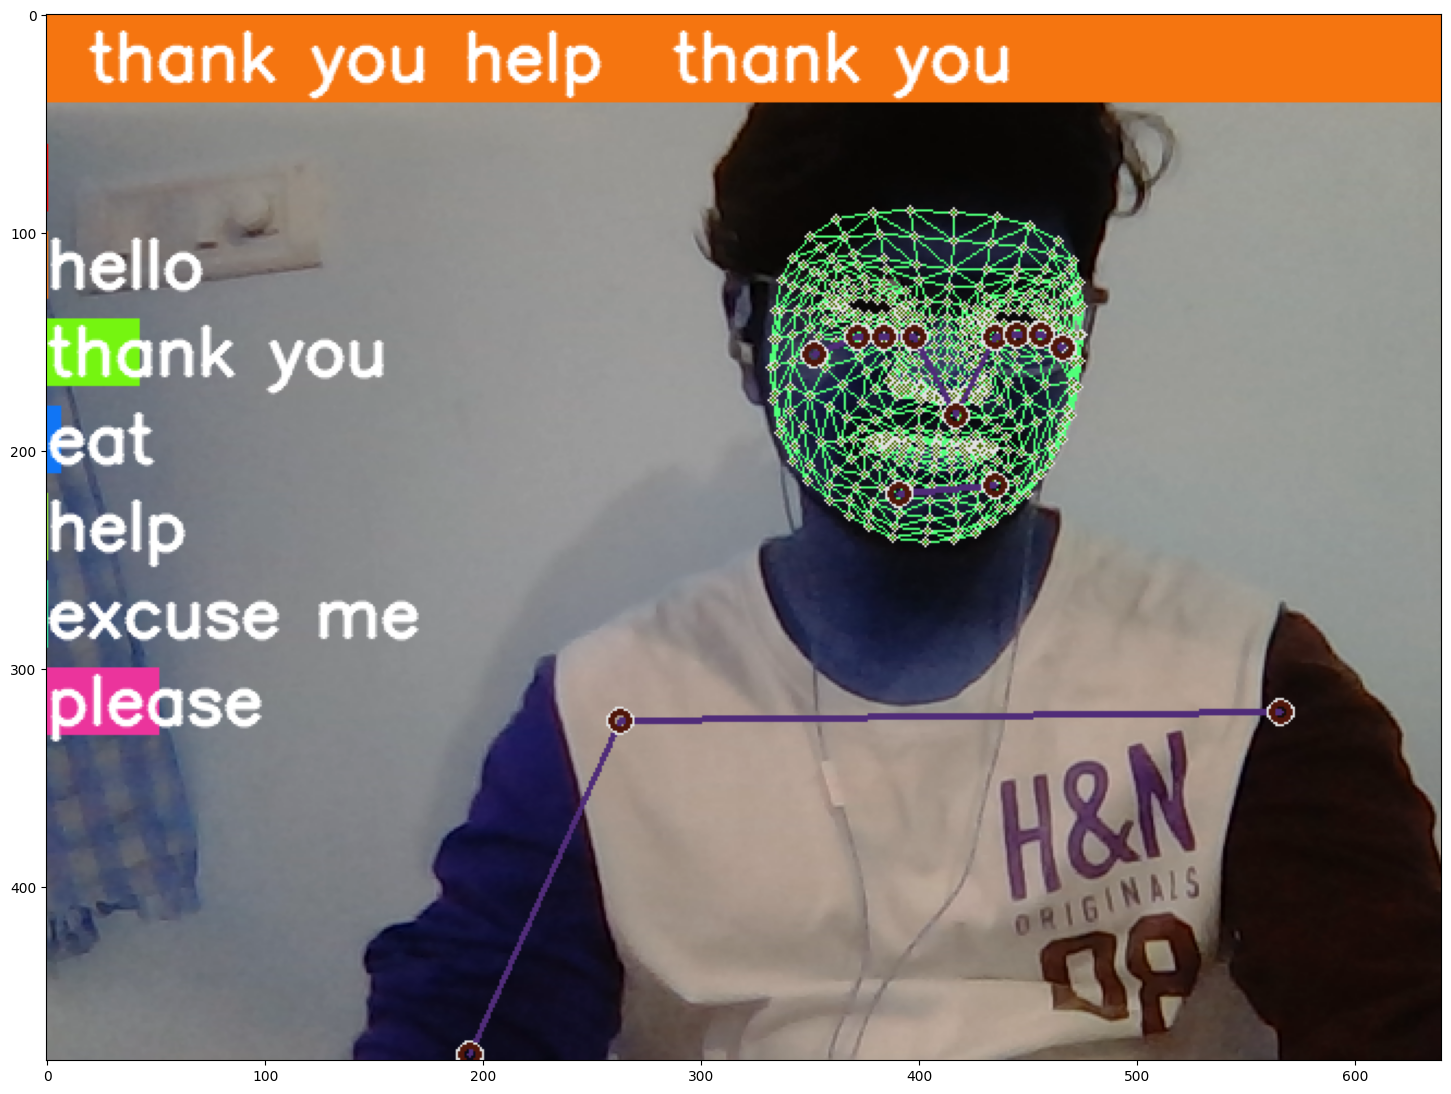

In [48]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))